In [1]:
!pip install torch torchvision timm  torchmetrics rasterio geopandas numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 76.4 MB/s eta 0:00:00


In [ ]:
import shutil

#define src and dst paths
src_path = '/content/drive/MyDrive/GEE_Exports/fullscl'
dst_path = '/content/GEE_Exports'

# Copy entire directory tree
shutil.copytree(src_path, dst_path)

'/content/GEE_Exports'

In [ ]:
import shutil, os

# Source and destination paths
src_folder = "/content/drive/MyDrive/GEE_Exports/Splits"
dst_folder = "/content/GEE_Exports/Splits"

# Make sure the destination parent folder exists
os.makedirs(os.path.dirname(dst_folder), exist_ok=True)

# Copy recursively (allow overwrite if folder already exists)
shutil.copytree(src_folder, dst_folder, dirs_exist_ok=True)

print(f"Copied {src_folder} -> {dst_folder}")

Copied /content/drive/MyDrive/GEE_Exports/Splits -> /content/GEE_Exports/Splits


In [ ]:
import rasterio
import numpy as np

def check_nans(image_path):
    with rasterio.open(image_path) as src:
        img_data = src.read()
    total_pixels = img_data.size
    nan_count = np.sum(np.isnan(img_data))
    nan_percentage = (nan_count / total_pixels) * 100 if total_pixels > 0 else 0
    print(f"Image: {image_path}")
    print(f"NaN pixels: {nan_count:,} ({nan_percentage:.2f}%)")

check_nans('/content/GEE_Exports/Images/2020/S2_2020_tile1A.tif')
check_nans('/content/GEE_Exports/Images/2021/S2_2021_tile1A.tif')

Image: /content/GEE_Exports/Images/2020/S2_2020_tile1A.tif
NaN pixels: 16 (0.00%)
Image: /content/GEE_Exports/Images/2021/S2_2021_tile1A.tif
NaN pixels: 16 (0.00%)


Processing 23 tiles: ['tile1A', 'tile1B', 'tile1C', 'tile2A', 'tile2B', 'tile2C', 'tile2D', 'tile2E', 'tile2F', 'tile3A-0000000000-0000000000', 'tile3A-0000000000-0000014848', 'tile3B', 'tile3C', 'tile3D', 'tile3E', 'tile3F', 'tile4A', 'tile4B', 'tile4C', 'tile5A', 'tile5B', 'tile5C', 'tile5D']


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:198: RuntimeWarning: /content/Prodes/yearly_deforestation.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Loaded deforestation shapefile with 749665 polygons
Columns: ['fid', 'state', 'path_row', 'main_class', 'class_name', 'sub_class', 'def_cloud', 'julian_day', 'image_date', 'year', 'area_km', 'scene_id', 'source', 'satellite', 'sensor', 'uuid', 'geometry']
Filtered to 94607 polygons for 2020 and 2021

Processing tile: tile1A
Polygons for tile1A, year 2020: 102
Saved mask to /content/GEE_Exports/Masks/2020/prodes_mask_tile1A_2020.tif
Deforested pixels (1) for 2020: 476,059
Non-deforested pixels (0) for 2020: 24,207,909
Polygons for tile1A, year 2021: 99
Saved mask to /content/GEE_Exports/Masks/2021/prodes_mask_tile1A_2021.tif
Deforested pixels (1) for 2021: 838,744
Non-deforested pixels (0) for 2021: 23,845,224

Processing tile: tile1B
Polygons for tile1B, year 2020: 395
Saved mask to /content/GEE_Exports/Masks/2020/prodes_mask_tile1B_2020.tif
Deforested pixels (1) for 2020: 2,232,946
Non-deforested pixels (0) for 2020: 56,238,975
Polygons for tile1B, year 2021: 255
Saved mask to /conten

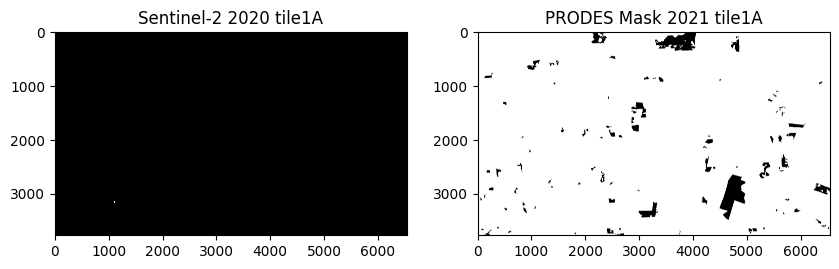

In [ ]:
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
import numpy as np
import os
from shapely.geometry import box
import matplotlib.pyplot as plt

# Define paths
base_dir = '/content/GEE_Exports/Images'
deforestation_shp = '/content/Prodes/yearly_deforestation.shp'
conservation_shp = '/content/Prodes/conservation_units_amazon_biome.shp'
output_dir = '/content/GEE_Exports/Masks'

# Step 1: Define image pairs for all tiles
image_2020_files = [
    'S2_2020_tile1A.tif', 'S2_2020_tile1B.tif', 'S2_2020_tile1C.tif', 'S2_2020_tile2A.tif',
    'S2_2020_tile2B.tif', 'S2_2020_tile2C.tif', 'S2_2020_tile2D.tif', 'S2_2020_tile2E.tif',
    'S2_2020_tile2F.tif', 'S2_2020_tile3A-0000000000-0000000000.tif',
    'S2_2020_tile3A-0000000000-0000014848.tif', 'S2_2020_tile3B.tif', 'S2_2020_tile3C.tif',
    'S2_2020_tile3D.tif', 'S2_2020_tile3E.tif', 'S2_2020_tile3F.tif', 'S2_2020_tile4A.tif',
    'S2_2020_tile4B.tif', 'S2_2020_tile4C.tif', 'S2_2020_tile5A.tif', 'S2_2020_tile5B.tif',
    'S2_2020_tile5C.tif', 'S2_2020_tile5D.tif'
]
image_2021_files = [
    'S2_2021_tile1A.tif', 'S2_2021_tile1B.tif', 'S2_2021_tile1C.tif', 'S2_2021_tile2A.tif',
    'S2_2021_tile2B.tif', 'S2_2021_tile2C.tif', 'S2_2021_tile2D.tif', 'S2_2021_tile2E.tif',
    'S2_2021_tile2F.tif', 'S2_2021_tile3A-0000000000-0000000000.tif',
    'S2_2021_tile3A-0000000000-0000014848.tif', 'S2_2021_tile3B.tif', 'S2_2021_tile3C.tif',
    'S2_2021_tile3D.tif', 'S2_2021_tile3E.tif', 'S2_2021_tile3F.tif', 'S2_2021_tile4A.tif',
    'S2_2021_tile4B.tif', 'S2_2021_tile4C.tif', 'S2_2021_tile5A.tif', 'S2_2021_tile5B.tif',
    'S2_2021_tile5C.tif', 'S2_2021_tile5D.tif'
]
image_pairs = {
    os.path.splitext(f)[0].replace('S2_2020_', ''): (
        f'{base_dir}/2020/{f}',
        f'{base_dir}/2021/{f.replace("2020", "2021")}'
    ) for f in image_2020_files
}

print(f"Processing {len(image_pairs)} tiles: {list(image_pairs.keys())}")

# Step 2: Verify shapefile components
def check_shapefile(shp_path):
    base = os.path.splitext(shp_path)[0]
    required_extensions = ['.shp', '.shx', '.dbf']
    missing = [ext for ext in required_extensions if not os.path.exists(f"{base}{ext}")]
    if missing:
        print(f"Error: Missing shapefile components for {shp_path}: {missing}")
        return False
    return True

if not check_shapefile(deforestation_shp):
    raise FileNotFoundError("Incomplete yearly_deforestation shapefile")
if not check_shapefile(conservation_shp):
    print("Warning: Incomplete conservation_units shapefile. Proceeding without conservation filter.")

# Step 3: Load PRODES deforestation shapefile
try:
    gdf_deforestation = gpd.read_file(deforestation_shp)
    print(f"Loaded deforestation shapefile with {len(gdf_deforestation)} polygons")
    print("Columns:", list(gdf_deforestation.columns))
except Exception as e:
    print(f"Error loading deforestation shapefile: {str(e)}")
    raise

# Filter for 2020 and 2021
year_column = 'year'
if year_column not in gdf_deforestation.columns:
    print(f"Year column '{year_column}' not found. Available columns: {list(gdf_deforestation.columns)}")
    raise KeyError("Year column missing")
gdf_filtered = gdf_deforestation[gdf_deforestation[year_column].isin([2020, 2021])]
print(f"Filtered to {len(gdf_filtered)} polygons for 2020 and 2021")

# Step 4: Optional - Load conservation units
use_conservation = False  # Set to True to exclude conservation areas
if use_conservation:
    try:
        gdf_conservation = gpd.read_file(conservation_shp)
        print(f"Loaded conservation units with {len(gdf_conservation)} polygons")
        if gdf_filtered.crs != gdf_conservation.crs:
            gdf_conservation = gdf_conservation.to_crs(gdf_filtered.crs)
        gdf_filtered = gdf_filtered[~gdf_filtered.geometry.intersects(gdf_conservation.geometry.unary_union)]
        print(f"After excluding conservation units: {len(gdf_filtered)} polygons")
    except Exception as e:
        print(f"Error processing conservation shapefile: {str(e)}")
        use_conservation = False
        print("Proceeding without conservation filter.")

# Step 5: Create output directories
output_dirs = {
    2020: f'{output_dir}/2020',
    2021: f'{output_dir}/2021'
}
for year_dir in output_dirs.values():
    os.makedirs(year_dir, exist_ok=True)

# Step 6: Process each tile
for tile_id, (img_2020, img_2021) in image_pairs.items():
    print(f"\nProcessing tile: {tile_id}")

    if not (os.path.exists(img_2020) and os.path.exists(img_2021)):
        print(f"Error: One or both images missing for {tile_id}")
        continue

    try:
        with rasterio.open(img_2020) as src:
            meta = src.meta.copy()
            width, height = src.width, src.height
            transform = src.transform
            bounds = src.bounds
    except Exception as e:
        print(f"Error reading {img_2020}: {str(e)}")
        continue

    # Generate separate masks for 2020 and 2021
    for year in [2020, 2021]:
        gdf_year = gdf_filtered[gdf_filtered[year_column] == year]
        gdf_tile = gdf_year[gdf_year.geometry.intersects(box(*bounds))]
        print(f"Polygons for {tile_id}, year {year}: {len(gdf_tile)}")

        if len(gdf_tile) == 0:
            print(f"No deforestation in {tile_id} for {year}. Creating empty mask.")
            binary_mask = np.zeros((height, width), dtype=np.uint8)
        else:
            shapes = ((geom, 1) for geom in gdf_tile.geometry)
            binary_mask = rasterize(
                shapes=shapes,
                out_shape=(height, width),
                transform=transform,
                fill=0,
                dtype=rasterio.uint8
            )

        output_mask = f'{output_dirs[year]}/prodes_mask_{tile_id}_{year}.tif'
        meta.update({'dtype': 'uint8', 'count': 1, 'compress': 'lzw'})
        with rasterio.open(output_mask, 'w', **meta) as dst:
            dst.write(binary_mask, 1)
        print(f"Saved mask to {output_mask}")

        with rasterio.open(output_mask) as dst:
            mask_data = dst.read(1)
            print(f"Deforested pixels (1) for {year}: {np.sum(mask_data == 1):,}")
            print(f"Non-deforested pixels (0) for {year}: {np.sum(mask_data == 0):,}")

# Step 7: Visualize one tile
if image_pairs:
    tile_id = 'tile1A'
    img_2020 = image_pairs[tile_id][0]
    mask_2021 = f'{output_dirs[2021]}/prodes_mask_{tile_id}_2021.tif'
    try:
        with rasterio.open(img_2020) as src:
            rgb = src.read([4, 3, 2]).transpose(1, 2, 0) / 10000
        with rasterio.open(mask_2021) as dst:
            mask_data = dst.read(1)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1); plt.imshow(rgb); plt.title(f'Sentinel-2 2020 {tile_id}')
        plt.subplot(1, 2, 2); plt.imshow(mask_data, cmap='binary'); plt.title(f'PRODES Mask 2021 {tile_id}')
        plt.show()
    except Exception as e:
        print(f"Error visualizing {tile_id}: {str(e)}")

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# Define paths
image_dir = '/content/GEE_Exports/Images'
mask_dir = '/content/GEE_Exports/Masks'
tiles = [
    'tile1A', 'tile1B', 'tile1C', 'tile2A', 'tile2B', 'tile2C', 'tile2D', 'tile2E', 'tile2F',
    'tile3A-0000000000-0000000000', 'tile3A-0000000000-0000014848', 'tile3B', 'tile3C',
    'tile3D', 'tile3E', 'tile3F', 'tile4A', 'tile4B', 'tile4C', 'tile5A', 'tile5B', 'tile5C', 'tile5D'
]

# Function to normalize image using adjustable percentiles
def normalize_percentile(img, lower_percentile=2, upper_percentile=99):
    img_normalized = np.zeros_like(img)
    for band in range(img.shape[2]):
        band_data = img[:, :, band]
        lower_val, upper_val = np.percentile(band_data[~np.isnan(band_data)], [lower_percentile, upper_percentile])
        band_data = np.clip(band_data, lower_val, upper_val)
        band_data = (band_data - lower_val) / (upper_val - lower_val + 1e-8)
        img_normalized[:, :, band] = band_data
    return img_normalized

# Function to check for NaNs
def check_nans(arr, name="Array"):
    nan_count = np.isnan(arr).sum()
    total = arr.size
    if nan_count > 0:
        print(f" {name}: {nan_count}/{total} pixels are NaN ({(nan_count/total)*100:.2f}%)")
    return nan_count

# Function to visualize a tile
def visualize_tile(tile_id, crop_size=1000, lower_percentile=2, upper_percentile=99):
    img_2020_path = f'{image_dir}/2020/S2_2020_{tile_id}.tif'
    img_2021_path = f'{image_dir}/2021/S2_2021_{tile_id}.tif'
    mask_2020_path = f'{mask_dir}/2020/prodes_mask_{tile_id}_2020.tif'
    mask_2021_path = f'{mask_dir}/2021/prodes_mask_{tile_id}_2021.tif'

    for path in [img_2020_path, img_2021_path, mask_2020_path, mask_2021_path]:
        if not os.path.exists(path):
            print(f" Error: {path} not found")
            return False

    try:
        with rasterio.open(img_2020_path) as src:
            img_2020 = src.read([4, 3, 2]).transpose(1, 2, 0)
            check_nans(img_2020, f"2020 Image {tile_id}")
            height, width = img_2020.shape[:2]
            start_h, start_w = height // 4, width // 4  # Center crop
            img_2020 = img_2020[start_h:start_h+crop_size, start_w:start_w+crop_size]
            img_2020 = normalize_percentile(img_2020, lower_percentile, upper_percentile)

        with rasterio.open(img_2021_path) as src:
            img_2021 = src.read([4, 3, 2]).transpose(1, 2, 0)
            check_nans(img_2021, f"2021 Image {tile_id}")
            img_2021 = img_2021[start_h:start_h+crop_size, start_w:start_w+crop_size]
            img_2021 = normalize_percentile(img_2021, lower_percentile, upper_percentile)

        with rasterio.open(mask_2020_path) as src:
            mask_2020 = src.read(1)
            check_nans(mask_2020, f"2020 Mask {tile_id}")
            mask_2020 = mask_2020[start_h:start_h+crop_size, start_w:start_w+crop_size]

        with rasterio.open(mask_2021_path) as src:
            mask_2021 = src.read(1)
            check_nans(mask_2021, f"2021 Mask {tile_id}")
            mask_2021 = mask_2021[start_h:start_h+crop_size, start_w:start_w+crop_size]

        # Visualization
        plt.figure(figsize=(12, 12))
        plt.subplot(2, 2, 1)
        plt.imshow(np.clip(img_2020, 0, 1))
        plt.title(f'Sentinel-2 2020 {tile_id}')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.imshow(np.clip(img_2021, 0, 1))
        plt.title(f'Sentinel-2 2021 {tile_id}')
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(mask_2020, cmap='binary')
        plt.title(f'PRODES Mask 2020 {tile_id}')
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(mask_2021, cmap='binary')
        plt.title(f'PRODES Mask 2021 {tile_id}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
        return True

    except Exception as e:
        print(f" Error processing {tile_id}: {str(e)}")
        return False


# Run check for NaNs in random tiles
for _ in range(3):
    random_tile = random.choice(tiles)
    print(f"\n🔍 Checking tile: {random_tile}")
    visualize_tile(random_tile, crop_size=1000)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import rasterio
import numpy as np
import os
from itertools import product
from time import time

# Define paths
base_dir = '/content/GEE_Exports/Images'
mask_dir = '/content/GEE_Exports/Masks/2021'  # Using 2021 masks as change masks
patch_dir = '/content/GEE_Exports/Patches'
os.makedirs(f'{patch_dir}/A', exist_ok=True)  # 2020 images
os.makedirs(f'{patch_dir}/B', exist_ok=True)  # 2021 images
os.makedirs(f'{patch_dir}/label', exist_ok=True)  # Masks

# Define patch parameters
patch_size = 256
stride = 256  # Non-overlapping patches
max_patches_per_tile = 1000  # Limit to prevent excessive space; adjust as needed
tiles = [
    'tile1A', 'tile1B', 'tile1C', 'tile2A', 'tile2B', 'tile2C', 'tile2D', 'tile2E', 'tile2F',
    'tile3A-0000000000-0000000000', 'tile3A-0000000000-0000014848', 'tile3B', 'tile3C',
    'tile3D', 'tile3E', 'tile3F', 'tile4A', 'tile4B', 'tile4C', 'tile5A', 'tile5B', 'tile5C', 'tile5D'
]

start_time = time()
total_patches = 0

for tile_id in tiles:
    img_2020_path = f'{base_dir}/2020/S2_2020_{tile_id}.tif'
    img_2021_path = f'{base_dir}/2021/S2_2021_{tile_id}.tif'
    mask_path = f'{mask_dir}/prodes_mask_{tile_id}_2021.tif'

    try:
        with rasterio.open(img_2020_path) as src:
            img_2020 = src.read()
            meta = src.meta.copy()
            meta.update({'compress': 'lzw'})  # Ensure compression
        with rasterio.open(img_2021_path) as src:
            img_2021 = src.read()
        with rasterio.open(mask_path) as src:
            mask = src.read(1)
            mask_meta = src.meta.copy()
            mask_meta.update({'compress': 'lzw'})

        height, width = mask.shape
        patch_count = 0

        for i, j in product(range(0, height - patch_size + 1, stride), range(0, width - patch_size + 1)):
            if patch_count >= max_patches_per_tile:
                print(f"Max patches ({max_patches_per_tile}) reached for {tile_id}, skipping remaining patches")
                break

            patch_2020 = img_2020[:, i:i+patch_size, j:j+patch_size]
            patch_2021 = img_2021[:, i:i+patch_size, j:j+patch_size]
            patch_mask = mask[i:i+patch_size, j:j+patch_size]

            if np.sum(patch_mask) > 0:  # Save only patches with deforestation
                patch_name = f'{tile_id}_{i}_{j}'
                meta.update({
                    'height': patch_size,
                    'width': patch_size,
                    'transform': rasterio.transform.from_origin(j * meta['transform'][1], (height - i) * meta['transform'][5], meta['transform'][1], meta['transform'][5])
                })
                mask_meta.update({
                    'height': patch_size,
                    'width': patch_size,
                    'transform': rasterio.transform.from_origin(j * mask_meta['transform'][1], (height - i) * mask_meta['transform'][5], mask_meta['transform'][1], mask_meta['transform'][5]),
                    'count': 1,
                    'dtype': 'uint8'
                })

                with rasterio.open(f'{patch_dir}/A/{patch_name}.tif', 'w', **meta) as dst:
                    dst.write(patch_2020)
                with rasterio.open(f'{patch_dir}/B/{patch_name}.tif', 'w', **meta) as dst:
                    dst.write(patch_2021)
                with rasterio.open(f'{patch_dir}/label/{patch_name}.tif', 'w', **mask_meta) as dst:
                    dst.write(patch_mask, 1)
                print(f"Saved patch {patch_name}")
                patch_count += 1
                total_patches += 1

        print(f"Processed {tile_id}: {patch_count} patches saved")
    except Exception as e:
        print(f"Error processing {tile_id}: {str(e)}")

print(f"Total patches saved: {total_patches}")
print(f"Total time: {time() - start_time:.2f} seconds")

Streaming output truncated to the last 5000 lines.
Saved patch tile4C_0_275
Saved patch tile4C_0_276
Saved patch tile4C_0_277
Saved patch tile4C_0_278
Saved patch tile4C_0_279
Saved patch tile4C_0_280
Saved patch tile4C_0_281
Saved patch tile4C_0_282
Saved patch tile4C_0_283
Saved patch tile4C_0_284
Saved patch tile4C_0_285
Saved patch tile4C_0_286
Saved patch tile4C_0_287
Saved patch tile4C_0_288
Saved patch tile4C_0_289
Saved patch tile4C_0_290
Saved patch tile4C_0_291
Saved patch tile4C_0_292
Saved patch tile4C_0_293
Saved patch tile4C_0_294
Saved patch tile4C_0_295
Saved patch tile4C_0_296
Saved patch tile4C_0_297
Saved patch tile4C_0_298
Saved patch tile4C_0_299
Saved patch tile4C_0_300
Saved patch tile4C_0_301
Saved patch tile4C_0_302
Saved patch tile4C_0_303
Saved patch tile4C_0_304
Saved patch tile4C_0_305
Saved patch tile4C_0_306
Saved patch tile4C_0_307
Saved patch tile4C_0_308
Saved patch tile4C_0_309
Saved patch tile4C_0_310
Saved patch tile4C_0_311
Saved patch tile4C_0_312

In [ ]:
import os
import shutil
import rasterio
from sklearn.model_selection import train_test_split
import numpy as np

# Define paths
base_patch_dir = '/content/GEE_Exports/Patches'
split_dir = '/content/GEE_Exports/Splits'
os.makedirs(f'{split_dir}/train/A', exist_ok=True)
os.makedirs(f'{split_dir}/train/B', exist_ok=True)
os.makedirs(f'{split_dir}/train/label', exist_ok=True)
os.makedirs(f'{split_dir}/val/A', exist_ok=True)
os.makedirs(f'{split_dir}/val/B', exist_ok=True)
os.makedirs(f'{split_dir}/val/label', exist_ok=True)
os.makedirs(f'{split_dir}/test/A', exist_ok=True)
os.makedirs(f'{split_dir}/test/B', exist_ok=True)
os.makedirs(f'{split_dir}/test/label', exist_ok=True)

# Get list of patch files
patch_files = [f for f in os.listdir(f'{base_patch_dir}/label') if f.endswith('.tif')]
total_patches = len(patch_files)
print(f"Total patches: {total_patches}")

# Determine stratification labels (1 if deforested pixels exist, all patches have some)
labels = []
for file in patch_files:
    with rasterio.open(f'{base_patch_dir}/label/{file}') as src:
        mask = src.read(1)
        labels.append(1 if np.sum(mask) > 0 else 0)  # All should be 1 due to filtering

# Stratified split: 60% train, 20% val, 20% test
train_val_files, test_files, train_val_labels, test_labels = train_test_split(
    patch_files, labels, test_size=0.2, stratify=labels, random_state=42
)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_val_files, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
)  # 0.25 of 80% = 20% of total

print(f"Train patches: {len(train_files)}")
print(f"Validation patches: {len(val_files)}")
print(f"Test patches: {len(test_files)}")

# Move files to respective directories
for split, files in [('train', train_files), ('val', val_files), ('test', test_files)]:
    for file in files:
        for subdir in ['A', 'B', 'label']:
            src_path = f'{base_patch_dir}/{subdir}/{file}'
            dst_path = f'{split_dir}/{split}/{subdir}/{file}'
            shutil.copy(src_path, dst_path)  # Use copy to preserve original data
        print(f"Copied {file} to {split}/{subdir}")

print("Dataset split complete!")

Streaming output truncated to the last 5000 lines.
Copied tile3C_0_3260.tif to val/label
Copied tile3F_256_2029.tif to val/label
Copied tile5B_256_5094.tif to val/label
Copied tile1A_0_2054.tif to val/label
Copied tile1B_0_1520.tif to val/label
Copied tile2B_0_4363.tif to val/label
Copied tile5A_1024_605.tif to val/label
Copied tile2B_0_5015.tif to val/label
Copied tile3C_256_832.tif to val/label
Copied tile3B_512_1927.tif to val/label
Copied tile5A_1024_834.tif to val/label
Copied tile3B_768_2193.tif to val/label
Copied tile2B_0_5182.tif to val/label
Copied tile1B_0_584.tif to val/label
Copied tile3F_512_2189.tif to val/label
Copied tile1A_0_1935.tif to val/label
Copied tile2B_0_4594.tif to val/label
Copied tile1B_0_875.tif to val/label
Copied tile4C_0_810.tif to val/label
Copied tile1A_0_2010.tif to val/label
Copied tile2B_0_4522.tif to val/label
Copied tile3C_0_3158.tif to val/label
Copied tile5C_0_141.tif to val/label
Copied tile1A_0_1981.tif to val/label
Copied tile4A_256_394.tif 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.vision_transformer import VisionTransformer

class FeatureDifferenceModule(nn.Module):
    """Computes feature differences using absolute difference and Conv2D."""
    def __init__(self, in_channels):
        super(FeatureDifferenceModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1)  # Reduced channels
        self.bn = nn.BatchNorm2d(in_channels // 2)
        self.relu = nn.ReLU()

    def forward(self, feat1, feat2):
        x = torch.abs(feat1 - feat2)  # Absolute difference
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class DeconvDecoder(nn.Module):
    """Deconvolution-based decoder for better spatial reconstruction."""
    def __init__(self, in_channels, num_classes):
        super(DeconvDecoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(in_channels // 2, 128, kernel_size=3, stride=2, padding=1, output_padding=1)  # Reduced channels
        self.deconv2 = nn.ConvTranspose2d(128, 32, kernel_size=3, stride=2, padding=1, output_padding=1)  # Reduced channels
        self.deconv3 = nn.ConvTranspose2d(32, num_classes, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        return x

class ChangeFormer(nn.Module):
    """Transformer-based Change Detection Model with shared encoder."""
    def __init__(self, img_size=256, num_classes=1):
        super(ChangeFormer, self).__init__()
        self.encoder = VisionTransformer(
            img_size=img_size,
            patch_size=16,
            embed_dim=384,
            depth=4,
            num_heads=6,
            in_chans=4,
        )

        self.feature_diff = FeatureDifferenceModule(in_channels=384)
        self.decoder = DeconvDecoder(in_channels=384, num_classes=num_classes)
        self.img_size = img_size
        self.patch_size = 16

    def forward(self, img1, img2):
        # Extract features using a shared encoder
        feat1 = self.encoder.forward_features(img1)  # (B, num_tokens, embed_dim)
        feat2 = self.encoder.forward_features(img2)

        # Remove the class token
        feat1 = feat1[:, 1:, :]
        feat2 = feat2[:, 1:, :]

        # Compute spatial dimensions
        B, N, C = feat1.shape
        h = w = self.img_size // self.patch_size

        # Reshape tokens into spatial feature maps: (B, C, h, w)
        feat1 = feat1.transpose(1, 2).view(B, C, h, w)
        feat2 = feat2.transpose(1, 2).view(B, C, h, w)

        # Compute feature difference
        diff = self.feature_diff(feat1, feat2)

        # Decode feature differences into segmentation map
        out = self.decoder(diff)

        # Upsample to original image size
        out = F.interpolate(out, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)

        return out

# Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChangeFormer(num_classes=1).to(device)
print(" ChangeFormer Model Initialized!")

 ChangeFormer Model Initialized!


In [ ]:
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import re
import rasterio

class ChangeDetectionDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.transform = transform
        self.samples = []

        img_dir_2020 = os.path.join(root_dir, split, 'A')
        img_dir_2021 = os.path.join(root_dir, split, 'B')
        mask_dir = os.path.join(root_dir, split, 'label')

        def list_tif_files(folder):
            return sorted([f for f in os.listdir(folder) if f.endswith('.tif')])

        image_files_2020 = list_tif_files(img_dir_2020)
        image_files_2021 = list_tif_files(img_dir_2021)
        mask_files = list_tif_files(mask_dir)

        def get_patch_key(filename):
            # Remove year prefix, mask suffix, and extension to get base patch key
            key = re.sub(r'(S2_20\d{2}_|_mask|\.tif)', '', filename)
            return key

        img20_dict = {get_patch_key(f): f for f in image_files_2020}
        img21_dict = {get_patch_key(f): f for f in image_files_2021}
        mask_dict = {get_patch_key(f): f for f in mask_files}

        common_keys = set(img20_dict) & set(img21_dict) & set(mask_dict)

        print(f"[{split.upper()}] Found {len(common_keys)} matching samples")

        for key in sorted(common_keys):
            self.samples.append((
                os.path.join(img_dir_2020, img20_dict[key]),
                os.path.join(img_dir_2021, img21_dict[key]),
                os.path.join(mask_dir, mask_dict[key]),
            ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path_2020, img_path_2021, mask_path = self.samples[idx]

        try:
            with rasterio.open(img_path_2020) as src:
                image_2020 = src.read().astype(np.float32)
            with rasterio.open(img_path_2021) as src:
                image_2021 = src.read().astype(np.float32)
            with rasterio.open(mask_path) as src:
                mask = src.read(1).astype(np.uint8)
        except Exception as e:
            raise RuntimeError(f"Error reading files for index {idx}: {e}")

        # Keep only first 4 channels (e.g., RGB + NIR)
        image_2020 = image_2020[:4, :, :]
        image_2021 = image_2021[:4, :, :]

        # Handle NaNs and infs gracefully
        image_2020 = np.nan_to_num(image_2020, nan=0.0, posinf=1.0, neginf=0.0)
        image_2021 = np.nan_to_num(image_2021, nan=0.0, posinf=1.0, neginf=0.0)

        # Normalize images to [0,1]
        image_2020 /= (image_2020.max() + 1e-6)
        image_2021 /= (image_2021.max() + 1e-6)

        image_2020 = np.clip(image_2020, 0.0, 1.0)
        image_2021 = np.clip(image_2021, 0.0, 1.0)

        # Add channel dimension to mask
        mask = np.expand_dims(mask, axis=0)

        if self.transform:
            image_2020 = self.transform(image_2020)
            image_2021 = self.transform(image_2021)
            mask = self.transform(mask)

        return (
            torch.from_numpy(image_2020).float(),
            torch.from_numpy(image_2021).float(),
            torch.from_numpy(mask).float()
        )

In [ ]:
from torch.utils.data import DataLoader

base_dir = "/content/GEE_Exports/Splits"

train_dataset = ChangeDetectionDataset(root_dir=base_dir, split='train')
val_dataset = ChangeDetectionDataset(root_dir=base_dir, split='val')

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Dataloaders ready! Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

[TRAIN] Found 13272 matching samples
[VAL] Found 4424 matching samples
Dataloaders ready! Train samples: 13272, Val samples: 4424


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Focal Loss with clamping
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Clamp logits to prevent extreme values that cause NaNs in sigmoid
        inputs = torch.clamp(inputs, min=-20, max=20)

        # BCE with logits (no need to sigmoid first)
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        probs = torch.sigmoid(inputs).clamp(min=1e-7, max=1 - 1e-7)

        # Compute focal loss factor
        focal_factor = self.alpha * (1 - probs) ** self.gamma * targets + \
                       (1 - self.alpha) * probs ** self.gamma * (1 - targets)
        loss = focal_factor * BCE_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# Dice Loss for segmentation with batch safety
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, preds, targets, smooth=1):
        preds = torch.sigmoid(preds).clamp(min=1e-7, max=1 - 1e-7)
        preds = preds.flatten(start_dim=1)
        targets = targets.flatten(start_dim=1)
        intersection = (preds * targets).sum(dim=1)
        dice = (2. * intersection + smooth) / (preds.sum(dim=1) + targets.sum(dim=1) + smooth)
        return 1 - dice.mean()

# Combined Dice + Focal Loss
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, focal_alpha=0.25, focal_gamma=2.0):
        super(CombinedLoss, self).__init__()
        self.dice = DiceLoss()
        self.focal = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
        self.alpha = alpha  # Weight for Dice loss

    def forward(self, preds, targets):
        loss_dice = self.dice(preds, targets)
        loss_focal = self.focal(preds, targets)
        return self.alpha * loss_dice + (1 - self.alpha) * loss_focal

print("Training Components Ready!")

Training Components Ready!


In [ ]:
import torch
from tqdm import tqdm
import numpy as np

# -----------------------------
# METRIC FUNCTIONS
# -----------------------------
def compute_metrics(preds, targets, threshold=0.5, epsilon=1e-7):
    preds = (torch.sigmoid(preds) > threshold).float()

    TP = (preds * targets).sum().item()
    FP = ((preds == 1) & (targets == 0)).sum().item()
    FN = ((preds == 0) & (targets == 1)).sum().item()

    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * precision * recall / (precision + recall + epsilon)
    iou = TP / (TP + FP + FN + epsilon)

    return precision, recall, f1, iou

# -----------------------------
# TRAINING LOOP
# -----------------------------
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler=None,
    num_epochs=20,
    device='cuda',
    skip_empty_masks=True,
    print_freq=10
):
    best_val_loss = float('inf')

    # To keep track of metrics for plotting
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_precision': [],
        'train_recall': [],
        'train_f1': [],
        'train_iou': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'val_iou': []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        train_loss, train_metrics = [], []

        for i, (img1, img2, mask) in enumerate(tqdm(train_loader, desc="Training")):
            img1, img2, mask = img1.to(device), img2.to(device), mask.to(device)

            if skip_empty_masks and mask.sum().item() == 0:
                continue

            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs, mask)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            train_metrics.append(compute_metrics(outputs.detach(), mask))

            if i % print_freq == 0:
                print(f"Batch {i} Loss: {loss.item():.4f} | Output Range: [{outputs.min().item():.3f}, {outputs.max().item():.3f}]")

        avg_train_loss = np.mean(train_loss)
        avg_train_metrics = np.mean(train_metrics, axis=0)

        print(f"Train Loss: {avg_train_loss:.4f} | "
              f"Precision: {avg_train_metrics[0]:.4f} | Recall: {avg_train_metrics[1]:.4f} | "
              f"F1: {avg_train_metrics[2]:.4f} | IoU: {avg_train_metrics[3]:.4f}")

        # Save training metrics
        history['train_loss'].append(avg_train_loss)
        history['train_precision'].append(avg_train_metrics[0])
        history['train_recall'].append(avg_train_metrics[1])
        history['train_f1'].append(avg_train_metrics[2])
        history['train_iou'].append(avg_train_metrics[3])

        # -----------------------------
        # Validation
        # -----------------------------
        model.eval()
        val_loss, val_metrics = [], []

        with torch.no_grad():
            for img1, img2, mask in tqdm(val_loader, desc="Validating"):
                img1, img2, mask = img1.to(device), img2.to(device), mask.to(device)

                outputs = model(img1, img2)
                loss = criterion(outputs, mask)

                val_loss.append(loss.item())
                val_metrics.append(compute_metrics(outputs, mask))

        avg_val_loss = np.mean(val_loss)
        avg_val_metrics = np.mean(val_metrics, axis=0)

        print(f"Val Loss: {avg_val_loss:.4f} | "
              f"Precision: {avg_val_metrics[0]:.4f} | Recall: {avg_val_metrics[1]:.4f} | "
              f"F1: {avg_val_metrics[2]:.4f} | IoU: {avg_val_metrics[3]:.4f}")

        # Save validation metrics
        history['val_loss'].append(avg_val_loss)
        history['val_precision'].append(avg_val_metrics[0])
        history['val_recall'].append(avg_val_metrics[1])
        history['val_f1'].append(avg_val_metrics[2])
        history['val_iou'].append(avg_val_metrics[3])

        # Scheduler step
        if scheduler:
            scheduler.step(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print(" Best model saved!")

    print("Training Complete!")
    return history

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = ChangeFormer(num_classes=1).to(device)

# Define loss
criterion = CombinedLoss(alpha=0.5, focal_alpha=0.25, focal_gamma=2.0)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Optional scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Start training
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=20,
    device=device,
    skip_empty_masks=True
)


Epoch 1/20


Training:   0%|          | 2/830 [00:01<09:38,  1.43it/s]

Batch 0 Loss: 0.5389 | Output Range: [-0.484, 1.210]


Training:   1%|▏         | 12/830 [00:08<07:22,  1.85it/s]

Batch 10 Loss: 0.4987 | Output Range: [-1.303, 0.438]


Training:   3%|▎         | 22/830 [00:14<06:53,  1.96it/s]

Batch 20 Loss: 0.5191 | Output Range: [-2.031, 0.343]


Training:   4%|▍         | 32/830 [00:21<07:27,  1.78it/s]

Batch 30 Loss: 0.4717 | Output Range: [-3.018, 0.447]


Training:   5%|▍         | 41/830 [00:27<08:35,  1.53it/s]

Batch 40 Loss: 0.4725 | Output Range: [-5.074, 0.462]


Training:   6%|▌         | 51/830 [00:34<10:17,  1.26it/s]

Batch 50 Loss: 0.4775 | Output Range: [-6.302, 0.463]


Training:   7%|▋         | 61/830 [00:40<07:48,  1.64it/s]

Batch 60 Loss: 0.4372 | Output Range: [-11.269, 0.481]


Training:   9%|▊         | 71/830 [00:47<11:28,  1.10it/s]

Batch 70 Loss: 0.4345 | Output Range: [-14.963, 0.508]


Training:  10%|▉         | 81/830 [00:53<08:07,  1.54it/s]

Batch 80 Loss: 0.4453 | Output Range: [-15.295, 0.346]


Training:  11%|█         | 91/830 [01:00<10:14,  1.20it/s]

Batch 90 Loss: 0.3967 | Output Range: [-22.581, 0.487]


Training:  12%|█▏        | 101/830 [01:07<07:45,  1.57it/s]

Batch 100 Loss: 0.3870 | Output Range: [-24.705, 0.293]


Training:  13%|█▎        | 111/830 [01:13<09:44,  1.23it/s]

Batch 110 Loss: 0.3400 | Output Range: [-31.184, 0.445]


Training:  15%|█▍        | 122/830 [01:20<06:14,  1.89it/s]

Batch 120 Loss: 0.4184 | Output Range: [-29.211, 0.250]


Training:  16%|█▌        | 131/830 [01:26<07:33,  1.54it/s]

Batch 130 Loss: 0.3570 | Output Range: [-38.838, 0.288]


Training:  17%|█▋        | 142/830 [01:33<06:14,  1.84it/s]

Batch 140 Loss: 0.3981 | Output Range: [-35.560, 0.299]


Training:  18%|█▊        | 152/830 [01:39<05:39,  1.99it/s]

Batch 150 Loss: 0.3171 | Output Range: [-50.902, 0.290]


Training:  20%|█▉        | 162/830 [01:46<06:20,  1.75it/s]

Batch 160 Loss: 0.3855 | Output Range: [-43.642, 0.370]


Training:  21%|██        | 172/830 [01:52<05:34,  1.97it/s]

Batch 170 Loss: 0.3921 | Output Range: [-46.608, 0.414]


Training:  22%|██▏       | 182/830 [02:00<06:28,  1.67it/s]

Batch 180 Loss: 0.3569 | Output Range: [-44.630, 0.569]


Training:  23%|██▎       | 192/830 [02:05<05:23,  1.97it/s]

Batch 190 Loss: 0.3766 | Output Range: [-39.171, 0.812]


Training:  24%|██▍       | 202/830 [02:13<06:43,  1.56it/s]

Batch 200 Loss: 0.3815 | Output Range: [-50.588, 0.832]


Training:  26%|██▌       | 212/830 [02:19<05:19,  1.94it/s]

Batch 210 Loss: 0.3304 | Output Range: [-42.797, 1.527]


Training:  27%|██▋       | 222/830 [02:26<07:21,  1.38it/s]

Batch 220 Loss: 0.3557 | Output Range: [-41.627, 1.536]


Training:  28%|██▊       | 232/830 [02:33<05:29,  1.81it/s]

Batch 230 Loss: 0.3637 | Output Range: [-56.161, 2.014]


Training:  29%|██▉       | 242/830 [02:40<07:12,  1.36it/s]

Batch 240 Loss: 0.3100 | Output Range: [-50.963, 2.463]


Training:  30%|███       | 252/830 [02:46<04:54,  1.96it/s]

Batch 250 Loss: 0.3229 | Output Range: [-53.654, 5.204]


Training:  32%|███▏      | 262/830 [02:53<06:16,  1.51it/s]

Batch 260 Loss: 0.3370 | Output Range: [-55.517, 6.448]


Training:  33%|███▎      | 272/830 [02:59<04:53,  1.90it/s]

Batch 270 Loss: 0.3810 | Output Range: [-50.577, 6.891]


Training:  34%|███▍      | 282/830 [03:05<05:25,  1.69it/s]

Batch 280 Loss: 0.3012 | Output Range: [-48.052, 6.596]


Training:  35%|███▌      | 292/830 [03:12<04:46,  1.88it/s]

Batch 290 Loss: 0.3066 | Output Range: [-53.050, 12.425]


Training:  36%|███▋      | 302/830 [03:18<04:27,  1.97it/s]

Batch 300 Loss: 0.2659 | Output Range: [-54.373, 10.188]


Training:  38%|███▊      | 312/830 [03:25<04:40,  1.85it/s]

Batch 310 Loss: 0.2859 | Output Range: [-54.587, 14.869]


Training:  39%|███▉      | 322/830 [03:31<04:11,  2.02it/s]

Batch 320 Loss: 0.2893 | Output Range: [-54.546, 15.585]


Training:  40%|████      | 332/830 [03:39<04:40,  1.78it/s]

Batch 330 Loss: 0.2945 | Output Range: [-55.845, 11.025]


Training:  41%|████      | 342/830 [03:44<04:03,  2.00it/s]

Batch 340 Loss: 0.1883 | Output Range: [-54.145, 13.738]


Training:  42%|████▏     | 352/830 [03:52<04:49,  1.65it/s]

Batch 350 Loss: 0.2664 | Output Range: [-60.204, 12.726]


Training:  44%|████▎     | 362/830 [03:58<03:57,  1.97it/s]

Batch 360 Loss: 0.2739 | Output Range: [-57.119, 18.546]


Training:  45%|████▍     | 372/830 [04:05<05:07,  1.49it/s]

Batch 370 Loss: 0.2698 | Output Range: [-62.263, 15.386]


Training:  46%|████▌     | 382/830 [04:11<03:49,  1.95it/s]

Batch 380 Loss: 0.3276 | Output Range: [-58.406, 16.914]


Training:  47%|████▋     | 392/830 [04:18<05:16,  1.38it/s]

Batch 390 Loss: 0.2513 | Output Range: [-60.820, 12.693]


Training:  48%|████▊     | 402/830 [04:24<03:47,  1.88it/s]

Batch 400 Loss: 0.2620 | Output Range: [-68.911, 15.162]


Training:  50%|████▉     | 412/830 [04:32<05:36,  1.24it/s]

Batch 410 Loss: 0.2879 | Output Range: [-62.577, 21.979]


Training:  51%|█████     | 422/830 [04:39<03:30,  1.93it/s]

Batch 420 Loss: 0.2671 | Output Range: [-61.312, 13.808]


Training:  52%|█████▏    | 432/830 [04:45<03:48,  1.74it/s]

Batch 430 Loss: 0.3373 | Output Range: [-67.709, 16.893]


Training:  53%|█████▎    | 442/830 [04:52<03:21,  1.93it/s]

Batch 440 Loss: 0.2274 | Output Range: [-64.031, 15.536]


Training:  54%|█████▍    | 452/830 [04:57<03:10,  1.99it/s]

Batch 450 Loss: 0.2126 | Output Range: [-56.147, 17.035]


Training:  56%|█████▌    | 462/830 [05:05<03:19,  1.85it/s]

Batch 460 Loss: 0.2814 | Output Range: [-64.466, 20.561]


Training:  57%|█████▋    | 472/830 [05:11<03:03,  1.95it/s]

Batch 470 Loss: 0.2570 | Output Range: [-56.074, 12.259]


Training:  58%|█████▊    | 482/830 [05:18<03:16,  1.77it/s]

Batch 480 Loss: 0.2615 | Output Range: [-60.708, 17.882]


Training:  59%|█████▉    | 492/830 [05:24<02:50,  1.98it/s]

Batch 490 Loss: 0.2042 | Output Range: [-64.137, 11.180]


Training:  60%|██████    | 502/830 [05:31<03:26,  1.59it/s]

Batch 500 Loss: 0.2976 | Output Range: [-66.674, 17.642]


Training:  62%|██████▏   | 512/830 [05:37<02:41,  1.97it/s]

Batch 510 Loss: 0.2203 | Output Range: [-59.028, 19.307]


Training:  63%|██████▎   | 522/830 [05:44<03:46,  1.36it/s]

Batch 520 Loss: 0.2780 | Output Range: [-63.946, 18.042]


Training:  64%|██████▍   | 532/830 [05:50<02:38,  1.88it/s]

Batch 530 Loss: 0.2182 | Output Range: [-59.086, 19.330]


Training:  65%|██████▌   | 542/830 [05:57<03:19,  1.44it/s]

Batch 540 Loss: 0.2133 | Output Range: [-75.250, 24.006]


Training:  67%|██████▋   | 552/830 [06:03<02:26,  1.89it/s]

Batch 550 Loss: 0.1513 | Output Range: [-54.470, 23.696]


Training:  68%|██████▊   | 562/830 [06:10<02:50,  1.57it/s]

Batch 560 Loss: 0.2330 | Output Range: [-73.089, 16.956]


Training:  69%|██████▉   | 572/830 [06:17<02:17,  1.88it/s]

Batch 570 Loss: 0.2366 | Output Range: [-59.693, 18.379]


Training:  70%|███████   | 582/830 [06:23<02:12,  1.88it/s]

Batch 580 Loss: 0.2130 | Output Range: [-69.815, 15.338]


Training:  71%|███████▏  | 592/830 [06:30<02:08,  1.85it/s]

Batch 590 Loss: 0.2277 | Output Range: [-69.152, 20.815]


Training:  73%|███████▎  | 602/830 [06:36<01:52,  2.02it/s]

Batch 600 Loss: 0.2131 | Output Range: [-58.611, 20.065]


Training:  74%|███████▎  | 612/830 [06:43<02:02,  1.78it/s]

Batch 610 Loss: 0.2242 | Output Range: [-59.710, 15.523]


Training:  75%|███████▍  | 622/830 [06:49<01:47,  1.94it/s]

Batch 620 Loss: 0.1867 | Output Range: [-64.901, 29.929]


Training:  76%|███████▌  | 632/830 [06:56<01:55,  1.71it/s]

Batch 630 Loss: 0.1421 | Output Range: [-65.527, 23.639]


Training:  77%|███████▋  | 642/830 [07:02<01:36,  1.94it/s]

Batch 640 Loss: 0.1598 | Output Range: [-69.597, 33.747]


Training:  79%|███████▊  | 652/830 [07:10<01:48,  1.64it/s]

Batch 650 Loss: 0.1445 | Output Range: [-63.107, 29.631]


Training:  80%|███████▉  | 662/830 [07:16<01:28,  1.90it/s]

Batch 660 Loss: 0.2049 | Output Range: [-67.415, 27.290]


Training:  81%|████████  | 672/830 [07:23<01:50,  1.43it/s]

Batch 670 Loss: 0.2917 | Output Range: [-80.593, 24.851]


Training:  82%|████████▏ | 682/830 [07:29<01:16,  1.94it/s]

Batch 680 Loss: 0.1619 | Output Range: [-69.660, 29.608]


Training:  83%|████████▎ | 692/830 [07:36<01:41,  1.37it/s]

Batch 690 Loss: 0.1521 | Output Range: [-73.908, 32.392]


Training:  85%|████████▍ | 702/830 [07:42<01:06,  1.94it/s]

Batch 700 Loss: 0.2042 | Output Range: [-66.307, 31.059]


Training:  86%|████████▌ | 712/830 [07:48<01:15,  1.56it/s]

Batch 710 Loss: 0.1802 | Output Range: [-70.035, 23.967]


Training:  87%|████████▋ | 722/830 [07:55<00:57,  1.87it/s]

Batch 720 Loss: 0.1934 | Output Range: [-73.730, 21.077]


Training:  88%|████████▊ | 732/830 [08:01<00:56,  1.74it/s]

Batch 730 Loss: 0.2183 | Output Range: [-74.533, 30.024]


Training:  89%|████████▉ | 742/830 [08:09<00:46,  1.88it/s]

Batch 740 Loss: 0.2417 | Output Range: [-81.410, 28.814]


Training:  91%|█████████ | 752/830 [08:14<00:40,  1.92it/s]

Batch 750 Loss: 0.2435 | Output Range: [-75.772, 23.788]


Training:  92%|█████████▏| 762/830 [08:22<00:37,  1.81it/s]

Batch 760 Loss: 0.1940 | Output Range: [-68.908, 22.229]


Training:  93%|█████████▎| 772/830 [08:28<00:29,  1.94it/s]

Batch 770 Loss: 0.1606 | Output Range: [-65.319, 20.163]


Training:  94%|█████████▍| 781/830 [08:35<00:36,  1.35it/s]

Batch 780 Loss: 0.2244 | Output Range: [-66.415, 25.260]


Training:  95%|█████████▌| 791/830 [08:41<00:25,  1.55it/s]

Batch 790 Loss: 0.2147 | Output Range: [-77.128, 26.104]


Training:  97%|█████████▋| 802/830 [08:48<00:17,  1.61it/s]

Batch 800 Loss: 0.1634 | Output Range: [-78.601, 39.188]


Training:  98%|█████████▊| 812/830 [08:54<00:09,  1.96it/s]

Batch 810 Loss: 0.1881 | Output Range: [-76.470, 32.378]


Training:  99%|█████████▉| 822/830 [09:02<00:05,  1.45it/s]

Batch 820 Loss: 0.1648 | Output Range: [-65.931, 34.132]


Training: 100%|██████████| 830/830 [09:06<00:00,  1.52it/s]


Train Loss: 0.2787 | Precision: 0.6790 | Recall: 0.7406 | F1: 0.6885 | IoU: 0.5513


Validating: 100%|██████████| 277/277 [02:52<00:00,  1.61it/s]


Val Loss: 0.1761 | Precision: 0.6916 | Recall: 0.8440 | F1: 0.7472 | IoU: 0.6251
 Best model saved!

Epoch 2/20


Training:   0%|          | 2/830 [00:02<13:59,  1.01s/it]

Batch 0 Loss: 0.1954 | Output Range: [-68.162, 27.435]


Training:   1%|▏         | 12/830 [00:08<07:13,  1.89it/s]

Batch 10 Loss: 0.1748 | Output Range: [-64.767, 30.696]


Training:   3%|▎         | 22/830 [00:14<07:13,  1.87it/s]

Batch 20 Loss: 0.2051 | Output Range: [-66.423, 37.775]


Training:   4%|▍         | 32/830 [00:22<07:18,  1.82it/s]

Batch 30 Loss: 0.1158 | Output Range: [-67.212, 31.808]


Training:   5%|▌         | 42/830 [00:28<06:39,  1.97it/s]

Batch 40 Loss: 0.1392 | Output Range: [-75.791, 34.276]


Training:   6%|▋         | 52/830 [00:35<07:02,  1.84it/s]

Batch 50 Loss: 0.1767 | Output Range: [-79.664, 29.948]


Training:   7%|▋         | 62/830 [00:41<06:24,  2.00it/s]

Batch 60 Loss: 0.1934 | Output Range: [-78.033, 25.049]


Training:   9%|▊         | 71/830 [00:48<09:11,  1.38it/s]

Batch 70 Loss: 0.1504 | Output Range: [-79.943, 25.100]


Training:  10%|▉         | 81/830 [00:54<07:44,  1.61it/s]

Batch 80 Loss: 0.1991 | Output Range: [-68.986, 29.208]


Training:  11%|█         | 92/830 [01:01<07:50,  1.57it/s]

Batch 90 Loss: 0.1260 | Output Range: [-70.274, 26.445]


Training:  12%|█▏        | 102/830 [01:07<06:11,  1.96it/s]

Batch 100 Loss: 0.1697 | Output Range: [-82.332, 28.367]


Training:  13%|█▎        | 112/830 [01:15<08:39,  1.38it/s]

Batch 110 Loss: 0.1685 | Output Range: [-77.984, 29.875]


Training:  15%|█▍        | 122/830 [01:21<06:05,  1.94it/s]

Batch 120 Loss: 0.1588 | Output Range: [-94.746, 27.404]


Training:  16%|█▌        | 132/830 [01:28<08:38,  1.35it/s]

Batch 130 Loss: 0.1888 | Output Range: [-77.664, 22.871]


Training:  17%|█▋        | 142/830 [01:34<06:01,  1.90it/s]

Batch 140 Loss: 0.1490 | Output Range: [-63.214, 28.917]


Training:  18%|█▊        | 152/830 [01:41<07:33,  1.50it/s]

Batch 150 Loss: 0.1476 | Output Range: [-89.756, 36.994]


Training:  20%|█▉        | 162/830 [01:48<06:08,  1.81it/s]

Batch 160 Loss: 0.1520 | Output Range: [-99.239, 28.728]


Training:  21%|██        | 172/830 [01:54<07:05,  1.55it/s]

Batch 170 Loss: 0.1090 | Output Range: [-78.316, 32.319]


Training:  22%|██▏       | 182/830 [02:01<05:39,  1.91it/s]

Batch 180 Loss: 0.1327 | Output Range: [-93.056, 28.297]


Training:  23%|██▎       | 192/830 [02:07<05:25,  1.96it/s]

Batch 190 Loss: 0.1365 | Output Range: [-99.775, 38.683]


Training:  24%|██▍       | 202/830 [02:14<05:38,  1.85it/s]

Batch 200 Loss: 0.1306 | Output Range: [-82.388, 34.229]


Training:  25%|██▌       | 211/830 [02:19<06:24,  1.61it/s]

Batch 210 Loss: 0.1094 | Output Range: [-84.463, 27.264]


Training:  27%|██▋       | 221/830 [02:27<07:21,  1.38it/s]

Batch 220 Loss: 0.1936 | Output Range: [-81.877, 38.831]


Training:  28%|██▊       | 231/830 [02:33<06:28,  1.54it/s]

Batch 230 Loss: 0.0884 | Output Range: [-68.448, 21.913]


Training:  29%|██▉       | 241/830 [02:40<07:36,  1.29it/s]

Batch 240 Loss: 0.1267 | Output Range: [-83.963, 24.551]


Training:  30%|███       | 252/830 [02:46<05:04,  1.90it/s]

Batch 250 Loss: 0.1155 | Output Range: [-91.520, 20.593]


Training:  32%|███▏      | 262/830 [02:54<06:13,  1.52it/s]

Batch 260 Loss: 0.1664 | Output Range: [-84.894, 35.348]


Training:  33%|███▎      | 272/830 [03:00<04:54,  1.90it/s]

Batch 270 Loss: 0.1178 | Output Range: [-79.863, 33.064]


Training:  34%|███▍      | 282/830 [03:07<06:44,  1.35it/s]

Batch 280 Loss: 0.1248 | Output Range: [-98.607, 32.228]


Training:  35%|███▌      | 292/830 [03:14<06:31,  1.37it/s]

Batch 290 Loss: 0.1327 | Output Range: [-66.229, 23.408]


Training:  36%|███▋      | 302/830 [03:22<05:50,  1.51it/s]

Batch 300 Loss: 0.0999 | Output Range: [-92.757, 41.869]


Training:  38%|███▊      | 312/830 [03:28<04:19,  1.99it/s]

Batch 310 Loss: 0.0964 | Output Range: [-72.823, 29.038]


Training:  39%|███▉      | 322/830 [03:35<06:13,  1.36it/s]

Batch 320 Loss: 0.0890 | Output Range: [-72.949, 33.952]


Training:  40%|████      | 332/830 [03:41<04:19,  1.92it/s]

Batch 330 Loss: 0.1557 | Output Range: [-79.325, 28.993]


Training:  41%|████      | 342/830 [03:47<05:20,  1.52it/s]

Batch 340 Loss: 0.2036 | Output Range: [-71.121, 38.998]


Training:  42%|████▏     | 352/830 [03:54<04:05,  1.95it/s]

Batch 350 Loss: 0.0789 | Output Range: [-75.275, 32.980]


Training:  44%|████▎     | 362/830 [04:00<04:33,  1.71it/s]

Batch 360 Loss: 0.1237 | Output Range: [-87.833, 27.555]


Training:  45%|████▍     | 372/830 [04:07<04:07,  1.85it/s]

Batch 370 Loss: 0.0889 | Output Range: [-77.612, 21.616]


Training:  46%|████▌     | 382/830 [04:13<03:46,  1.98it/s]

Batch 380 Loss: 0.1158 | Output Range: [-92.383, 34.076]


Training:  47%|████▋     | 392/830 [04:20<04:00,  1.82it/s]

Batch 390 Loss: 0.0997 | Output Range: [-85.614, 28.708]


Training:  48%|████▊     | 402/830 [04:26<03:42,  1.92it/s]

Batch 400 Loss: 0.0971 | Output Range: [-100.118, 34.956]


Training:  50%|████▉     | 412/830 [04:33<03:51,  1.81it/s]

Batch 410 Loss: 0.0992 | Output Range: [-112.916, 31.592]


Training:  51%|█████     | 422/830 [04:39<03:28,  1.96it/s]

Batch 420 Loss: 0.1251 | Output Range: [-82.949, 33.189]


Training:  52%|█████▏    | 432/830 [04:46<03:58,  1.67it/s]

Batch 430 Loss: 0.1036 | Output Range: [-89.731, 34.103]


Training:  53%|█████▎    | 442/830 [04:52<03:15,  1.99it/s]

Batch 440 Loss: 0.1027 | Output Range: [-112.923, 30.352]


Training:  54%|█████▍    | 452/830 [05:00<04:16,  1.47it/s]

Batch 450 Loss: 0.0837 | Output Range: [-98.906, 29.787]


Training:  56%|█████▌    | 462/830 [05:05<03:05,  1.98it/s]

Batch 460 Loss: 0.1666 | Output Range: [-81.579, 32.050]


Training:  57%|█████▋    | 471/830 [05:12<05:23,  1.11it/s]

Batch 470 Loss: 0.0707 | Output Range: [-104.266, 32.804]


Training:  58%|█████▊    | 481/830 [05:18<03:34,  1.63it/s]

Batch 480 Loss: 0.1059 | Output Range: [-80.363, 32.289]


Training:  59%|█████▉    | 491/830 [05:25<04:29,  1.26it/s]

Batch 490 Loss: 0.1235 | Output Range: [-87.407, 32.872]


Training:  60%|██████    | 501/830 [05:31<03:29,  1.57it/s]

Batch 500 Loss: 0.0779 | Output Range: [-81.057, 43.610]


Training:  62%|██████▏   | 511/830 [05:37<03:12,  1.66it/s]

Batch 510 Loss: 0.1627 | Output Range: [-80.077, 37.426]


Training:  63%|██████▎   | 521/830 [05:44<03:17,  1.56it/s]

Batch 520 Loss: 0.1580 | Output Range: [-84.009, 26.321]


Training:  64%|██████▍   | 531/830 [05:50<03:08,  1.58it/s]

Batch 530 Loss: 0.0854 | Output Range: [-79.651, 41.660]


Training:  65%|██████▌   | 541/830 [05:58<03:18,  1.46it/s]

Batch 540 Loss: 0.1342 | Output Range: [-80.669, 32.878]


Training:  66%|██████▋   | 551/830 [06:03<02:47,  1.67it/s]

Batch 550 Loss: 0.1015 | Output Range: [-107.068, 35.790]


Training:  68%|██████▊   | 561/830 [06:11<03:25,  1.31it/s]

Batch 560 Loss: 0.1443 | Output Range: [-89.511, 35.907]


Training:  69%|██████▉   | 571/830 [06:16<02:46,  1.56it/s]

Batch 570 Loss: 0.0887 | Output Range: [-89.978, 44.937]


Training:  70%|███████   | 581/830 [06:24<03:41,  1.12it/s]

Batch 580 Loss: 0.0840 | Output Range: [-89.652, 38.222]


Training:  71%|███████   | 591/830 [06:29<02:31,  1.57it/s]

Batch 590 Loss: 0.1509 | Output Range: [-90.891, 36.369]


Training:  72%|███████▏  | 601/830 [06:36<03:13,  1.18it/s]

Batch 600 Loss: 0.0777 | Output Range: [-74.104, 28.060]


Training:  74%|███████▎  | 611/830 [06:42<02:15,  1.61it/s]

Batch 610 Loss: 0.1463 | Output Range: [-75.627, 43.245]


Training:  75%|███████▍  | 621/830 [06:48<02:33,  1.36it/s]

Batch 620 Loss: 0.1465 | Output Range: [-88.798, 52.541]


Training:  76%|███████▌  | 631/830 [06:55<02:10,  1.53it/s]

Batch 630 Loss: 0.0816 | Output Range: [-81.825, 40.713]


Training:  77%|███████▋  | 641/830 [07:01<02:03,  1.53it/s]

Batch 640 Loss: 0.0727 | Output Range: [-85.102, 24.850]


Training:  78%|███████▊  | 651/830 [07:09<02:00,  1.49it/s]

Batch 650 Loss: 0.1217 | Output Range: [-102.945, 25.465]


Training:  80%|███████▉  | 661/830 [07:14<01:45,  1.60it/s]

Batch 660 Loss: 0.0999 | Output Range: [-80.688, 29.085]


Training:  81%|████████  | 671/830 [07:22<01:51,  1.42it/s]

Batch 670 Loss: 0.1292 | Output Range: [-82.155, 46.811]


Training:  82%|████████▏ | 681/830 [07:27<01:30,  1.64it/s]

Batch 680 Loss: 0.1238 | Output Range: [-85.742, 41.920]


Training:  83%|████████▎ | 691/830 [07:35<01:41,  1.38it/s]

Batch 690 Loss: 0.1016 | Output Range: [-93.622, 34.158]


Training:  84%|████████▍ | 701/830 [07:40<01:19,  1.62it/s]

Batch 700 Loss: 0.1280 | Output Range: [-110.015, 37.289]


Training:  86%|████████▌ | 711/830 [07:48<01:43,  1.16it/s]

Batch 710 Loss: 0.0784 | Output Range: [-90.062, 22.437]


Training:  87%|████████▋ | 722/830 [07:54<00:55,  1.94it/s]

Batch 720 Loss: 0.1275 | Output Range: [-101.993, 33.266]


Training:  88%|████████▊ | 732/830 [08:01<01:08,  1.42it/s]

Batch 730 Loss: 0.0984 | Output Range: [-90.764, 40.643]


Training:  89%|████████▉ | 742/830 [08:07<00:45,  1.95it/s]

Batch 740 Loss: 0.1085 | Output Range: [-89.573, 40.233]


Training:  91%|█████████ | 752/830 [08:13<00:50,  1.55it/s]

Batch 750 Loss: 0.1062 | Output Range: [-78.533, 35.446]


Training:  92%|█████████▏| 762/830 [08:20<00:34,  1.94it/s]

Batch 760 Loss: 0.0821 | Output Range: [-95.120, 36.237]


Training:  93%|█████████▎| 772/830 [08:26<00:31,  1.83it/s]

Batch 770 Loss: 0.1063 | Output Range: [-85.900, 38.931]


Training:  94%|█████████▍| 782/830 [08:34<00:29,  1.62it/s]

Batch 780 Loss: 0.0918 | Output Range: [-81.625, 31.082]


Training:  95%|█████████▌| 792/830 [08:40<00:18,  2.03it/s]

Batch 790 Loss: 0.0797 | Output Range: [-101.677, 34.180]


Training:  97%|█████████▋| 801/830 [08:47<00:19,  1.51it/s]

Batch 800 Loss: 0.0870 | Output Range: [-102.601, 37.059]


Training:  98%|█████████▊| 811/830 [08:53<00:12,  1.55it/s]

Batch 810 Loss: 0.0704 | Output Range: [-87.050, 36.145]


Training:  99%|█████████▉| 821/830 [09:00<00:06,  1.43it/s]

Batch 820 Loss: 0.0726 | Output Range: [-96.206, 32.079]


Training: 100%|██████████| 830/830 [09:04<00:00,  1.52it/s]


Train Loss: 0.1223 | Precision: 0.9041 | Recall: 0.8781 | F1: 0.8894 | IoU: 0.8036


Validating: 100%|██████████| 277/277 [02:50<00:00,  1.62it/s]


Val Loss: 0.0909 | Precision: 0.9131 | Recall: 0.8509 | F1: 0.8774 | IoU: 0.7907
 Best model saved!

Epoch 3/20


Training:   0%|          | 2/830 [00:02<12:15,  1.13it/s]

Batch 0 Loss: 0.0536 | Output Range: [-89.255, 39.779]


Training:   1%|▏         | 12/830 [00:09<07:23,  1.84it/s]

Batch 10 Loss: 0.0721 | Output Range: [-98.109, 35.416]


Training:   3%|▎         | 22/830 [00:15<07:12,  1.87it/s]

Batch 20 Loss: 0.0518 | Output Range: [-88.169, 32.683]


Training:   4%|▍         | 32/830 [00:22<07:09,  1.86it/s]

Batch 30 Loss: 0.0771 | Output Range: [-99.776, 41.821]


Training:   5%|▌         | 42/830 [00:28<06:48,  1.93it/s]

Batch 40 Loss: 0.0953 | Output Range: [-109.206, 34.072]


Training:   6%|▋         | 52/830 [00:35<07:20,  1.77it/s]

Batch 50 Loss: 0.1077 | Output Range: [-78.775, 33.800]


Training:   7%|▋         | 62/830 [00:41<06:17,  2.04it/s]

Batch 60 Loss: 0.1026 | Output Range: [-94.125, 36.855]


Training:   9%|▊         | 72/830 [00:49<07:24,  1.71it/s]

Batch 70 Loss: 0.0973 | Output Range: [-94.709, 31.110]


Training:  10%|▉         | 82/830 [00:54<06:18,  1.97it/s]

Batch 80 Loss: 0.1316 | Output Range: [-81.337, 35.134]


Training:  11%|█         | 92/830 [01:02<07:59,  1.54it/s]

Batch 90 Loss: 0.0533 | Output Range: [-94.627, 46.768]


Training:  12%|█▏        | 102/830 [01:07<06:06,  1.98it/s]

Batch 100 Loss: 0.0680 | Output Range: [-84.310, 41.313]


Training:  13%|█▎        | 112/830 [01:15<08:47,  1.36it/s]

Batch 110 Loss: 0.0710 | Output Range: [-80.631, 48.551]


Training:  15%|█▍        | 122/830 [01:21<06:01,  1.96it/s]

Batch 120 Loss: 0.1061 | Output Range: [-116.148, 27.694]


Training:  16%|█▌        | 132/830 [01:27<07:38,  1.52it/s]

Batch 130 Loss: 0.0861 | Output Range: [-130.719, 38.560]


Training:  17%|█▋        | 142/830 [01:34<05:54,  1.94it/s]

Batch 140 Loss: 0.1091 | Output Range: [-81.749, 33.587]


Training:  18%|█▊        | 152/830 [01:39<05:46,  1.96it/s]

Batch 150 Loss: 0.0657 | Output Range: [-93.522, 37.699]


Training:  20%|█▉        | 162/830 [01:46<05:56,  1.87it/s]

Batch 160 Loss: 0.0646 | Output Range: [-96.922, 28.998]


Training:  21%|██        | 172/830 [01:52<05:33,  1.98it/s]

Batch 170 Loss: 0.1572 | Output Range: [-102.405, 44.811]


Training:  22%|██▏       | 182/830 [02:01<08:00,  1.35it/s]

Batch 180 Loss: 0.0763 | Output Range: [-96.125, 38.005]


Training:  23%|██▎       | 192/830 [02:09<06:12,  1.71it/s]

Batch 190 Loss: 0.0608 | Output Range: [-115.529, 28.800]


Training:  24%|██▍       | 202/830 [02:17<05:52,  1.78it/s]

Batch 200 Loss: 0.0640 | Output Range: [-108.777, 47.876]


Training:  26%|██▌       | 212/830 [02:22<05:10,  1.99it/s]

Batch 210 Loss: 0.1100 | Output Range: [-97.772, 39.699]


Training:  27%|██▋       | 222/830 [02:30<06:14,  1.62it/s]

Batch 220 Loss: 0.1327 | Output Range: [-104.631, 44.453]


Training:  28%|██▊       | 232/830 [02:36<05:06,  1.95it/s]

Batch 230 Loss: 0.1256 | Output Range: [-94.155, 52.334]


Training:  29%|██▉       | 242/830 [02:43<06:35,  1.49it/s]

Batch 240 Loss: 0.1171 | Output Range: [-122.589, 39.468]


Training:  30%|███       | 252/830 [02:49<04:54,  1.96it/s]

Batch 250 Loss: 0.0805 | Output Range: [-134.262, 47.849]


Training:  32%|███▏      | 262/830 [02:56<06:43,  1.41it/s]

Batch 260 Loss: 0.0947 | Output Range: [-110.621, 39.605]


Training:  33%|███▎      | 272/830 [03:02<04:50,  1.92it/s]

Batch 270 Loss: 0.0789 | Output Range: [-95.416, 35.266]


Training:  34%|███▍      | 282/830 [03:09<06:09,  1.48it/s]

Batch 280 Loss: 0.0878 | Output Range: [-104.385, 33.594]


Training:  35%|███▌      | 292/830 [03:15<04:49,  1.86it/s]

Batch 290 Loss: 0.0817 | Output Range: [-89.473, 38.748]


Training:  36%|███▋      | 302/830 [03:22<05:10,  1.70it/s]

Batch 300 Loss: 0.0481 | Output Range: [-96.273, 43.892]


Training:  38%|███▊      | 312/830 [03:29<04:50,  1.78it/s]

Batch 310 Loss: 0.0885 | Output Range: [-99.591, 44.257]


Training:  39%|███▉      | 322/830 [03:35<04:17,  1.97it/s]

Batch 320 Loss: 0.0530 | Output Range: [-100.400, 44.256]


Training:  40%|████      | 332/830 [03:42<04:27,  1.86it/s]

Batch 330 Loss: 0.0753 | Output Range: [-95.836, 44.619]


Training:  41%|████      | 342/830 [03:48<04:02,  2.01it/s]

Batch 340 Loss: 0.0843 | Output Range: [-98.348, 38.154]


Training:  42%|████▏     | 352/830 [03:55<04:30,  1.76it/s]

Batch 350 Loss: 0.1025 | Output Range: [-100.728, 47.016]


Training:  44%|████▎     | 362/830 [04:01<04:00,  1.94it/s]

Batch 360 Loss: 0.0698 | Output Range: [-107.669, 29.449]


Training:  45%|████▍     | 372/830 [04:08<04:48,  1.59it/s]

Batch 370 Loss: 0.0632 | Output Range: [-89.402, 51.630]


Training:  46%|████▌     | 382/830 [04:14<03:53,  1.92it/s]

Batch 380 Loss: 0.0920 | Output Range: [-103.984, 44.923]


Training:  47%|████▋     | 392/830 [04:21<04:58,  1.47it/s]

Batch 390 Loss: 0.0590 | Output Range: [-104.617, 40.926]


Training:  48%|████▊     | 402/830 [04:27<03:44,  1.91it/s]

Batch 400 Loss: 0.0808 | Output Range: [-102.037, 48.172]


Training:  50%|████▉     | 412/830 [04:34<04:54,  1.42it/s]

Batch 410 Loss: 0.0646 | Output Range: [-121.222, 41.511]


Training:  51%|█████     | 422/830 [04:40<03:24,  1.99it/s]

Batch 420 Loss: 0.1235 | Output Range: [-100.391, 26.964]


Training:  52%|█████▏    | 432/830 [04:47<04:14,  1.56it/s]

Batch 430 Loss: 0.1211 | Output Range: [-120.838, 41.335]


Training:  53%|█████▎    | 442/830 [04:53<03:17,  1.96it/s]

Batch 440 Loss: 0.0842 | Output Range: [-92.854, 48.314]


Training:  54%|█████▍    | 452/830 [04:59<03:18,  1.90it/s]

Batch 450 Loss: 0.0815 | Output Range: [-97.611, 38.718]


Training:  56%|█████▌    | 462/830 [05:06<03:11,  1.92it/s]

Batch 460 Loss: 0.1341 | Output Range: [-98.063, 43.277]


Training:  57%|█████▋    | 472/830 [05:12<03:01,  1.98it/s]

Batch 470 Loss: 0.0813 | Output Range: [-89.285, 45.930]


Training:  58%|█████▊    | 482/830 [05:19<03:10,  1.83it/s]

Batch 480 Loss: 0.1070 | Output Range: [-88.417, 36.098]


Training:  59%|█████▉    | 492/830 [05:25<02:55,  1.93it/s]

Batch 490 Loss: 0.0825 | Output Range: [-91.074, 35.973]


Training:  60%|██████    | 502/830 [05:32<03:06,  1.76it/s]

Batch 500 Loss: 0.0931 | Output Range: [-103.489, 48.549]


Training:  62%|██████▏   | 512/830 [05:38<02:41,  1.97it/s]

Batch 510 Loss: 0.0700 | Output Range: [-85.591, 48.641]


Training:  63%|██████▎   | 522/830 [05:45<03:19,  1.54it/s]

Batch 520 Loss: 0.0897 | Output Range: [-120.075, 38.617]


Training:  64%|██████▍   | 532/830 [05:51<02:32,  1.95it/s]

Batch 530 Loss: 0.0917 | Output Range: [-109.477, 35.176]


Training:  65%|██████▌   | 542/830 [05:59<03:38,  1.32it/s]

Batch 540 Loss: 0.0709 | Output Range: [-119.048, 45.309]


Training:  67%|██████▋   | 552/830 [06:04<02:21,  1.97it/s]

Batch 550 Loss: 0.0719 | Output Range: [-101.969, 37.818]


Training:  68%|██████▊   | 562/830 [06:11<02:58,  1.50it/s]

Batch 560 Loss: 0.0588 | Output Range: [-116.607, 45.865]


Training:  69%|██████▉   | 572/830 [06:18<02:14,  1.93it/s]

Batch 570 Loss: 0.0585 | Output Range: [-96.788, 55.504]


Training:  70%|███████   | 582/830 [06:24<02:25,  1.71it/s]

Batch 580 Loss: 0.0864 | Output Range: [-99.612, 51.748]


Training:  71%|███████▏  | 592/830 [06:31<02:04,  1.91it/s]

Batch 590 Loss: 0.0898 | Output Range: [-91.254, 44.467]


Training:  73%|███████▎  | 602/830 [06:36<01:55,  1.98it/s]

Batch 600 Loss: 0.1284 | Output Range: [-114.215, 24.214]


Training:  74%|███████▎  | 612/830 [06:44<01:57,  1.86it/s]

Batch 610 Loss: 0.0822 | Output Range: [-130.715, 40.140]


Training:  75%|███████▍  | 622/830 [06:49<01:45,  1.97it/s]

Batch 620 Loss: 0.0710 | Output Range: [-95.292, 40.772]


Training:  76%|███████▌  | 632/830 [06:57<01:54,  1.74it/s]

Batch 630 Loss: 0.1054 | Output Range: [-89.603, 45.053]


Training:  77%|███████▋  | 642/830 [07:03<01:36,  1.95it/s]

Batch 640 Loss: 0.0968 | Output Range: [-143.010, 36.485]


Training:  79%|███████▊  | 652/830 [07:10<01:48,  1.63it/s]

Batch 650 Loss: 0.1170 | Output Range: [-102.128, 40.346]


Training:  80%|███████▉  | 662/830 [07:17<01:41,  1.65it/s]

Batch 660 Loss: 0.0649 | Output Range: [-93.210, 49.544]


Training:  81%|████████  | 672/830 [07:25<01:32,  1.71it/s]

Batch 670 Loss: 0.0820 | Output Range: [-108.742, 40.040]


Training:  82%|████████▏ | 682/830 [07:31<01:15,  1.96it/s]

Batch 680 Loss: 0.0875 | Output Range: [-120.862, 37.576]


Training:  83%|████████▎ | 692/830 [07:38<01:24,  1.64it/s]

Batch 690 Loss: 0.0969 | Output Range: [-100.722, 37.337]


Training:  85%|████████▍ | 702/830 [07:44<01:04,  2.00it/s]

Batch 700 Loss: 0.0783 | Output Range: [-143.399, 33.808]


Training:  86%|████████▌ | 712/830 [07:51<01:24,  1.40it/s]

Batch 710 Loss: 0.0800 | Output Range: [-105.465, 31.564]


Training:  87%|████████▋ | 722/830 [07:57<00:55,  1.96it/s]

Batch 720 Loss: 0.0602 | Output Range: [-134.632, 30.885]


Training:  88%|████████▊ | 732/830 [08:04<01:10,  1.39it/s]

Batch 730 Loss: 0.0767 | Output Range: [-93.378, 45.415]


Training:  89%|████████▉ | 742/830 [08:10<00:45,  1.93it/s]

Batch 740 Loss: 0.0715 | Output Range: [-110.181, 49.740]


Training:  91%|█████████ | 752/830 [08:17<00:50,  1.54it/s]

Batch 750 Loss: 0.1114 | Output Range: [-107.974, 48.030]


Training:  92%|█████████▏| 762/830 [08:23<00:35,  1.89it/s]

Batch 760 Loss: 0.1057 | Output Range: [-104.498, 37.146]


Training:  93%|█████████▎| 772/830 [08:29<00:31,  1.85it/s]

Batch 770 Loss: 0.0507 | Output Range: [-99.715, 39.216]


Training:  94%|█████████▍| 782/830 [08:36<00:25,  1.86it/s]

Batch 780 Loss: 0.0782 | Output Range: [-88.062, 40.879]


Training:  95%|█████████▌| 792/830 [08:42<00:19,  1.96it/s]

Batch 790 Loss: 0.0679 | Output Range: [-104.119, 48.743]


Training:  97%|█████████▋| 802/830 [08:50<00:15,  1.80it/s]

Batch 800 Loss: 0.0780 | Output Range: [-100.163, 41.103]


Training:  98%|█████████▊| 812/830 [08:55<00:09,  1.96it/s]

Batch 810 Loss: 0.0553 | Output Range: [-125.781, 50.951]


Training:  99%|█████████▉| 822/830 [09:03<00:04,  1.68it/s]

Batch 820 Loss: 0.0899 | Output Range: [-96.039, 45.251]


Training: 100%|██████████| 830/830 [09:07<00:00,  1.52it/s]


Train Loss: 0.0830 | Precision: 0.9400 | Recall: 0.9227 | F1: 0.9306 | IoU: 0.8711


Validating: 100%|██████████| 277/277 [02:51<00:00,  1.62it/s]


Val Loss: 0.0723 | Precision: 0.9163 | Recall: 0.8952 | F1: 0.9035 | IoU: 0.8300
 Best model saved!

Epoch 4/20


Training:   0%|          | 2/830 [00:02<12:28,  1.11it/s]

Batch 0 Loss: 0.0808 | Output Range: [-111.406, 44.989]


Training:   1%|▏         | 12/830 [00:08<07:12,  1.89it/s]

Batch 10 Loss: 0.0829 | Output Range: [-105.133, 42.608]


Training:   3%|▎         | 22/830 [00:14<06:52,  1.96it/s]

Batch 20 Loss: 0.0739 | Output Range: [-119.257, 35.582]


Training:   4%|▍         | 32/830 [00:22<07:02,  1.89it/s]

Batch 30 Loss: 0.0806 | Output Range: [-110.226, 44.288]


Training:   5%|▌         | 42/830 [00:27<06:41,  1.96it/s]

Batch 40 Loss: 0.1206 | Output Range: [-106.619, 59.995]


Training:   6%|▋         | 52/830 [00:36<09:43,  1.33it/s]

Batch 50 Loss: 0.0604 | Output Range: [-92.940, 37.376]


Training:   7%|▋         | 61/830 [00:42<08:02,  1.59it/s]

Batch 60 Loss: 0.1116 | Output Range: [-103.575, 44.211]


Training:   9%|▊         | 71/830 [00:49<08:52,  1.42it/s]

Batch 70 Loss: 0.0735 | Output Range: [-123.333, 36.611]


Training:  10%|▉         | 81/830 [00:55<07:54,  1.58it/s]

Batch 80 Loss: 0.0509 | Output Range: [-89.684, 40.156]


Training:  11%|█         | 91/830 [01:02<09:07,  1.35it/s]

Batch 90 Loss: 0.0711 | Output Range: [-94.384, 52.042]


Training:  12%|█▏        | 102/830 [01:08<06:12,  1.95it/s]

Batch 100 Loss: 0.0505 | Output Range: [-110.816, 48.081]


Training:  13%|█▎        | 112/830 [01:15<07:50,  1.53it/s]

Batch 110 Loss: 0.1114 | Output Range: [-109.522, 37.570]


Training:  15%|█▍        | 122/830 [01:21<05:58,  1.97it/s]

Batch 120 Loss: 0.0562 | Output Range: [-149.843, 39.794]


Training:  16%|█▌        | 132/830 [01:28<08:22,  1.39it/s]

Batch 130 Loss: 0.0551 | Output Range: [-142.674, 39.638]


Training:  17%|█▋        | 142/830 [01:34<05:54,  1.94it/s]

Batch 140 Loss: 0.0490 | Output Range: [-111.029, 46.321]


Training:  18%|█▊        | 152/830 [01:41<07:28,  1.51it/s]

Batch 150 Loss: 0.0977 | Output Range: [-92.391, 54.056]


Training:  20%|█▉        | 162/830 [01:47<05:44,  1.94it/s]

Batch 160 Loss: 0.0547 | Output Range: [-107.329, 47.029]


Training:  21%|██        | 172/830 [01:54<06:12,  1.77it/s]

Batch 170 Loss: 0.0575 | Output Range: [-132.230, 51.603]


Training:  22%|██▏       | 182/830 [02:01<05:50,  1.85it/s]

Batch 180 Loss: 0.0441 | Output Range: [-100.368, 50.321]


Training:  23%|██▎       | 192/830 [02:07<05:25,  1.96it/s]

Batch 190 Loss: 0.0852 | Output Range: [-93.933, 47.257]


Training:  24%|██▍       | 202/830 [02:14<05:45,  1.82it/s]

Batch 200 Loss: 0.0460 | Output Range: [-124.764, 49.824]


Training:  26%|██▌       | 212/830 [02:20<05:11,  1.99it/s]

Batch 210 Loss: 0.0778 | Output Range: [-124.206, 49.712]


Training:  27%|██▋       | 222/830 [02:27<05:45,  1.76it/s]

Batch 220 Loss: 0.0898 | Output Range: [-115.679, 47.842]


Training:  28%|██▊       | 232/830 [02:33<04:59,  2.00it/s]

Batch 230 Loss: 0.0544 | Output Range: [-122.305, 55.144]


Training:  29%|██▉       | 242/830 [02:40<06:13,  1.57it/s]

Batch 240 Loss: 0.0668 | Output Range: [-118.285, 55.331]


Training:  30%|███       | 252/830 [02:46<04:53,  1.97it/s]

Batch 250 Loss: 0.0466 | Output Range: [-143.949, 48.121]


Training:  32%|███▏      | 262/830 [02:53<07:01,  1.35it/s]

Batch 260 Loss: 0.0419 | Output Range: [-110.809, 51.972]


Training:  33%|███▎      | 272/830 [02:59<04:49,  1.93it/s]

Batch 270 Loss: 0.0694 | Output Range: [-106.678, 46.318]


Training:  34%|███▍      | 282/830 [03:06<06:23,  1.43it/s]

Batch 280 Loss: 0.0506 | Output Range: [-140.125, 57.601]


Training:  35%|███▌      | 292/830 [03:12<04:38,  1.93it/s]

Batch 290 Loss: 0.0525 | Output Range: [-121.330, 48.998]


Training:  36%|███▋      | 302/830 [03:19<05:38,  1.56it/s]

Batch 300 Loss: 0.0809 | Output Range: [-93.938, 41.089]


Training:  38%|███▊      | 312/830 [03:25<04:28,  1.93it/s]

Batch 310 Loss: 0.1086 | Output Range: [-114.436, 45.852]


Training:  39%|███▉      | 322/830 [03:31<04:14,  1.99it/s]

Batch 320 Loss: 0.0518 | Output Range: [-102.697, 53.386]


Training:  40%|████      | 332/830 [03:39<04:30,  1.84it/s]

Batch 330 Loss: 0.0581 | Output Range: [-125.969, 48.993]


Training:  41%|████      | 342/830 [03:44<04:06,  1.98it/s]

Batch 340 Loss: 0.0630 | Output Range: [-118.739, 37.246]


Training:  42%|████▏     | 352/830 [03:52<04:27,  1.79it/s]

Batch 350 Loss: 0.0475 | Output Range: [-124.839, 41.161]


Training:  44%|████▎     | 362/830 [03:58<03:58,  1.96it/s]

Batch 360 Loss: 0.0888 | Output Range: [-133.380, 47.502]


Training:  45%|████▍     | 372/830 [04:05<04:30,  1.69it/s]

Batch 370 Loss: 0.0481 | Output Range: [-116.067, 44.339]


Training:  46%|████▌     | 382/830 [04:11<03:51,  1.93it/s]

Batch 380 Loss: 0.0487 | Output Range: [-101.121, 45.642]


Training:  47%|████▋     | 392/830 [04:18<04:45,  1.53it/s]

Batch 390 Loss: 0.0866 | Output Range: [-105.372, 52.207]


Training:  48%|████▊     | 402/830 [04:24<03:40,  1.94it/s]

Batch 400 Loss: 0.0855 | Output Range: [-113.545, 48.080]


Training:  50%|████▉     | 412/830 [04:31<05:00,  1.39it/s]

Batch 410 Loss: 0.0516 | Output Range: [-158.758, 45.439]


Training:  51%|█████     | 422/830 [04:37<03:35,  1.89it/s]

Batch 420 Loss: 0.0576 | Output Range: [-107.899, 43.723]


Training:  52%|█████▏    | 432/830 [04:44<04:39,  1.43it/s]

Batch 430 Loss: 0.0708 | Output Range: [-132.961, 36.468]


Training:  53%|█████▎    | 442/830 [04:50<03:20,  1.93it/s]

Batch 440 Loss: 0.0481 | Output Range: [-155.388, 46.042]


Training:  54%|█████▍    | 452/830 [04:57<03:54,  1.61it/s]

Batch 450 Loss: 0.0926 | Output Range: [-128.714, 49.692]


Training:  56%|█████▌    | 462/830 [05:03<03:14,  1.89it/s]

Batch 460 Loss: 0.0467 | Output Range: [-109.740, 53.529]


Training:  57%|█████▋    | 472/830 [05:09<03:01,  1.97it/s]

Batch 470 Loss: 0.0730 | Output Range: [-112.450, 41.580]


Training:  58%|█████▊    | 482/830 [05:17<03:05,  1.87it/s]

Batch 480 Loss: 0.0510 | Output Range: [-111.429, 54.456]


Training:  59%|█████▉    | 492/830 [05:22<02:53,  1.94it/s]

Batch 490 Loss: 0.0529 | Output Range: [-121.141, 52.882]


Training:  60%|██████    | 502/830 [05:30<02:59,  1.82it/s]

Batch 500 Loss: 0.0652 | Output Range: [-118.648, 44.110]


Training:  62%|██████▏   | 512/830 [05:36<02:46,  1.91it/s]

Batch 510 Loss: 0.0956 | Output Range: [-121.853, 54.572]


Training:  63%|██████▎   | 522/830 [05:43<02:59,  1.71it/s]

Batch 520 Loss: 0.0847 | Output Range: [-143.292, 37.311]


Training:  64%|██████▍   | 532/830 [05:49<02:31,  1.97it/s]

Batch 530 Loss: 0.0452 | Output Range: [-102.514, 53.734]


Training:  65%|██████▌   | 542/830 [05:58<04:04,  1.18it/s]

Batch 540 Loss: 0.0489 | Output Range: [-102.689, 54.246]


Training:  67%|██████▋   | 552/830 [06:03<02:23,  1.94it/s]

Batch 550 Loss: 0.0754 | Output Range: [-103.122, 51.921]


Training:  68%|██████▊   | 562/830 [06:10<03:04,  1.45it/s]

Batch 560 Loss: 0.0608 | Output Range: [-112.836, 44.413]


Training:  69%|██████▉   | 572/830 [06:17<02:16,  1.89it/s]

Batch 570 Loss: 0.0831 | Output Range: [-114.801, 56.563]


Training:  70%|███████   | 582/830 [06:23<02:23,  1.72it/s]

Batch 580 Loss: 0.0541 | Output Range: [-127.862, 52.146]


Training:  71%|███████▏  | 592/830 [06:30<02:08,  1.86it/s]

Batch 590 Loss: 0.1042 | Output Range: [-121.177, 53.992]


Training:  73%|███████▎  | 602/830 [06:36<01:56,  1.96it/s]

Batch 600 Loss: 0.0627 | Output Range: [-121.265, 47.232]


Training:  74%|███████▎  | 612/830 [06:43<01:58,  1.84it/s]

Batch 610 Loss: 0.0542 | Output Range: [-99.495, 51.113]


Training:  75%|███████▍  | 622/830 [06:49<01:42,  2.02it/s]

Batch 620 Loss: 0.0544 | Output Range: [-107.493, 43.664]


Training:  76%|███████▌  | 632/830 [06:56<01:53,  1.75it/s]

Batch 630 Loss: 0.0560 | Output Range: [-110.132, 52.308]


Training:  77%|███████▋  | 642/830 [07:02<01:36,  1.95it/s]

Batch 640 Loss: 0.1030 | Output Range: [-107.381, 57.237]


Training:  79%|███████▊  | 652/830 [07:09<01:52,  1.59it/s]

Batch 650 Loss: 0.0908 | Output Range: [-96.384, 53.348]


Training:  80%|███████▉  | 662/830 [07:15<01:25,  1.96it/s]

Batch 660 Loss: 0.0982 | Output Range: [-114.477, 46.972]


Training:  81%|████████  | 672/830 [07:22<01:49,  1.44it/s]

Batch 670 Loss: 0.0493 | Output Range: [-114.493, 57.325]


Training:  82%|████████▏ | 682/830 [07:28<01:16,  1.94it/s]

Batch 680 Loss: 0.0662 | Output Range: [-113.551, 41.586]


Training:  83%|████████▎ | 692/830 [07:35<01:37,  1.42it/s]

Batch 690 Loss: 0.0430 | Output Range: [-123.367, 52.258]


Training:  85%|████████▍ | 702/830 [07:41<01:06,  1.93it/s]

Batch 700 Loss: 0.0632 | Output Range: [-120.068, 46.451]


Training:  86%|████████▌ | 712/830 [07:48<01:16,  1.55it/s]

Batch 710 Loss: 0.0453 | Output Range: [-131.550, 44.282]


Training:  87%|████████▋ | 722/830 [07:54<00:55,  1.93it/s]

Batch 720 Loss: 0.0436 | Output Range: [-101.854, 47.120]


Training:  88%|████████▊ | 732/830 [08:00<00:50,  1.93it/s]

Batch 730 Loss: 0.0396 | Output Range: [-103.433, 53.860]


Training:  89%|████████▉ | 742/830 [08:08<00:46,  1.90it/s]

Batch 740 Loss: 0.0783 | Output Range: [-138.537, 47.571]


Training:  91%|█████████ | 752/830 [08:14<00:40,  1.94it/s]

Batch 750 Loss: 0.0515 | Output Range: [-108.900, 47.376]


Training:  92%|█████████▏| 762/830 [08:21<00:37,  1.79it/s]

Batch 760 Loss: 0.0761 | Output Range: [-144.298, 55.341]


Training:  93%|█████████▎| 772/830 [08:27<00:28,  2.00it/s]

Batch 770 Loss: 0.0728 | Output Range: [-171.496, 52.952]


Training:  94%|█████████▍| 782/830 [08:34<00:27,  1.72it/s]

Batch 780 Loss: 0.0467 | Output Range: [-107.371, 50.606]


Training:  95%|█████████▌| 792/830 [08:40<00:19,  1.96it/s]

Batch 790 Loss: 0.0560 | Output Range: [-106.905, 50.208]


Training:  97%|█████████▋| 802/830 [08:47<00:17,  1.58it/s]

Batch 800 Loss: 0.0542 | Output Range: [-112.811, 61.796]


Training:  98%|█████████▊| 812/830 [08:53<00:09,  1.92it/s]

Batch 810 Loss: 0.0394 | Output Range: [-119.265, 46.815]


Training:  99%|█████████▉| 822/830 [09:00<00:05,  1.35it/s]

Batch 820 Loss: 0.0397 | Output Range: [-129.311, 54.183]


Training: 100%|██████████| 830/830 [09:04<00:00,  1.52it/s]


Train Loss: 0.0672 | Precision: 0.9515 | Recall: 0.9384 | F1: 0.9446 | IoU: 0.8955


Validating: 100%|██████████| 277/277 [02:52<00:00,  1.61it/s]


Val Loss: 0.0604 | Precision: 0.9370 | Recall: 0.9065 | F1: 0.9200 | IoU: 0.8562
 Best model saved!

Epoch 5/20


Training:   0%|          | 2/830 [00:01<10:07,  1.36it/s]

Batch 0 Loss: 0.0397 | Output Range: [-108.932, 59.185]


Training:   1%|▏         | 12/830 [00:09<07:31,  1.81it/s]

Batch 10 Loss: 0.0689 | Output Range: [-137.354, 51.772]


Training:   3%|▎         | 22/830 [00:15<06:58,  1.93it/s]

Batch 20 Loss: 0.0690 | Output Range: [-102.901, 51.237]


Training:   4%|▍         | 32/830 [00:22<07:11,  1.85it/s]

Batch 30 Loss: 0.0872 | Output Range: [-107.174, 41.108]


Training:   5%|▌         | 42/830 [00:28<06:43,  1.95it/s]

Batch 40 Loss: 0.0602 | Output Range: [-115.044, 37.731]


Training:   6%|▋         | 52/830 [00:35<07:34,  1.71it/s]

Batch 50 Loss: 0.0528 | Output Range: [-113.832, 55.335]


Training:   7%|▋         | 62/830 [00:41<06:29,  1.97it/s]

Batch 60 Loss: 0.1307 | Output Range: [-126.060, 56.156]


Training:   9%|▊         | 72/830 [00:48<08:00,  1.58it/s]

Batch 70 Loss: 0.0938 | Output Range: [-119.473, 53.701]


Training:  10%|▉         | 82/830 [00:54<06:24,  1.95it/s]

Batch 80 Loss: 0.0992 | Output Range: [-109.859, 48.043]


Training:  11%|█         | 92/830 [01:01<08:55,  1.38it/s]

Batch 90 Loss: 0.0627 | Output Range: [-130.700, 47.012]


Training:  12%|█▏        | 102/830 [01:07<06:13,  1.95it/s]

Batch 100 Loss: 0.0635 | Output Range: [-114.953, 54.282]


Training:  13%|█▎        | 112/830 [01:14<08:25,  1.42it/s]

Batch 110 Loss: 0.0651 | Output Range: [-116.045, 41.124]


Training:  15%|█▍        | 122/830 [01:20<06:09,  1.92it/s]

Batch 120 Loss: 0.0925 | Output Range: [-107.434, 48.241]


Training:  16%|█▌        | 132/830 [01:27<07:15,  1.60it/s]

Batch 130 Loss: 0.0406 | Output Range: [-120.862, 45.373]


Training:  17%|█▋        | 142/830 [01:34<06:05,  1.88it/s]

Batch 140 Loss: 0.0612 | Output Range: [-115.775, 52.506]


Training:  18%|█▊        | 152/830 [01:39<05:40,  1.99it/s]

Batch 150 Loss: 0.0398 | Output Range: [-137.366, 47.266]


Training:  20%|█▉        | 162/830 [01:47<06:01,  1.85it/s]

Batch 160 Loss: 0.0653 | Output Range: [-170.166, 49.930]


Training:  21%|██        | 172/830 [01:52<05:24,  2.03it/s]

Batch 170 Loss: 0.0597 | Output Range: [-103.902, 49.715]


Training:  22%|██▏       | 182/830 [02:00<06:05,  1.77it/s]

Batch 180 Loss: 0.0684 | Output Range: [-124.691, 49.955]


Training:  23%|██▎       | 192/830 [02:05<05:25,  1.96it/s]

Batch 190 Loss: 0.0608 | Output Range: [-132.629, 39.524]


Training:  24%|██▍       | 202/830 [02:13<06:27,  1.62it/s]

Batch 200 Loss: 0.0686 | Output Range: [-123.392, 44.371]


Training:  26%|██▌       | 212/830 [02:19<05:15,  1.96it/s]

Batch 210 Loss: 0.0632 | Output Range: [-142.908, 56.990]


Training:  27%|██▋       | 222/830 [02:26<06:46,  1.49it/s]

Batch 220 Loss: 0.0505 | Output Range: [-128.413, 51.887]


Training:  28%|██▊       | 232/830 [02:32<05:10,  1.93it/s]

Batch 230 Loss: 0.0504 | Output Range: [-112.368, 38.751]


Training:  29%|██▉       | 242/830 [02:39<07:20,  1.34it/s]

Batch 240 Loss: 0.0917 | Output Range: [-145.386, 47.692]


Training:  30%|███       | 252/830 [02:45<04:57,  1.94it/s]

Batch 250 Loss: 0.0396 | Output Range: [-112.037, 59.801]


Training:  32%|███▏      | 262/830 [02:52<06:28,  1.46it/s]

Batch 260 Loss: 0.0572 | Output Range: [-114.748, 43.307]


Training:  33%|███▎      | 272/830 [02:58<04:49,  1.93it/s]

Batch 270 Loss: 0.0810 | Output Range: [-152.765, 55.645]


Training:  34%|███▍      | 282/830 [03:04<05:36,  1.63it/s]

Batch 280 Loss: 0.0448 | Output Range: [-126.049, 56.136]


Training:  35%|███▌      | 292/830 [03:11<04:35,  1.95it/s]

Batch 290 Loss: 0.0812 | Output Range: [-158.010, 59.523]


Training:  36%|███▋      | 302/830 [03:17<04:32,  1.93it/s]

Batch 300 Loss: 0.0867 | Output Range: [-117.114, 51.271]


Training:  38%|███▊      | 312/830 [03:24<04:45,  1.81it/s]

Batch 310 Loss: 0.0471 | Output Range: [-111.666, 46.631]


Training:  39%|███▉      | 322/830 [03:30<04:22,  1.93it/s]

Batch 320 Loss: 0.0550 | Output Range: [-122.655, 53.943]


Training:  40%|████      | 332/830 [03:37<04:38,  1.79it/s]

Batch 330 Loss: 0.0757 | Output Range: [-155.497, 57.480]


Training:  41%|████      | 342/830 [03:43<04:07,  1.97it/s]

Batch 340 Loss: 0.0352 | Output Range: [-112.016, 49.541]


Training:  42%|████▏     | 352/830 [03:50<04:56,  1.61it/s]

Batch 350 Loss: 0.0608 | Output Range: [-128.041, 59.391]


Training:  44%|████▎     | 362/830 [03:56<04:00,  1.95it/s]

Batch 360 Loss: 0.0456 | Output Range: [-174.260, 45.758]


Training:  45%|████▍     | 372/830 [04:03<05:08,  1.48it/s]

Batch 370 Loss: 0.1031 | Output Range: [-98.737, 46.366]


Training:  46%|████▌     | 382/830 [04:09<03:49,  1.95it/s]

Batch 380 Loss: 0.0594 | Output Range: [-146.475, 48.032]


Training:  47%|████▋     | 392/830 [04:16<05:08,  1.42it/s]

Batch 390 Loss: 0.0410 | Output Range: [-172.581, 63.114]


Training:  48%|████▊     | 402/830 [04:23<04:06,  1.74it/s]

Batch 400 Loss: 0.0665 | Output Range: [-144.198, 49.652]


Training:  50%|████▉     | 412/830 [04:31<05:15,  1.32it/s]

Batch 410 Loss: 0.0799 | Output Range: [-105.653, 47.222]


Training:  51%|█████     | 422/830 [04:37<03:31,  1.93it/s]

Batch 420 Loss: 0.0479 | Output Range: [-116.227, 50.430]


Training:  52%|█████▏    | 432/830 [04:44<04:35,  1.44it/s]

Batch 430 Loss: 0.0512 | Output Range: [-109.138, 43.481]


Training:  53%|█████▎    | 442/830 [04:50<03:22,  1.91it/s]

Batch 440 Loss: 0.0457 | Output Range: [-134.870, 43.109]


Training:  54%|█████▍    | 451/830 [04:56<04:54,  1.29it/s]

Batch 450 Loss: 0.0437 | Output Range: [-126.138, 44.004]


Training:  56%|█████▌    | 461/830 [05:03<04:01,  1.53it/s]

Batch 460 Loss: 0.0673 | Output Range: [-130.418, 39.360]


Training:  57%|█████▋    | 471/830 [05:09<03:51,  1.55it/s]

Batch 470 Loss: 0.0535 | Output Range: [-109.608, 45.588]


Training:  58%|█████▊    | 482/830 [05:16<03:10,  1.83it/s]

Batch 480 Loss: 0.0501 | Output Range: [-116.219, 46.439]


Training:  59%|█████▉    | 491/830 [05:22<03:36,  1.57it/s]

Batch 490 Loss: 0.0510 | Output Range: [-133.513, 59.113]


Training:  60%|██████    | 502/830 [05:29<03:04,  1.78it/s]

Batch 500 Loss: 0.0420 | Output Range: [-122.783, 48.385]


Training:  62%|██████▏   | 512/830 [05:35<02:43,  1.95it/s]

Batch 510 Loss: 0.0604 | Output Range: [-109.346, 31.547]


Training:  63%|██████▎   | 522/830 [05:43<03:02,  1.68it/s]

Batch 520 Loss: 0.0475 | Output Range: [-151.123, 36.726]


Training:  64%|██████▍   | 532/830 [05:48<02:34,  1.93it/s]

Batch 530 Loss: 0.0531 | Output Range: [-144.924, 52.074]


Training:  65%|██████▌   | 542/830 [05:56<03:05,  1.55it/s]

Batch 540 Loss: 0.0503 | Output Range: [-150.999, 43.843]


Training:  67%|██████▋   | 552/830 [06:02<02:23,  1.93it/s]

Batch 550 Loss: 0.0507 | Output Range: [-156.838, 48.632]


Training:  68%|██████▊   | 562/830 [06:09<03:10,  1.40it/s]

Batch 560 Loss: 0.0523 | Output Range: [-108.007, 52.589]


Training:  69%|██████▉   | 572/830 [06:14<02:09,  1.99it/s]

Batch 570 Loss: 0.0779 | Output Range: [-148.452, 60.465]


Training:  70%|███████   | 582/830 [06:21<02:43,  1.52it/s]

Batch 580 Loss: 0.0436 | Output Range: [-140.846, 64.132]


Training:  71%|███████▏  | 592/830 [06:28<02:03,  1.93it/s]

Batch 590 Loss: 0.0495 | Output Range: [-126.740, 49.713]


Training:  73%|███████▎  | 602/830 [06:34<02:18,  1.64it/s]

Batch 600 Loss: 0.0496 | Output Range: [-109.130, 58.491]


Training:  74%|███████▎  | 612/830 [06:41<01:55,  1.89it/s]

Batch 610 Loss: 0.0338 | Output Range: [-134.697, 50.201]


Training:  75%|███████▍  | 622/830 [06:47<01:46,  1.95it/s]

Batch 620 Loss: 0.0758 | Output Range: [-137.497, 54.924]


Training:  76%|███████▌  | 632/830 [06:54<01:47,  1.85it/s]

Batch 630 Loss: 0.0383 | Output Range: [-126.731, 59.446]


Training:  77%|███████▋  | 642/830 [07:00<01:34,  1.98it/s]

Batch 640 Loss: 0.1091 | Output Range: [-148.801, 55.838]


Training:  79%|███████▊  | 652/830 [07:07<01:42,  1.74it/s]

Batch 650 Loss: 0.0728 | Output Range: [-96.139, 47.184]


Training:  80%|███████▉  | 662/830 [07:13<01:27,  1.93it/s]

Batch 660 Loss: 0.0335 | Output Range: [-120.193, 63.374]


Training:  81%|████████  | 672/830 [07:20<01:37,  1.62it/s]

Batch 670 Loss: 0.0599 | Output Range: [-131.806, 50.930]


Training:  82%|████████▏ | 682/830 [07:26<01:17,  1.92it/s]

Batch 680 Loss: 0.0583 | Output Range: [-134.455, 45.088]


Training:  83%|████████▎ | 692/830 [07:34<01:34,  1.46it/s]

Batch 690 Loss: 0.0497 | Output Range: [-140.627, 62.152]


Training:  85%|████████▍ | 702/830 [07:39<01:04,  1.98it/s]

Batch 700 Loss: 0.0984 | Output Range: [-129.866, 58.096]


Training:  86%|████████▌ | 712/830 [07:46<01:24,  1.40it/s]

Batch 710 Loss: 0.0714 | Output Range: [-122.867, 60.805]


Training:  87%|████████▋ | 722/830 [07:52<00:56,  1.93it/s]

Batch 720 Loss: 0.0546 | Output Range: [-155.649, 49.647]


Training:  88%|████████▊ | 732/830 [07:59<01:04,  1.53it/s]

Batch 730 Loss: 0.0496 | Output Range: [-143.404, 63.447]


Training:  89%|████████▉ | 742/830 [08:06<00:46,  1.88it/s]

Batch 740 Loss: 0.0474 | Output Range: [-115.411, 42.999]


Training:  91%|█████████ | 752/830 [08:12<00:40,  1.90it/s]

Batch 750 Loss: 0.0706 | Output Range: [-142.963, 53.458]


Training:  92%|█████████▏| 762/830 [08:19<00:37,  1.83it/s]

Batch 760 Loss: 0.0676 | Output Range: [-122.216, 50.466]


Training:  93%|█████████▎| 772/830 [08:25<00:29,  1.99it/s]

Batch 770 Loss: 0.0489 | Output Range: [-146.384, 58.334]


Training:  94%|█████████▍| 782/830 [08:32<00:26,  1.82it/s]

Batch 780 Loss: 0.0516 | Output Range: [-130.947, 43.485]


Training:  95%|█████████▌| 792/830 [08:38<00:18,  2.02it/s]

Batch 790 Loss: 0.0525 | Output Range: [-132.064, 53.240]


Training:  97%|█████████▋| 801/830 [08:45<00:21,  1.35it/s]

Batch 800 Loss: 0.0657 | Output Range: [-111.145, 47.728]


Training:  98%|█████████▊| 811/830 [08:51<00:11,  1.62it/s]

Batch 810 Loss: 0.0452 | Output Range: [-165.993, 48.958]


Training:  99%|█████████▉| 821/830 [08:58<00:06,  1.31it/s]

Batch 820 Loss: 0.0373 | Output Range: [-132.167, 49.964]


Training: 100%|██████████| 830/830 [09:03<00:00,  1.53it/s]


Train Loss: 0.0582 | Precision: 0.9581 | Recall: 0.9475 | F1: 0.9525 | IoU: 0.9098


Validating: 100%|██████████| 277/277 [02:50<00:00,  1.63it/s]


Val Loss: 0.0554 | Precision: 0.9559 | Recall: 0.8986 | F1: 0.9255 | IoU: 0.8641
 Best model saved!

Epoch 6/20


Training:   0%|          | 2/830 [00:01<09:43,  1.42it/s]

Batch 0 Loss: 0.0669 | Output Range: [-132.800, 66.577]


Training:   1%|▏         | 12/830 [00:09<07:47,  1.75it/s]

Batch 10 Loss: 0.0615 | Output Range: [-127.173, 45.710]


Training:   3%|▎         | 22/830 [00:14<06:44,  2.00it/s]

Batch 20 Loss: 0.0470 | Output Range: [-156.537, 53.343]


Training:   4%|▍         | 32/830 [00:22<07:57,  1.67it/s]

Batch 30 Loss: 0.0810 | Output Range: [-145.796, 61.936]


Training:   5%|▌         | 42/830 [00:27<06:39,  1.97it/s]

Batch 40 Loss: 0.0426 | Output Range: [-171.802, 50.195]


Training:   6%|▋         | 52/830 [00:35<08:46,  1.48it/s]

Batch 50 Loss: 0.0439 | Output Range: [-134.380, 62.869]


Training:   7%|▋         | 62/830 [00:40<06:30,  1.97it/s]

Batch 60 Loss: 0.0431 | Output Range: [-175.200, 50.793]


Training:   9%|▊         | 72/830 [00:48<09:14,  1.37it/s]

Batch 70 Loss: 0.0639 | Output Range: [-124.052, 70.585]


Training:  10%|▉         | 82/830 [00:54<06:31,  1.91it/s]

Batch 80 Loss: 0.0804 | Output Range: [-162.224, 62.494]


Training:  11%|█         | 92/830 [01:01<08:16,  1.49it/s]

Batch 90 Loss: 0.0747 | Output Range: [-163.952, 60.109]


Training:  12%|█▏        | 102/830 [01:07<06:18,  1.93it/s]

Batch 100 Loss: 0.0432 | Output Range: [-149.168, 41.906]


Training:  13%|█▎        | 112/830 [01:13<07:25,  1.61it/s]

Batch 110 Loss: 0.0513 | Output Range: [-147.666, 46.283]


Training:  15%|█▍        | 122/830 [01:20<06:15,  1.89it/s]

Batch 120 Loss: 0.0357 | Output Range: [-112.971, 60.720]


Training:  16%|█▌        | 132/830 [01:26<05:59,  1.94it/s]

Batch 130 Loss: 0.0700 | Output Range: [-169.007, 36.613]


Training:  17%|█▋        | 142/830 [01:33<06:05,  1.88it/s]

Batch 140 Loss: 0.0408 | Output Range: [-106.528, 53.710]


Training:  18%|█▊        | 152/830 [01:39<05:50,  1.93it/s]

Batch 150 Loss: 0.0423 | Output Range: [-109.054, 55.233]


Training:  20%|█▉        | 162/830 [01:46<06:06,  1.82it/s]

Batch 160 Loss: 0.0681 | Output Range: [-128.495, 47.198]


Training:  21%|██        | 172/830 [01:52<05:36,  1.95it/s]

Batch 170 Loss: 0.0364 | Output Range: [-130.208, 58.103]


Training:  22%|██▏       | 182/830 [01:59<06:34,  1.64it/s]

Batch 180 Loss: 0.0505 | Output Range: [-111.937, 44.445]


Training:  23%|██▎       | 192/830 [02:05<05:27,  1.95it/s]

Batch 190 Loss: 0.0592 | Output Range: [-129.700, 54.084]


Training:  24%|██▍       | 202/830 [02:12<07:36,  1.38it/s]

Batch 200 Loss: 0.0547 | Output Range: [-133.584, 52.741]


Training:  26%|██▌       | 212/830 [02:18<05:12,  1.98it/s]

Batch 210 Loss: 0.0436 | Output Range: [-124.681, 59.482]


Training:  27%|██▋       | 222/830 [02:25<06:46,  1.49it/s]

Batch 220 Loss: 0.0541 | Output Range: [-155.263, 55.251]


Training:  28%|██▊       | 232/830 [02:31<05:05,  1.96it/s]

Batch 230 Loss: 0.0493 | Output Range: [-112.799, 53.594]


Training:  29%|██▉       | 242/830 [02:37<05:18,  1.84it/s]

Batch 240 Loss: 0.0496 | Output Range: [-125.080, 62.191]


Training:  30%|███       | 252/830 [02:44<05:09,  1.87it/s]

Batch 250 Loss: 0.0579 | Output Range: [-126.403, 50.661]


Training:  32%|███▏      | 262/830 [02:50<04:43,  2.00it/s]

Batch 260 Loss: 0.0495 | Output Range: [-137.645, 47.018]


Training:  33%|███▎      | 272/830 [02:59<06:09,  1.51it/s]

Batch 270 Loss: 0.0539 | Output Range: [-119.440, 60.307]


Training:  34%|███▍      | 282/830 [03:05<04:41,  1.95it/s]

Batch 280 Loss: 0.0518 | Output Range: [-129.056, 53.081]


Training:  35%|███▌      | 292/830 [03:12<05:02,  1.78it/s]

Batch 290 Loss: 0.0426 | Output Range: [-161.692, 53.643]


Training:  36%|███▋      | 302/830 [03:18<04:32,  1.94it/s]

Batch 300 Loss: 0.0482 | Output Range: [-168.053, 55.164]


Training:  38%|███▊      | 312/830 [03:25<05:26,  1.58it/s]

Batch 310 Loss: 0.0348 | Output Range: [-127.845, 55.993]


Training:  39%|███▉      | 322/830 [03:31<04:13,  2.00it/s]

Batch 320 Loss: 0.0615 | Output Range: [-140.950, 48.786]


Training:  40%|████      | 332/830 [03:38<05:51,  1.42it/s]

Batch 330 Loss: 0.0680 | Output Range: [-137.720, 49.146]


Training:  41%|████      | 342/830 [03:44<04:03,  2.00it/s]

Batch 340 Loss: 0.0460 | Output Range: [-148.236, 44.005]


Training:  42%|████▏     | 352/830 [03:50<05:18,  1.50it/s]

Batch 350 Loss: 0.0332 | Output Range: [-156.999, 51.747]


Training:  44%|████▎     | 362/830 [03:57<04:04,  1.91it/s]

Batch 360 Loss: 0.0752 | Output Range: [-124.235, 70.349]


Training:  45%|████▍     | 372/830 [04:03<04:35,  1.66it/s]

Batch 370 Loss: 0.0747 | Output Range: [-158.089, 74.056]


Training:  46%|████▌     | 382/830 [04:10<03:56,  1.89it/s]

Batch 380 Loss: 0.0386 | Output Range: [-129.883, 41.566]


Training:  47%|████▋     | 392/830 [04:15<03:38,  2.00it/s]

Batch 390 Loss: 0.0498 | Output Range: [-122.172, 47.743]


Training:  48%|████▊     | 402/830 [04:23<03:53,  1.83it/s]

Batch 400 Loss: 0.0432 | Output Range: [-158.471, 54.382]


Training:  50%|████▉     | 412/830 [04:28<03:33,  1.96it/s]

Batch 410 Loss: 0.0372 | Output Range: [-131.618, 58.728]


Training:  51%|█████     | 422/830 [04:36<03:48,  1.79it/s]

Batch 420 Loss: 0.0541 | Output Range: [-156.368, 66.357]


Training:  52%|█████▏    | 432/830 [04:41<03:21,  1.98it/s]

Batch 430 Loss: 0.0363 | Output Range: [-125.860, 55.771]


Training:  53%|█████▎    | 442/830 [04:49<03:56,  1.64it/s]

Batch 440 Loss: 0.0459 | Output Range: [-128.556, 48.400]


Training:  54%|█████▍    | 452/830 [04:54<03:09,  1.99it/s]

Batch 450 Loss: 0.0515 | Output Range: [-165.730, 65.941]


Training:  56%|█████▌    | 462/830 [05:02<04:28,  1.37it/s]

Batch 460 Loss: 0.0409 | Output Range: [-140.481, 61.117]


Training:  57%|█████▋    | 472/830 [05:07<03:01,  1.97it/s]

Batch 470 Loss: 0.0609 | Output Range: [-147.280, 63.877]


Training:  58%|█████▊    | 482/830 [05:14<04:02,  1.43it/s]

Batch 480 Loss: 0.0300 | Output Range: [-145.549, 59.594]


Training:  59%|█████▉    | 492/830 [05:21<02:56,  1.92it/s]

Batch 490 Loss: 0.0379 | Output Range: [-128.244, 62.037]


Training:  60%|██████    | 502/830 [05:27<03:22,  1.62it/s]

Batch 500 Loss: 0.0436 | Output Range: [-127.559, 71.040]


Training:  62%|██████▏   | 512/830 [05:34<02:44,  1.93it/s]

Batch 510 Loss: 0.0434 | Output Range: [-123.693, 58.155]


Training:  63%|██████▎   | 522/830 [05:39<02:36,  1.97it/s]

Batch 520 Loss: 0.0338 | Output Range: [-128.687, 57.082]


Training:  64%|██████▍   | 532/830 [05:47<02:41,  1.84it/s]

Batch 530 Loss: 0.0686 | Output Range: [-140.075, 61.258]


Training:  65%|██████▌   | 542/830 [05:53<02:28,  1.94it/s]

Batch 540 Loss: 0.0712 | Output Range: [-132.958, 53.453]


Training:  67%|██████▋   | 552/830 [06:00<02:35,  1.79it/s]

Batch 550 Loss: 0.0616 | Output Range: [-131.203, 61.308]


Training:  68%|██████▊   | 562/830 [06:06<02:15,  1.98it/s]

Batch 560 Loss: 0.0323 | Output Range: [-123.509, 55.724]


Training:  69%|██████▉   | 572/830 [06:13<02:35,  1.66it/s]

Batch 570 Loss: 0.0290 | Output Range: [-142.294, 65.902]


Training:  70%|███████   | 582/830 [06:19<02:05,  1.98it/s]

Batch 580 Loss: 0.0323 | Output Range: [-160.071, 68.823]


Training:  71%|███████▏  | 592/830 [06:26<02:47,  1.42it/s]

Batch 590 Loss: 0.0489 | Output Range: [-143.381, 55.965]


Training:  73%|███████▎  | 602/830 [06:32<01:55,  1.97it/s]

Batch 600 Loss: 0.0611 | Output Range: [-149.623, 57.474]


Training:  74%|███████▎  | 612/830 [06:39<02:32,  1.43it/s]

Batch 610 Loss: 0.0725 | Output Range: [-167.060, 60.168]


Training:  75%|███████▍  | 622/830 [06:45<01:46,  1.96it/s]

Batch 620 Loss: 0.0411 | Output Range: [-130.121, 54.828]


Training:  76%|███████▌  | 632/830 [06:51<02:02,  1.62it/s]

Batch 630 Loss: 0.0733 | Output Range: [-134.193, 62.857]


Training:  77%|███████▋  | 642/830 [06:58<01:38,  1.91it/s]

Batch 640 Loss: 0.0254 | Output Range: [-112.665, 46.034]


Training:  79%|███████▊  | 652/830 [07:04<01:28,  2.00it/s]

Batch 650 Loss: 0.0470 | Output Range: [-121.536, 62.795]


Training:  80%|███████▉  | 662/830 [07:11<01:30,  1.86it/s]

Batch 660 Loss: 0.0488 | Output Range: [-136.182, 49.622]


Training:  81%|████████  | 672/830 [07:17<01:18,  2.01it/s]

Batch 670 Loss: 0.0439 | Output Range: [-140.475, 63.626]


Training:  82%|████████▏ | 682/830 [07:24<01:24,  1.75it/s]

Batch 680 Loss: 0.0384 | Output Range: [-157.467, 59.393]


Training:  83%|████████▎ | 692/830 [07:30<01:09,  1.99it/s]

Batch 690 Loss: 0.0542 | Output Range: [-131.108, 55.881]


Training:  85%|████████▍ | 702/830 [07:37<01:22,  1.56it/s]

Batch 700 Loss: 0.0500 | Output Range: [-132.068, 67.723]


Training:  86%|████████▌ | 712/830 [07:43<00:59,  1.98it/s]

Batch 710 Loss: 0.0631 | Output Range: [-186.161, 40.467]


Training:  87%|████████▋ | 722/830 [07:50<01:18,  1.38it/s]

Batch 720 Loss: 0.0401 | Output Range: [-215.259, 69.367]


Training:  88%|████████▊ | 732/830 [07:56<00:50,  1.94it/s]

Batch 730 Loss: 0.0329 | Output Range: [-160.814, 65.174]


Training:  89%|████████▉ | 742/830 [08:02<00:57,  1.53it/s]

Batch 740 Loss: 0.0919 | Output Range: [-167.592, 47.741]


Training:  91%|█████████ | 752/830 [08:10<00:43,  1.79it/s]

Batch 750 Loss: 0.0670 | Output Range: [-124.389, 62.232]


Training:  92%|█████████▏| 762/830 [08:16<00:34,  1.98it/s]

Batch 760 Loss: 0.0540 | Output Range: [-155.517, 68.476]


Training:  93%|█████████▎| 772/830 [08:23<00:31,  1.84it/s]

Batch 770 Loss: 0.0921 | Output Range: [-138.290, 64.353]


Training:  94%|█████████▍| 782/830 [08:29<00:24,  1.96it/s]

Batch 780 Loss: 0.0738 | Output Range: [-120.644, 52.678]


Training:  95%|█████████▌| 792/830 [08:36<00:21,  1.73it/s]

Batch 790 Loss: 0.0634 | Output Range: [-147.684, 44.687]


Training:  97%|█████████▋| 802/830 [08:42<00:14,  1.96it/s]

Batch 800 Loss: 0.0674 | Output Range: [-142.556, 54.110]


Training:  98%|█████████▊| 812/830 [08:49<00:11,  1.62it/s]

Batch 810 Loss: 0.0269 | Output Range: [-142.414, 59.198]


Training:  99%|█████████▉| 822/830 [08:55<00:04,  1.94it/s]

Batch 820 Loss: 0.0500 | Output Range: [-138.574, 58.662]


Training: 100%|██████████| 830/830 [09:00<00:00,  1.54it/s]


Train Loss: 0.0501 | Precision: 0.9626 | Recall: 0.9541 | F1: 0.9581 | IoU: 0.9200


Validating: 100%|██████████| 277/277 [02:47<00:00,  1.66it/s]


Val Loss: 0.0468 | Precision: 0.9378 | Recall: 0.9469 | F1: 0.9419 | IoU: 0.8919
 Best model saved!

Epoch 7/20


Training:   0%|          | 2/830 [00:02<14:24,  1.04s/it]

Batch 0 Loss: 0.0568 | Output Range: [-133.673, 58.949]


Training:   1%|▏         | 12/830 [00:08<07:12,  1.89it/s]

Batch 10 Loss: 0.0303 | Output Range: [-154.500, 70.098]


Training:   3%|▎         | 22/830 [00:15<09:37,  1.40it/s]

Batch 20 Loss: 0.0622 | Output Range: [-173.977, 73.286]


Training:   4%|▍         | 32/830 [00:21<06:50,  1.94it/s]

Batch 30 Loss: 0.0726 | Output Range: [-126.998, 51.824]


Training:   5%|▍         | 41/830 [00:27<10:46,  1.22it/s]

Batch 40 Loss: 0.0529 | Output Range: [-146.619, 57.285]


Training:   6%|▋         | 52/830 [00:34<06:48,  1.91it/s]

Batch 50 Loss: 0.0543 | Output Range: [-148.340, 60.226]


Training:   7%|▋         | 62/830 [00:40<06:23,  2.00it/s]

Batch 60 Loss: 0.0641 | Output Range: [-155.786, 43.836]


Training:   9%|▊         | 72/830 [00:47<06:40,  1.89it/s]

Batch 70 Loss: 0.0556 | Output Range: [-142.568, 57.680]


Training:  10%|▉         | 82/830 [00:53<06:13,  2.00it/s]

Batch 80 Loss: 0.0414 | Output Range: [-137.244, 51.127]


Training:  11%|█         | 92/830 [01:00<06:54,  1.78it/s]

Batch 90 Loss: 0.0416 | Output Range: [-133.334, 64.399]


Training:  12%|█▏        | 102/830 [01:06<06:09,  1.97it/s]

Batch 100 Loss: 0.0350 | Output Range: [-121.153, 62.360]


Training:  13%|█▎        | 112/830 [01:14<07:03,  1.70it/s]

Batch 110 Loss: 0.0841 | Output Range: [-124.232, 65.899]


Training:  15%|█▍        | 122/830 [01:19<05:56,  1.99it/s]

Batch 120 Loss: 0.0397 | Output Range: [-168.558, 48.320]


Training:  16%|█▌        | 132/830 [01:28<09:00,  1.29it/s]

Batch 130 Loss: 0.0750 | Output Range: [-152.932, 70.655]


Training:  17%|█▋        | 142/830 [01:34<06:01,  1.90it/s]

Batch 140 Loss: 0.0592 | Output Range: [-110.106, 50.774]


Training:  18%|█▊        | 152/830 [01:41<07:44,  1.46it/s]

Batch 150 Loss: 0.0349 | Output Range: [-174.037, 50.828]


Training:  20%|█▉        | 162/830 [01:47<05:42,  1.95it/s]

Batch 160 Loss: 0.0773 | Output Range: [-142.896, 56.715]


Training:  21%|██        | 172/830 [01:53<06:52,  1.60it/s]

Batch 170 Loss: 0.0353 | Output Range: [-132.373, 53.933]


Training:  22%|██▏       | 182/830 [02:00<05:36,  1.93it/s]

Batch 180 Loss: 0.0546 | Output Range: [-157.600, 59.983]


Training:  23%|██▎       | 192/830 [02:06<05:22,  1.98it/s]

Batch 190 Loss: 0.0581 | Output Range: [-138.643, 47.682]


Training:  24%|██▍       | 202/830 [02:13<05:44,  1.82it/s]

Batch 200 Loss: 0.0571 | Output Range: [-157.952, 62.398]


Training:  26%|██▌       | 212/830 [02:19<05:16,  1.95it/s]

Batch 210 Loss: 0.0286 | Output Range: [-159.855, 43.471]


Training:  27%|██▋       | 222/830 [02:26<05:43,  1.77it/s]

Batch 220 Loss: 0.0333 | Output Range: [-125.861, 54.920]


Training:  28%|██▊       | 232/830 [02:32<05:05,  1.96it/s]

Batch 230 Loss: 0.0603 | Output Range: [-151.399, 58.592]


Training:  29%|██▉       | 242/830 [02:39<05:41,  1.72it/s]

Batch 240 Loss: 0.0443 | Output Range: [-148.004, 56.092]


Training:  30%|███       | 252/830 [02:45<04:52,  1.97it/s]

Batch 250 Loss: 0.0714 | Output Range: [-181.890, 61.952]


Training:  32%|███▏      | 262/830 [02:52<06:04,  1.56it/s]

Batch 260 Loss: 0.0396 | Output Range: [-144.958, 59.465]


Training:  33%|███▎      | 272/830 [02:58<04:44,  1.96it/s]

Batch 270 Loss: 0.0267 | Output Range: [-173.846, 54.442]


Training:  34%|███▍      | 282/830 [03:05<06:33,  1.39it/s]

Batch 280 Loss: 0.0386 | Output Range: [-131.688, 58.021]


Training:  35%|███▌      | 292/830 [03:11<04:34,  1.96it/s]

Batch 290 Loss: 0.0469 | Output Range: [-154.800, 46.530]


Training:  36%|███▋      | 302/830 [03:18<05:36,  1.57it/s]

Batch 300 Loss: 0.0353 | Output Range: [-191.921, 51.488]


Training:  38%|███▊      | 312/830 [03:24<04:32,  1.90it/s]

Batch 310 Loss: 0.0497 | Output Range: [-139.001, 58.458]


Training:  39%|███▉      | 322/830 [03:30<04:50,  1.75it/s]

Batch 320 Loss: 0.0422 | Output Range: [-139.549, 48.597]


Training:  40%|████      | 332/830 [03:37<04:21,  1.90it/s]

Batch 330 Loss: 0.0390 | Output Range: [-128.436, 52.746]


Training:  41%|████      | 342/830 [03:43<04:12,  1.93it/s]

Batch 340 Loss: 0.0416 | Output Range: [-115.785, 42.096]


Training:  42%|████▏     | 352/830 [03:51<04:26,  1.79it/s]

Batch 350 Loss: 0.0350 | Output Range: [-139.239, 54.401]


Training:  44%|████▎     | 362/830 [03:56<03:57,  1.97it/s]

Batch 360 Loss: 0.0557 | Output Range: [-172.988, 63.182]


Training:  45%|████▍     | 372/830 [04:04<04:17,  1.78it/s]

Batch 370 Loss: 0.0604 | Output Range: [-129.481, 56.305]


Training:  46%|████▌     | 382/830 [04:09<03:47,  1.97it/s]

Batch 380 Loss: 0.0392 | Output Range: [-159.783, 58.460]


Training:  47%|████▋     | 392/830 [04:17<04:29,  1.63it/s]

Batch 390 Loss: 0.0360 | Output Range: [-136.316, 43.481]


Training:  48%|████▊     | 402/830 [04:23<03:39,  1.95it/s]

Batch 400 Loss: 0.0431 | Output Range: [-164.354, 58.558]


Training:  50%|████▉     | 412/830 [04:30<04:48,  1.45it/s]

Batch 410 Loss: 0.0295 | Output Range: [-147.389, 68.694]


Training:  51%|█████     | 422/830 [04:36<03:27,  1.97it/s]

Batch 420 Loss: 0.0427 | Output Range: [-135.257, 47.461]


Training:  52%|█████▏    | 432/830 [04:43<04:40,  1.42it/s]

Batch 430 Loss: 0.0325 | Output Range: [-158.014, 49.429]


Training:  53%|█████▎    | 442/830 [04:49<03:20,  1.93it/s]

Batch 440 Loss: 0.0484 | Output Range: [-167.409, 63.520]


Training:  54%|█████▍    | 452/830 [04:55<03:56,  1.60it/s]

Batch 450 Loss: 0.0378 | Output Range: [-192.613, 51.571]


Training:  56%|█████▌    | 462/830 [05:02<03:11,  1.92it/s]

Batch 460 Loss: 0.0440 | Output Range: [-153.576, 62.544]


Training:  57%|█████▋    | 472/830 [05:08<03:02,  1.96it/s]

Batch 470 Loss: 0.0481 | Output Range: [-157.764, 58.595]


Training:  58%|█████▊    | 482/830 [05:15<03:08,  1.85it/s]

Batch 480 Loss: 0.0480 | Output Range: [-135.973, 60.809]


Training:  59%|█████▉    | 492/830 [05:21<02:54,  1.94it/s]

Batch 490 Loss: 0.0316 | Output Range: [-120.190, 57.966]


Training:  60%|██████    | 502/830 [05:28<03:00,  1.81it/s]

Batch 500 Loss: 0.0548 | Output Range: [-165.546, 49.394]


Training:  62%|██████▏   | 512/830 [05:34<02:36,  2.03it/s]

Batch 510 Loss: 0.0830 | Output Range: [-158.373, 58.094]


Training:  63%|██████▎   | 522/830 [05:41<03:03,  1.68it/s]

Batch 520 Loss: 0.0285 | Output Range: [-198.582, 64.984]


Training:  64%|██████▍   | 532/830 [05:47<02:30,  1.98it/s]

Batch 530 Loss: 0.0450 | Output Range: [-168.546, 49.265]


Training:  65%|██████▌   | 542/830 [05:54<03:04,  1.56it/s]

Batch 540 Loss: 0.0396 | Output Range: [-149.630, 55.452]


Training:  67%|██████▋   | 552/830 [06:00<02:20,  1.97it/s]

Batch 550 Loss: 0.0839 | Output Range: [-137.332, 72.226]


Training:  68%|██████▊   | 562/830 [06:07<03:11,  1.40it/s]

Batch 560 Loss: 0.0369 | Output Range: [-149.383, 48.050]


Training:  69%|██████▉   | 572/830 [06:13<02:12,  1.95it/s]

Batch 570 Loss: 0.0475 | Output Range: [-158.730, 55.136]


Training:  70%|███████   | 582/830 [06:19<02:47,  1.48it/s]

Batch 580 Loss: 0.0297 | Output Range: [-143.506, 64.132]


Training:  71%|███████▏  | 592/830 [06:26<02:13,  1.78it/s]

Batch 590 Loss: 0.0366 | Output Range: [-147.908, 64.792]


Training:  73%|███████▎  | 602/830 [06:34<02:43,  1.39it/s]

Batch 600 Loss: 0.0511 | Output Range: [-184.789, 44.935]


Training:  74%|███████▎  | 612/830 [06:40<01:52,  1.94it/s]

Batch 610 Loss: 0.0315 | Output Range: [-152.993, 60.749]


Training:  75%|███████▍  | 622/830 [06:47<02:10,  1.60it/s]

Batch 620 Loss: 0.0797 | Output Range: [-146.209, 48.596]


Training:  76%|███████▌  | 632/830 [06:54<01:43,  1.92it/s]

Batch 630 Loss: 0.0488 | Output Range: [-199.692, 65.447]


Training:  77%|███████▋  | 642/830 [06:59<01:38,  1.90it/s]

Batch 640 Loss: 0.0293 | Output Range: [-130.857, 57.948]


Training:  79%|███████▊  | 652/830 [07:07<01:35,  1.86it/s]

Batch 650 Loss: 0.0397 | Output Range: [-158.218, 52.128]


Training:  80%|███████▉  | 662/830 [07:13<01:26,  1.94it/s]

Batch 660 Loss: 0.0359 | Output Range: [-148.970, 44.020]


Training:  81%|████████  | 672/830 [07:20<01:27,  1.81it/s]

Batch 670 Loss: 0.0352 | Output Range: [-196.199, 60.703]


Training:  82%|████████▏ | 682/830 [07:26<01:16,  1.94it/s]

Batch 680 Loss: 0.0673 | Output Range: [-129.770, 57.066]


Training:  83%|████████▎ | 692/830 [07:33<01:18,  1.76it/s]

Batch 690 Loss: 0.0435 | Output Range: [-160.099, 64.868]


Training:  85%|████████▍ | 702/830 [07:39<01:04,  2.00it/s]

Batch 700 Loss: 0.0513 | Output Range: [-139.828, 62.851]


Training:  86%|████████▌ | 712/830 [07:46<01:13,  1.60it/s]

Batch 710 Loss: 0.0417 | Output Range: [-160.106, 52.706]


Training:  87%|████████▋ | 722/830 [07:52<00:55,  1.94it/s]

Batch 720 Loss: 0.0446 | Output Range: [-152.493, 60.323]


Training:  88%|████████▊ | 732/830 [07:59<01:13,  1.33it/s]

Batch 730 Loss: 0.0325 | Output Range: [-127.982, 62.405]


Training:  89%|████████▉ | 742/830 [08:05<00:46,  1.91it/s]

Batch 740 Loss: 0.0375 | Output Range: [-134.883, 55.939]


Training:  91%|█████████ | 752/830 [08:12<00:54,  1.42it/s]

Batch 750 Loss: 0.0346 | Output Range: [-169.260, 53.513]


Training:  92%|█████████▏| 762/830 [08:18<00:35,  1.92it/s]

Batch 760 Loss: 0.0353 | Output Range: [-143.211, 48.420]


Training:  93%|█████████▎| 772/830 [08:25<00:38,  1.51it/s]

Batch 770 Loss: 0.0311 | Output Range: [-134.709, 55.974]


Training:  94%|█████████▍| 782/830 [08:32<00:24,  1.93it/s]

Batch 780 Loss: 0.0274 | Output Range: [-174.936, 44.809]


Training:  95%|█████████▌| 792/830 [08:38<00:21,  1.81it/s]

Batch 790 Loss: 0.0558 | Output Range: [-138.052, 65.697]


Training:  97%|█████████▋| 802/830 [08:45<00:14,  1.89it/s]

Batch 800 Loss: 0.0521 | Output Range: [-157.060, 43.821]


Training:  98%|█████████▊| 812/830 [08:51<00:09,  1.95it/s]

Batch 810 Loss: 0.0333 | Output Range: [-164.218, 64.666]


Training:  99%|█████████▉| 822/830 [08:58<00:04,  1.82it/s]

Batch 820 Loss: 0.0396 | Output Range: [-128.567, 71.668]


Training: 100%|██████████| 830/830 [09:02<00:00,  1.53it/s]


Train Loss: 0.0452 | Precision: 0.9669 | Recall: 0.9599 | F1: 0.9633 | IoU: 0.9293


Validating: 100%|██████████| 277/277 [02:52<00:00,  1.61it/s]


Val Loss: 0.0445 | Precision: 0.9459 | Recall: 0.9421 | F1: 0.9434 | IoU: 0.8945
 Best model saved!

Epoch 8/20


Training:   0%|          | 2/830 [00:02<13:06,  1.05it/s]

Batch 0 Loss: 0.0311 | Output Range: [-191.361, 75.338]


Training:   1%|▏         | 12/830 [00:08<06:58,  1.95it/s]

Batch 10 Loss: 0.0371 | Output Range: [-189.494, 46.831]


Training:   3%|▎         | 22/830 [00:15<10:05,  1.33it/s]

Batch 20 Loss: 0.0269 | Output Range: [-134.771, 61.092]


Training:   4%|▍         | 32/830 [00:21<06:52,  1.93it/s]

Batch 30 Loss: 0.0536 | Output Range: [-132.430, 62.362]


Training:   5%|▌         | 42/830 [00:28<09:14,  1.42it/s]

Batch 40 Loss: 0.0239 | Output Range: [-130.965, 63.682]


Training:   6%|▋         | 52/830 [00:34<06:38,  1.95it/s]

Batch 50 Loss: 0.0339 | Output Range: [-134.573, 57.812]


Training:   7%|▋         | 62/830 [00:40<07:59,  1.60it/s]

Batch 60 Loss: 0.0415 | Output Range: [-154.000, 61.735]


Training:   9%|▊         | 72/830 [00:47<06:52,  1.84it/s]

Batch 70 Loss: 0.0421 | Output Range: [-134.672, 65.451]


Training:  10%|▉         | 82/830 [00:54<07:17,  1.71it/s]

Batch 80 Loss: 0.0739 | Output Range: [-144.764, 55.414]


Training:  11%|█         | 92/830 [01:01<06:34,  1.87it/s]

Batch 90 Loss: 0.0568 | Output Range: [-163.875, 51.472]


Training:  12%|█▏        | 102/830 [01:06<06:03,  2.00it/s]

Batch 100 Loss: 0.0394 | Output Range: [-189.413, 69.737]


Training:  13%|█▎        | 112/830 [01:14<06:32,  1.83it/s]

Batch 110 Loss: 0.0429 | Output Range: [-154.283, 72.180]


Training:  15%|█▍        | 122/830 [01:20<06:02,  1.95it/s]

Batch 120 Loss: 0.0453 | Output Range: [-175.821, 61.846]


Training:  16%|█▌        | 132/830 [01:27<06:50,  1.70it/s]

Batch 130 Loss: 0.0312 | Output Range: [-136.622, 56.146]


Training:  17%|█▋        | 142/830 [01:33<05:56,  1.93it/s]

Batch 140 Loss: 0.0537 | Output Range: [-152.058, 60.061]


Training:  18%|█▊        | 152/830 [01:40<06:56,  1.63it/s]

Batch 150 Loss: 0.0366 | Output Range: [-148.849, 60.208]


Training:  20%|█▉        | 162/830 [01:46<05:42,  1.95it/s]

Batch 160 Loss: 0.0336 | Output Range: [-148.516, 57.029]


Training:  21%|██        | 172/830 [01:53<07:25,  1.48it/s]

Batch 170 Loss: 0.0339 | Output Range: [-141.142, 60.970]


Training:  22%|██▏       | 182/830 [01:59<05:35,  1.93it/s]

Batch 180 Loss: 0.0281 | Output Range: [-164.005, 56.573]


Training:  23%|██▎       | 192/830 [02:07<07:46,  1.37it/s]

Batch 190 Loss: 0.0568 | Output Range: [-159.738, 60.261]


Training:  24%|██▍       | 202/830 [02:13<05:22,  1.95it/s]

Batch 200 Loss: 0.0508 | Output Range: [-158.229, 64.354]


Training:  26%|██▌       | 212/830 [02:19<06:52,  1.50it/s]

Batch 210 Loss: 0.0516 | Output Range: [-141.845, 55.389]


Training:  27%|██▋       | 222/830 [02:26<05:12,  1.94it/s]

Batch 220 Loss: 0.0326 | Output Range: [-199.757, 62.270]


Training:  28%|██▊       | 232/830 [02:32<06:19,  1.58it/s]

Batch 230 Loss: 0.0448 | Output Range: [-161.101, 64.137]


Training:  29%|██▉       | 242/830 [02:39<05:10,  1.89it/s]

Batch 240 Loss: 0.0442 | Output Range: [-128.720, 55.414]


Training:  30%|███       | 252/830 [02:45<04:55,  1.95it/s]

Batch 250 Loss: 0.0287 | Output Range: [-123.351, 57.950]


Training:  32%|███▏      | 262/830 [02:52<05:01,  1.88it/s]

Batch 260 Loss: 0.0409 | Output Range: [-129.003, 54.098]


Training:  33%|███▎      | 272/830 [02:58<04:41,  1.98it/s]

Batch 270 Loss: 0.0671 | Output Range: [-169.479, 48.293]


Training:  34%|███▍      | 282/830 [03:05<05:01,  1.82it/s]

Batch 280 Loss: 0.0455 | Output Range: [-160.811, 55.863]


Training:  35%|███▌      | 292/830 [03:11<04:28,  2.00it/s]

Batch 290 Loss: 0.0777 | Output Range: [-148.163, 50.762]


Training:  36%|███▋      | 302/830 [03:18<05:16,  1.67it/s]

Batch 300 Loss: 0.0509 | Output Range: [-130.751, 61.433]


Training:  38%|███▊      | 312/830 [03:24<04:27,  1.94it/s]

Batch 310 Loss: 0.0617 | Output Range: [-137.440, 65.230]


Training:  39%|███▉      | 322/830 [03:31<05:48,  1.46it/s]

Batch 320 Loss: 0.0518 | Output Range: [-146.946, 47.272]


Training:  40%|████      | 332/830 [03:37<04:17,  1.93it/s]

Batch 330 Loss: 0.0549 | Output Range: [-186.069, 51.096]


Training:  41%|████      | 342/830 [03:44<05:50,  1.39it/s]

Batch 340 Loss: 0.0508 | Output Range: [-160.336, 62.603]


Training:  42%|████▏     | 352/830 [03:50<04:00,  1.99it/s]

Batch 350 Loss: 0.0511 | Output Range: [-191.932, 52.399]


Training:  44%|████▎     | 362/830 [03:56<05:04,  1.54it/s]

Batch 360 Loss: 0.0431 | Output Range: [-135.739, 60.368]


Training:  45%|████▍     | 372/830 [04:03<04:03,  1.88it/s]

Batch 370 Loss: 0.0480 | Output Range: [-135.420, 49.793]


Training:  46%|████▌     | 382/830 [04:09<03:54,  1.91it/s]

Batch 380 Loss: 0.0570 | Output Range: [-129.523, 55.019]


Training:  47%|████▋     | 392/830 [04:16<03:58,  1.84it/s]

Batch 390 Loss: 0.0458 | Output Range: [-175.836, 60.351]


Training:  48%|████▊     | 402/830 [04:22<03:35,  1.98it/s]

Batch 400 Loss: 0.0291 | Output Range: [-166.324, 68.970]


Training:  50%|████▉     | 412/830 [04:29<03:51,  1.80it/s]

Batch 410 Loss: 0.0273 | Output Range: [-156.748, 56.106]


Training:  51%|█████     | 422/830 [04:36<04:50,  1.40it/s]

Batch 420 Loss: 0.0327 | Output Range: [-143.825, 73.454]


Training:  52%|█████▏    | 432/830 [04:44<03:43,  1.78it/s]

Batch 430 Loss: 0.0358 | Output Range: [-153.321, 55.986]


Training:  53%|█████▎    | 442/830 [04:50<03:18,  1.95it/s]

Batch 440 Loss: 0.0291 | Output Range: [-143.086, 72.654]


Training:  54%|█████▍    | 452/830 [04:57<03:42,  1.70it/s]

Batch 450 Loss: 0.0365 | Output Range: [-163.423, 71.238]


Training:  56%|█████▌    | 462/830 [05:03<03:08,  1.95it/s]

Batch 460 Loss: 0.0268 | Output Range: [-137.553, 53.222]


Training:  57%|█████▋    | 472/830 [05:10<03:48,  1.56it/s]

Batch 470 Loss: 0.0284 | Output Range: [-157.284, 72.307]


Training:  58%|█████▊    | 482/830 [05:16<02:55,  1.98it/s]

Batch 480 Loss: 0.0497 | Output Range: [-145.303, 63.705]


Training:  59%|█████▉    | 492/830 [05:23<04:11,  1.35it/s]

Batch 490 Loss: 0.0259 | Output Range: [-202.132, 48.293]


Training:  60%|██████    | 502/830 [05:29<02:51,  1.92it/s]

Batch 500 Loss: 0.0290 | Output Range: [-137.224, 58.176]


Training:  62%|██████▏   | 512/830 [05:36<03:42,  1.43it/s]

Batch 510 Loss: 0.0347 | Output Range: [-158.589, 61.088]


Training:  63%|██████▎   | 522/830 [05:42<02:40,  1.92it/s]

Batch 520 Loss: 0.0262 | Output Range: [-121.220, 48.936]


Training:  64%|██████▍   | 532/830 [05:49<03:13,  1.54it/s]

Batch 530 Loss: 0.0246 | Output Range: [-154.810, 68.601]


Training:  65%|██████▌   | 542/830 [05:56<02:33,  1.88it/s]

Batch 540 Loss: 0.0500 | Output Range: [-128.253, 59.799]


Training:  67%|██████▋   | 552/830 [06:02<02:32,  1.83it/s]

Batch 550 Loss: 0.0310 | Output Range: [-183.246, 63.623]


Training:  68%|██████▊   | 562/830 [06:09<02:21,  1.89it/s]

Batch 560 Loss: 0.0593 | Output Range: [-201.993, 45.953]


Training:  69%|██████▉   | 572/830 [06:15<02:10,  1.98it/s]

Batch 570 Loss: 0.0576 | Output Range: [-160.716, 62.160]


Training:  70%|███████   | 582/830 [06:22<02:10,  1.91it/s]

Batch 580 Loss: 0.0520 | Output Range: [-162.794, 74.103]


Training:  71%|███████▏  | 592/830 [06:28<02:02,  1.94it/s]

Batch 590 Loss: 0.0402 | Output Range: [-152.191, 55.249]


Training:  73%|███████▎  | 602/830 [06:35<02:10,  1.74it/s]

Batch 600 Loss: 0.0328 | Output Range: [-138.438, 48.551]


Training:  74%|███████▎  | 612/830 [06:41<01:51,  1.96it/s]

Batch 610 Loss: 0.0369 | Output Range: [-135.714, 70.448]


Training:  75%|███████▍  | 622/830 [06:48<02:12,  1.57it/s]

Batch 620 Loss: 0.0379 | Output Range: [-170.382, 79.131]


Training:  76%|███████▌  | 632/830 [06:54<01:41,  1.95it/s]

Batch 630 Loss: 0.0352 | Output Range: [-131.892, 62.043]


Training:  77%|███████▋  | 642/830 [07:01<02:15,  1.38it/s]

Batch 640 Loss: 0.1034 | Output Range: [-155.729, 63.505]


Training:  79%|███████▊  | 652/830 [07:07<01:31,  1.95it/s]

Batch 650 Loss: 0.0509 | Output Range: [-171.057, 55.928]


Training:  80%|███████▉  | 662/830 [07:14<01:55,  1.46it/s]

Batch 660 Loss: 0.0322 | Output Range: [-124.929, 61.199]


Training:  81%|████████  | 672/830 [07:20<01:21,  1.94it/s]

Batch 670 Loss: 0.0494 | Output Range: [-143.495, 46.288]


Training:  82%|████████▏ | 682/830 [07:26<01:36,  1.54it/s]

Batch 680 Loss: 0.0328 | Output Range: [-154.153, 69.380]


Training:  83%|████████▎ | 692/830 [07:33<01:13,  1.88it/s]

Batch 690 Loss: 0.0247 | Output Range: [-156.551, 55.546]


Training:  85%|████████▍ | 702/830 [07:39<01:05,  1.95it/s]

Batch 700 Loss: 0.0828 | Output Range: [-124.305, 60.930]


Training:  86%|████████▌ | 712/830 [07:46<01:04,  1.84it/s]

Batch 710 Loss: 0.0381 | Output Range: [-142.845, 72.485]


Training:  87%|████████▋ | 722/830 [07:52<00:54,  1.97it/s]

Batch 720 Loss: 0.0334 | Output Range: [-149.139, 47.206]


Training:  88%|████████▊ | 732/830 [07:59<00:55,  1.78it/s]

Batch 730 Loss: 0.0322 | Output Range: [-126.872, 69.823]


Training:  89%|████████▉ | 742/830 [08:05<00:45,  1.93it/s]

Batch 740 Loss: 0.0352 | Output Range: [-150.334, 68.693]


Training:  91%|█████████ | 752/830 [08:13<00:46,  1.69it/s]

Batch 750 Loss: 0.0488 | Output Range: [-138.107, 57.583]


Training:  92%|█████████▏| 762/830 [08:18<00:35,  1.94it/s]

Batch 760 Loss: 0.0330 | Output Range: [-162.504, 56.411]


Training:  93%|█████████▎| 772/830 [08:26<00:37,  1.54it/s]

Batch 770 Loss: 0.0332 | Output Range: [-129.777, 66.019]


Training:  94%|█████████▍| 782/830 [08:31<00:24,  1.95it/s]

Batch 780 Loss: 0.0391 | Output Range: [-202.675, 59.878]


Training:  95%|█████████▌| 792/830 [08:38<00:26,  1.44it/s]

Batch 790 Loss: 0.0328 | Output Range: [-126.960, 57.275]


Training:  97%|█████████▋| 802/830 [08:44<00:14,  1.96it/s]

Batch 800 Loss: 0.0425 | Output Range: [-164.468, 56.550]


Training:  98%|█████████▊| 812/830 [08:51<00:11,  1.58it/s]

Batch 810 Loss: 0.0697 | Output Range: [-198.703, 62.829]


Training:  99%|█████████▉| 822/830 [08:57<00:04,  1.93it/s]

Batch 820 Loss: 0.0282 | Output Range: [-132.626, 57.846]


Training: 100%|██████████| 830/830 [09:02<00:00,  1.53it/s]


Train Loss: 0.0435 | Precision: 0.9674 | Recall: 0.9603 | F1: 0.9637 | IoU: 0.9302


Validating: 100%|██████████| 277/277 [02:50<00:00,  1.62it/s]


Val Loss: 0.0404 | Precision: 0.9437 | Recall: 0.9564 | F1: 0.9498 | IoU: 0.9057
 Best model saved!

Epoch 9/20


Training:   0%|          | 2/830 [00:02<14:04,  1.02s/it]

Batch 0 Loss: 0.0368 | Output Range: [-136.087, 55.382]


Training:   1%|▏         | 12/830 [00:08<07:08,  1.91it/s]

Batch 10 Loss: 0.0322 | Output Range: [-160.437, 55.370]


Training:   3%|▎         | 21/830 [00:14<08:51,  1.52it/s]

Batch 20 Loss: 0.0694 | Output Range: [-223.674, 65.082]


Training:   4%|▎         | 31/830 [00:21<09:02,  1.47it/s]

Batch 30 Loss: 0.0395 | Output Range: [-202.971, 50.390]


Training:   5%|▍         | 41/830 [00:27<08:07,  1.62it/s]

Batch 40 Loss: 0.0384 | Output Range: [-140.367, 76.908]


Training:   6%|▌         | 51/830 [00:35<09:13,  1.41it/s]

Batch 50 Loss: 0.0277 | Output Range: [-209.277, 63.299]


Training:   7%|▋         | 61/830 [00:40<07:55,  1.62it/s]

Batch 60 Loss: 0.0411 | Output Range: [-153.218, 59.764]


Training:   9%|▊         | 71/830 [00:48<09:11,  1.38it/s]

Batch 70 Loss: 0.0499 | Output Range: [-160.581, 59.336]


Training:  10%|▉         | 81/830 [00:53<07:43,  1.62it/s]

Batch 80 Loss: 0.0392 | Output Range: [-139.552, 56.515]


Training:  11%|█         | 91/830 [01:01<09:50,  1.25it/s]

Batch 90 Loss: 0.0323 | Output Range: [-144.575, 47.044]


Training:  12%|█▏        | 101/830 [01:07<07:39,  1.59it/s]

Batch 100 Loss: 0.0386 | Output Range: [-140.102, 60.474]


Training:  13%|█▎        | 111/830 [01:14<11:10,  1.07it/s]

Batch 110 Loss: 0.0415 | Output Range: [-140.792, 67.212]


Training:  15%|█▍        | 121/830 [01:20<07:52,  1.50it/s]

Batch 120 Loss: 0.0262 | Output Range: [-131.318, 66.505]


Training:  16%|█▌        | 131/830 [01:27<10:28,  1.11it/s]

Batch 130 Loss: 0.0328 | Output Range: [-126.817, 59.373]


Training:  17%|█▋        | 141/830 [01:33<07:36,  1.51it/s]

Batch 140 Loss: 0.0419 | Output Range: [-133.968, 58.560]


Training:  18%|█▊        | 152/830 [01:40<07:11,  1.57it/s]

Batch 150 Loss: 0.0251 | Output Range: [-145.793, 59.134]


Training:  20%|█▉        | 162/830 [01:47<05:39,  1.97it/s]

Batch 160 Loss: 0.0460 | Output Range: [-180.775, 69.578]


Training:  21%|██        | 171/830 [01:52<07:24,  1.48it/s]

Batch 170 Loss: 0.0255 | Output Range: [-163.190, 75.088]


Training:  22%|██▏       | 182/830 [02:00<05:54,  1.83it/s]

Batch 180 Loss: 0.0346 | Output Range: [-141.356, 52.013]


Training:  23%|██▎       | 192/830 [02:05<05:23,  1.97it/s]

Batch 190 Loss: 0.0331 | Output Range: [-179.090, 61.537]


Training:  24%|██▍       | 202/830 [02:13<05:45,  1.82it/s]

Batch 200 Loss: 0.0301 | Output Range: [-133.975, 50.986]


Training:  26%|██▌       | 212/830 [02:19<05:13,  1.97it/s]

Batch 210 Loss: 0.0593 | Output Range: [-142.309, 66.143]


Training:  27%|██▋       | 222/830 [02:26<05:50,  1.73it/s]

Batch 220 Loss: 0.0288 | Output Range: [-154.665, 57.240]


Training:  28%|██▊       | 232/830 [02:32<05:05,  1.96it/s]

Batch 230 Loss: 0.0277 | Output Range: [-125.883, 51.251]


Training:  29%|██▉       | 242/830 [02:41<08:18,  1.18it/s]

Batch 240 Loss: 0.0225 | Output Range: [-215.303, 56.095]


Training:  30%|███       | 251/830 [02:46<06:31,  1.48it/s]

Batch 250 Loss: 0.0275 | Output Range: [-148.984, 58.163]


Training:  31%|███▏      | 261/830 [02:53<08:22,  1.13it/s]

Batch 260 Loss: 0.0309 | Output Range: [-155.682, 73.401]


Training:  33%|███▎      | 272/830 [03:00<04:53,  1.90it/s]

Batch 270 Loss: 0.0357 | Output Range: [-143.214, 58.593]


Training:  34%|███▍      | 282/830 [03:06<05:46,  1.58it/s]

Batch 280 Loss: 0.0297 | Output Range: [-219.898, 59.816]


Training:  35%|███▌      | 292/830 [03:13<04:46,  1.88it/s]

Batch 290 Loss: 0.0329 | Output Range: [-123.195, 61.516]


Training:  36%|███▋      | 302/830 [03:19<04:20,  2.03it/s]

Batch 300 Loss: 0.0293 | Output Range: [-201.489, 57.250]


Training:  37%|███▋      | 311/830 [03:26<05:55,  1.46it/s]

Batch 310 Loss: 0.0530 | Output Range: [-165.619, 57.830]


Training:  39%|███▉      | 322/830 [03:32<04:22,  1.93it/s]

Batch 320 Loss: 0.0319 | Output Range: [-140.258, 61.006]


Training:  40%|███▉      | 331/830 [03:39<06:00,  1.39it/s]

Batch 330 Loss: 0.0286 | Output Range: [-140.385, 55.762]


Training:  41%|████      | 341/830 [03:45<05:09,  1.58it/s]

Batch 340 Loss: 0.0437 | Output Range: [-143.603, 60.066]


Training:  42%|████▏     | 351/830 [03:52<06:15,  1.28it/s]

Batch 350 Loss: 0.0283 | Output Range: [-156.771, 59.072]


Training:  43%|████▎     | 361/830 [03:58<05:02,  1.55it/s]

Batch 360 Loss: 0.0301 | Output Range: [-176.617, 75.203]


Training:  45%|████▍     | 371/830 [04:06<06:23,  1.20it/s]

Batch 370 Loss: 0.0285 | Output Range: [-130.356, 59.569]


Training:  46%|████▌     | 381/830 [04:11<04:36,  1.62it/s]

Batch 380 Loss: 0.0289 | Output Range: [-130.824, 39.719]


Training:  47%|████▋     | 391/830 [04:19<06:17,  1.16it/s]

Batch 390 Loss: 0.0418 | Output Range: [-161.327, 73.694]


Training:  48%|████▊     | 401/830 [04:25<04:18,  1.66it/s]

Batch 400 Loss: 0.0324 | Output Range: [-129.726, 49.449]


Training:  50%|████▉     | 411/830 [04:32<05:47,  1.20it/s]

Batch 410 Loss: 0.0641 | Output Range: [-149.303, 54.379]


Training:  51%|█████     | 421/830 [04:38<04:18,  1.58it/s]

Batch 420 Loss: 0.0409 | Output Range: [-159.266, 54.014]


Training:  52%|█████▏    | 431/830 [04:44<05:03,  1.32it/s]

Batch 430 Loss: 0.0481 | Output Range: [-133.804, 71.584]


Training:  53%|█████▎    | 441/830 [04:51<04:08,  1.56it/s]

Batch 440 Loss: 0.0380 | Output Range: [-169.520, 67.389]


Training:  54%|█████▍    | 451/830 [04:57<04:00,  1.57it/s]

Batch 450 Loss: 0.0205 | Output Range: [-159.175, 63.474]


Training:  56%|█████▌    | 461/830 [05:04<03:58,  1.55it/s]

Batch 460 Loss: 0.0364 | Output Range: [-149.765, 61.513]


Training:  57%|█████▋    | 471/830 [05:10<03:39,  1.63it/s]

Batch 470 Loss: 0.0617 | Output Range: [-161.728, 49.491]


Training:  58%|█████▊    | 481/830 [05:17<03:44,  1.55it/s]

Batch 480 Loss: 0.0500 | Output Range: [-166.426, 65.091]


Training:  59%|█████▉    | 491/830 [05:23<03:12,  1.76it/s]

Batch 490 Loss: 0.0388 | Output Range: [-143.438, 69.801]


Training:  60%|██████    | 501/830 [05:31<03:41,  1.49it/s]

Batch 500 Loss: 0.0306 | Output Range: [-144.839, 63.834]


Training:  62%|██████▏   | 511/830 [05:37<02:58,  1.79it/s]

Batch 510 Loss: 0.0682 | Output Range: [-135.047, 55.383]


Training:  63%|██████▎   | 521/830 [05:44<03:45,  1.37it/s]

Batch 520 Loss: 0.0702 | Output Range: [-146.878, 77.515]


Training:  64%|██████▍   | 531/830 [05:50<02:39,  1.87it/s]

Batch 530 Loss: 0.0356 | Output Range: [-126.533, 52.311]


Training:  65%|██████▌   | 541/830 [05:57<03:41,  1.31it/s]

Batch 540 Loss: 0.0521 | Output Range: [-156.114, 58.966]


Training:  66%|██████▋   | 551/830 [06:03<02:29,  1.86it/s]

Batch 550 Loss: 0.0258 | Output Range: [-160.929, 67.150]


Training:  68%|██████▊   | 561/830 [06:10<03:04,  1.46it/s]

Batch 560 Loss: 0.0232 | Output Range: [-147.528, 63.982]


Training:  69%|██████▉   | 571/830 [06:16<02:14,  1.92it/s]

Batch 570 Loss: 0.0251 | Output Range: [-122.126, 62.977]


Training:  70%|███████   | 581/830 [06:23<02:28,  1.68it/s]

Batch 580 Loss: 0.0365 | Output Range: [-154.513, 64.114]


Training:  71%|███████   | 591/830 [06:30<02:08,  1.86it/s]

Batch 590 Loss: 0.0217 | Output Range: [-187.638, 55.603]


Training:  72%|███████▏  | 601/830 [06:35<02:00,  1.91it/s]

Batch 600 Loss: 0.0315 | Output Range: [-146.316, 73.412]


Training:  74%|███████▎  | 611/830 [06:43<01:58,  1.85it/s]

Batch 610 Loss: 0.0527 | Output Range: [-157.303, 64.001]


Training:  75%|███████▍  | 621/830 [06:49<01:46,  1.96it/s]

Batch 620 Loss: 0.0252 | Output Range: [-178.261, 60.114]


Training:  76%|███████▌  | 631/830 [06:56<01:51,  1.79it/s]

Batch 630 Loss: 0.0427 | Output Range: [-164.812, 76.645]


Training:  77%|███████▋  | 641/830 [07:02<01:37,  1.94it/s]

Batch 640 Loss: 0.0354 | Output Range: [-141.031, 63.257]


Training:  78%|███████▊  | 651/830 [07:09<01:48,  1.65it/s]

Batch 650 Loss: 0.0375 | Output Range: [-155.741, 55.309]


Training:  80%|███████▉  | 661/830 [07:15<01:25,  1.97it/s]

Batch 660 Loss: 0.0283 | Output Range: [-149.122, 54.708]


Training:  81%|████████  | 671/830 [07:22<01:46,  1.50it/s]

Batch 670 Loss: 0.0396 | Output Range: [-200.539, 60.658]


Training:  82%|████████▏ | 681/830 [07:28<01:20,  1.84it/s]

Batch 680 Loss: 0.0290 | Output Range: [-130.154, 52.783]


Training:  83%|████████▎ | 691/830 [07:37<01:30,  1.53it/s]

Batch 690 Loss: 0.0675 | Output Range: [-184.880, 45.894]


Training:  84%|████████▍ | 701/830 [07:42<01:07,  1.92it/s]

Batch 700 Loss: 0.0390 | Output Range: [-158.686, 51.704]


Training:  86%|████████▌ | 711/830 [07:50<01:21,  1.46it/s]

Batch 710 Loss: 0.0297 | Output Range: [-177.488, 65.237]


Training:  87%|████████▋ | 721/830 [07:55<00:54,  1.99it/s]

Batch 720 Loss: 0.0340 | Output Range: [-148.591, 67.024]


Training:  88%|████████▊ | 731/830 [08:03<01:10,  1.39it/s]

Batch 730 Loss: 0.0408 | Output Range: [-170.425, 51.961]


Training:  89%|████████▉ | 741/830 [08:09<00:46,  1.90it/s]

Batch 740 Loss: 0.0383 | Output Range: [-196.401, 63.399]


Training:  90%|█████████ | 751/830 [08:15<00:51,  1.52it/s]

Batch 750 Loss: 0.0298 | Output Range: [-155.415, 73.061]


Training:  92%|█████████▏| 761/830 [08:22<00:35,  1.96it/s]

Batch 760 Loss: 0.0238 | Output Range: [-151.056, 55.138]


Training:  93%|█████████▎| 771/830 [08:28<00:33,  1.76it/s]

Batch 770 Loss: 0.0408 | Output Range: [-186.033, 56.497]


Training:  94%|█████████▍| 781/830 [08:35<00:26,  1.86it/s]

Batch 780 Loss: 0.0314 | Output Range: [-147.019, 58.236]


Training:  95%|█████████▌| 791/830 [08:40<00:19,  1.98it/s]

Batch 790 Loss: 0.0407 | Output Range: [-174.340, 53.385]


Training:  97%|█████████▋| 801/830 [08:48<00:15,  1.84it/s]

Batch 800 Loss: 0.0318 | Output Range: [-195.431, 53.913]


Training:  98%|█████████▊| 811/830 [08:53<00:09,  1.99it/s]

Batch 810 Loss: 0.0338 | Output Range: [-134.161, 63.268]


Training:  99%|█████████▉| 821/830 [09:01<00:05,  1.76it/s]

Batch 820 Loss: 0.0301 | Output Range: [-155.490, 61.495]


Training: 100%|██████████| 830/830 [09:05<00:00,  1.52it/s]


Train Loss: 0.0402 | Precision: 0.9702 | Recall: 0.9640 | F1: 0.9670 | IoU: 0.9363


Validating: 100%|██████████| 277/277 [02:48<00:00,  1.64it/s]


Val Loss: 0.0374 | Precision: 0.9607 | Recall: 0.9449 | F1: 0.9525 | IoU: 0.9105
 Best model saved!

Epoch 10/20


Training:   0%|          | 2/830 [00:01<11:20,  1.22it/s]

Batch 0 Loss: 0.0478 | Output Range: [-148.889, 49.137]


Training:   1%|▏         | 12/830 [00:08<07:22,  1.85it/s]

Batch 10 Loss: 0.0415 | Output Range: [-181.901, 74.255]


Training:   3%|▎         | 22/830 [00:14<07:05,  1.90it/s]

Batch 20 Loss: 0.0400 | Output Range: [-182.101, 71.533]


Training:   4%|▍         | 32/830 [00:22<07:15,  1.83it/s]

Batch 30 Loss: 0.0540 | Output Range: [-131.958, 67.333]


Training:   5%|▌         | 42/830 [00:30<09:26,  1.39it/s]

Batch 40 Loss: 0.0278 | Output Range: [-154.767, 55.922]


Training:   6%|▋         | 52/830 [00:37<07:02,  1.84it/s]

Batch 50 Loss: 0.0295 | Output Range: [-191.620, 63.185]


Training:   7%|▋         | 62/830 [00:42<06:32,  1.96it/s]

Batch 60 Loss: 0.0752 | Output Range: [-197.058, 65.508]


Training:   9%|▊         | 72/830 [00:50<06:51,  1.84it/s]

Batch 70 Loss: 0.0379 | Output Range: [-153.745, 64.124]


Training:  10%|▉         | 81/830 [00:55<07:59,  1.56it/s]

Batch 80 Loss: 0.0743 | Output Range: [-197.085, 51.226]


Training:  11%|█         | 91/830 [01:03<08:47,  1.40it/s]

Batch 90 Loss: 0.0420 | Output Range: [-214.687, 66.198]


Training:  12%|█▏        | 101/830 [01:09<07:32,  1.61it/s]

Batch 100 Loss: 0.0601 | Output Range: [-175.612, 64.604]


Training:  13%|█▎        | 111/830 [01:16<09:00,  1.33it/s]

Batch 110 Loss: 0.0397 | Output Range: [-153.569, 65.491]


Training:  15%|█▍        | 121/830 [01:22<07:27,  1.59it/s]

Batch 120 Loss: 0.0469 | Output Range: [-152.280, 55.413]


Training:  16%|█▌        | 131/830 [01:29<10:09,  1.15it/s]

Batch 130 Loss: 0.0237 | Output Range: [-186.900, 59.840]


Training:  17%|█▋        | 141/830 [01:35<07:36,  1.51it/s]

Batch 140 Loss: 0.0437 | Output Range: [-170.057, 65.006]


Training:  18%|█▊        | 151/830 [01:42<10:05,  1.12it/s]

Batch 150 Loss: 0.0494 | Output Range: [-181.304, 59.081]


Training:  19%|█▉        | 161/830 [01:48<07:04,  1.58it/s]

Batch 160 Loss: 0.0314 | Output Range: [-188.476, 61.456]


Training:  21%|██        | 172/830 [01:55<07:21,  1.49it/s]

Batch 170 Loss: 0.0261 | Output Range: [-191.727, 67.211]


Training:  22%|██▏       | 182/830 [02:02<05:45,  1.88it/s]

Batch 180 Loss: 0.0286 | Output Range: [-188.238, 69.596]


Training:  23%|██▎       | 192/830 [02:08<06:25,  1.65it/s]

Batch 190 Loss: 0.0317 | Output Range: [-166.248, 56.145]


Training:  24%|██▍       | 202/830 [02:15<05:40,  1.84it/s]

Batch 200 Loss: 0.0525 | Output Range: [-177.422, 63.975]


Training:  26%|██▌       | 212/830 [02:21<05:10,  1.99it/s]

Batch 210 Loss: 0.0283 | Output Range: [-182.618, 62.712]


Training:  27%|██▋       | 222/830 [02:28<05:29,  1.84it/s]

Batch 220 Loss: 0.0312 | Output Range: [-152.561, 69.723]


Training:  28%|██▊       | 232/830 [02:34<05:12,  1.91it/s]

Batch 230 Loss: 0.0226 | Output Range: [-162.359, 69.712]


Training:  29%|██▉       | 242/830 [02:41<05:26,  1.80it/s]

Batch 240 Loss: 0.0209 | Output Range: [-187.918, 75.462]


Training:  30%|███       | 252/830 [02:47<04:57,  1.94it/s]

Batch 250 Loss: 0.0737 | Output Range: [-181.820, 72.874]


Training:  32%|███▏      | 262/830 [02:54<05:37,  1.68it/s]

Batch 260 Loss: 0.0586 | Output Range: [-223.886, 69.892]


Training:  33%|███▎      | 271/830 [03:00<06:00,  1.55it/s]

Batch 270 Loss: 0.0358 | Output Range: [-192.841, 63.996]


Training:  34%|███▍      | 282/830 [03:07<05:48,  1.57it/s]

Batch 280 Loss: 0.0279 | Output Range: [-142.356, 72.372]


Training:  35%|███▌      | 291/830 [03:13<05:49,  1.54it/s]

Batch 290 Loss: 0.0594 | Output Range: [-165.381, 60.243]


Training:  36%|███▋      | 302/830 [03:20<06:20,  1.39it/s]

Batch 300 Loss: 0.0352 | Output Range: [-169.373, 48.562]


Training:  38%|███▊      | 312/830 [03:26<04:26,  1.95it/s]

Batch 310 Loss: 0.0255 | Output Range: [-152.634, 64.063]


Training:  39%|███▉      | 322/830 [03:33<05:41,  1.49it/s]

Batch 320 Loss: 0.0363 | Output Range: [-145.069, 65.745]


Training:  40%|███▉      | 331/830 [03:39<05:33,  1.50it/s]

Batch 330 Loss: 0.0276 | Output Range: [-157.459, 53.597]


Training:  41%|████      | 341/830 [03:46<06:29,  1.26it/s]

Batch 340 Loss: 0.0233 | Output Range: [-168.838, 75.052]


Training:  42%|████▏     | 352/830 [03:53<04:14,  1.88it/s]

Batch 350 Loss: 0.0619 | Output Range: [-171.676, 59.989]


Training:  44%|████▎     | 362/830 [03:58<04:00,  1.95it/s]

Batch 360 Loss: 0.0410 | Output Range: [-179.550, 81.518]


Training:  45%|████▍     | 372/830 [04:06<04:09,  1.84it/s]

Batch 370 Loss: 0.0191 | Output Range: [-153.364, 58.883]


Training:  46%|████▌     | 382/830 [04:12<03:48,  1.96it/s]

Batch 380 Loss: 0.0448 | Output Range: [-140.781, 57.751]


Training:  47%|████▋     | 392/830 [04:19<03:58,  1.84it/s]

Batch 390 Loss: 0.0225 | Output Range: [-154.454, 68.293]


Training:  48%|████▊     | 402/830 [04:25<03:40,  1.94it/s]

Batch 400 Loss: 0.0358 | Output Range: [-207.890, 66.377]


Training:  50%|████▉     | 412/830 [04:32<03:59,  1.74it/s]

Batch 410 Loss: 0.0420 | Output Range: [-217.629, 55.186]


Training:  51%|█████     | 422/830 [04:38<03:28,  1.95it/s]

Batch 420 Loss: 0.0252 | Output Range: [-148.827, 60.394]


Training:  52%|█████▏    | 432/830 [04:45<04:11,  1.58it/s]

Batch 430 Loss: 0.0382 | Output Range: [-227.687, 67.260]


Training:  53%|█████▎    | 442/830 [04:51<03:19,  1.95it/s]

Batch 440 Loss: 0.0255 | Output Range: [-186.840, 67.639]


Training:  54%|█████▍    | 451/830 [04:58<05:36,  1.13it/s]

Batch 450 Loss: 0.0318 | Output Range: [-200.175, 57.658]


Training:  56%|█████▌    | 461/830 [05:04<03:59,  1.54it/s]

Batch 460 Loss: 0.0425 | Output Range: [-255.558, 72.587]


Training:  57%|█████▋    | 471/830 [05:11<05:38,  1.06it/s]

Batch 470 Loss: 0.0267 | Output Range: [-140.681, 61.071]


Training:  58%|█████▊    | 481/830 [05:19<04:06,  1.42it/s]

Batch 480 Loss: 0.0484 | Output Range: [-213.855, 52.880]


Training:  59%|█████▉    | 491/830 [05:26<04:59,  1.13it/s]

Batch 490 Loss: 0.0553 | Output Range: [-178.581, 71.150]


Training:  60%|██████    | 501/830 [05:32<03:28,  1.58it/s]

Batch 500 Loss: 0.0278 | Output Range: [-195.317, 55.220]


Training:  62%|██████▏   | 511/830 [05:38<03:59,  1.33it/s]

Batch 510 Loss: 0.0368 | Output Range: [-198.559, 63.902]


Training:  63%|██████▎   | 521/830 [05:45<03:09,  1.63it/s]

Batch 520 Loss: 0.0316 | Output Range: [-139.529, 52.234]


Training:  64%|██████▍   | 531/830 [05:51<03:03,  1.63it/s]

Batch 530 Loss: 0.0326 | Output Range: [-172.390, 70.607]


Training:  65%|██████▌   | 541/830 [05:58<03:04,  1.57it/s]

Batch 540 Loss: 0.0390 | Output Range: [-172.954, 59.692]


Training:  66%|██████▋   | 551/830 [06:04<02:52,  1.61it/s]

Batch 550 Loss: 0.0326 | Output Range: [-151.144, 60.177]


Training:  68%|██████▊   | 561/830 [06:11<03:03,  1.47it/s]

Batch 560 Loss: 0.0760 | Output Range: [-169.772, 65.630]


Training:  69%|██████▉   | 571/830 [06:17<02:45,  1.57it/s]

Batch 570 Loss: 0.0464 | Output Range: [-181.767, 68.166]


Training:  70%|███████   | 582/830 [06:25<02:27,  1.69it/s]

Batch 580 Loss: 0.0452 | Output Range: [-190.259, 63.830]


Training:  71%|███████▏  | 592/830 [06:30<02:01,  1.97it/s]

Batch 590 Loss: 0.0330 | Output Range: [-183.163, 58.671]


Training:  73%|███████▎  | 602/830 [06:38<02:24,  1.58it/s]

Batch 600 Loss: 0.0261 | Output Range: [-178.576, 63.661]


Training:  74%|███████▎  | 612/830 [06:44<01:52,  1.93it/s]

Batch 610 Loss: 0.0294 | Output Range: [-157.196, 62.336]


Training:  75%|███████▍  | 622/830 [06:51<02:23,  1.45it/s]

Batch 620 Loss: 0.0781 | Output Range: [-185.487, 70.360]


Training:  76%|███████▌  | 632/830 [06:57<01:39,  1.99it/s]

Batch 630 Loss: 0.0357 | Output Range: [-158.171, 53.912]


Training:  77%|███████▋  | 641/830 [07:03<02:55,  1.08it/s]

Batch 640 Loss: 0.0334 | Output Range: [-207.676, 56.954]


Training:  79%|███████▊  | 652/830 [07:10<01:32,  1.92it/s]

Batch 650 Loss: 0.0292 | Output Range: [-175.641, 48.143]


Training:  80%|███████▉  | 662/830 [07:16<01:48,  1.54it/s]

Batch 660 Loss: 0.0488 | Output Range: [-166.935, 67.340]


Training:  81%|████████  | 672/830 [07:23<01:23,  1.88it/s]

Batch 670 Loss: 0.0373 | Output Range: [-160.947, 61.661]


Training:  82%|████████▏ | 682/830 [07:29<01:15,  1.95it/s]

Batch 680 Loss: 0.0236 | Output Range: [-155.452, 56.885]


Training:  83%|████████▎ | 692/830 [07:36<01:14,  1.86it/s]

Batch 690 Loss: 0.0455 | Output Range: [-182.107, 66.101]


Training:  85%|████████▍ | 702/830 [07:42<01:05,  1.95it/s]

Batch 700 Loss: 0.0265 | Output Range: [-152.046, 60.864]


Training:  86%|████████▌ | 712/830 [07:49<01:07,  1.75it/s]

Batch 710 Loss: 0.0253 | Output Range: [-140.812, 67.750]


Training:  87%|████████▋ | 722/830 [07:55<00:56,  1.91it/s]

Batch 720 Loss: 0.0405 | Output Range: [-167.314, 77.036]


Training:  88%|████████▊ | 732/830 [08:03<00:56,  1.74it/s]

Batch 730 Loss: 0.0356 | Output Range: [-201.473, 73.400]


Training:  89%|████████▉ | 742/830 [08:09<00:45,  1.93it/s]

Batch 740 Loss: 0.0378 | Output Range: [-225.197, 58.818]


Training:  91%|█████████ | 752/830 [08:16<00:51,  1.52it/s]

Batch 750 Loss: 0.0257 | Output Range: [-208.662, 70.707]


Training:  92%|█████████▏| 762/830 [08:23<00:36,  1.88it/s]

Batch 760 Loss: 0.0302 | Output Range: [-154.308, 68.380]


Training:  93%|█████████▎| 772/830 [08:30<00:38,  1.52it/s]

Batch 770 Loss: 0.0342 | Output Range: [-175.142, 68.329]


Training:  94%|█████████▍| 782/830 [08:36<00:25,  1.92it/s]

Batch 780 Loss: 0.0314 | Output Range: [-185.715, 48.411]


Training:  95%|█████████▌| 792/830 [08:43<00:27,  1.40it/s]

Batch 790 Loss: 0.0340 | Output Range: [-155.562, 55.317]


Training:  97%|█████████▋| 802/830 [08:49<00:15,  1.86it/s]

Batch 800 Loss: 0.0305 | Output Range: [-196.178, 55.075]


Training:  98%|█████████▊| 812/830 [08:56<00:12,  1.46it/s]

Batch 810 Loss: 0.0389 | Output Range: [-158.453, 57.527]


Training:  99%|█████████▉| 822/830 [09:02<00:04,  1.91it/s]

Batch 820 Loss: 0.0345 | Output Range: [-140.079, 52.939]


Training: 100%|██████████| 830/830 [09:07<00:00,  1.52it/s]


Train Loss: 0.0368 | Precision: 0.9735 | Recall: 0.9675 | F1: 0.9704 | IoU: 0.9427


Validating: 100%|██████████| 277/277 [02:50<00:00,  1.62it/s]


Val Loss: 0.0368 | Precision: 0.9523 | Recall: 0.9561 | F1: 0.9538 | IoU: 0.9130
 Best model saved!

Epoch 11/20


Training:   0%|          | 2/830 [00:02<14:53,  1.08s/it]

Batch 0 Loss: 0.0375 | Output Range: [-128.994, 53.884]


Training:   1%|▏         | 12/830 [00:08<07:10,  1.90it/s]

Batch 10 Loss: 0.0447 | Output Range: [-146.455, 66.955]


Training:   3%|▎         | 22/830 [00:15<09:27,  1.42it/s]

Batch 20 Loss: 0.0514 | Output Range: [-137.864, 63.624]


Training:   4%|▍         | 32/830 [00:21<07:02,  1.89it/s]

Batch 30 Loss: 0.0318 | Output Range: [-151.797, 60.599]


Training:   5%|▌         | 42/830 [00:28<08:29,  1.55it/s]

Batch 40 Loss: 0.0328 | Output Range: [-137.433, 61.110]


Training:   6%|▋         | 52/830 [00:34<06:40,  1.94it/s]

Batch 50 Loss: 0.0434 | Output Range: [-170.229, 66.472]


Training:   7%|▋         | 62/830 [00:40<06:55,  1.85it/s]

Batch 60 Loss: 0.0681 | Output Range: [-192.124, 69.624]


Training:   9%|▊         | 72/830 [00:47<06:42,  1.89it/s]

Batch 70 Loss: 0.0486 | Output Range: [-177.662, 73.347]


Training:  10%|▉         | 82/830 [00:53<06:22,  1.95it/s]

Batch 80 Loss: 0.0367 | Output Range: [-198.145, 57.362]


Training:  11%|█         | 92/830 [01:01<06:51,  1.79it/s]

Batch 90 Loss: 0.0280 | Output Range: [-190.111, 63.866]


Training:  12%|█▏        | 102/830 [01:07<06:11,  1.96it/s]

Batch 100 Loss: 0.0222 | Output Range: [-210.270, 59.157]


Training:  13%|█▎        | 112/830 [01:14<07:01,  1.70it/s]

Batch 110 Loss: 0.0293 | Output Range: [-214.346, 61.104]


Training:  15%|█▍        | 122/830 [01:20<05:58,  1.98it/s]

Batch 120 Loss: 0.0601 | Output Range: [-181.526, 50.586]


Training:  16%|█▌        | 132/830 [01:27<07:20,  1.59it/s]

Batch 130 Loss: 0.0267 | Output Range: [-201.885, 94.061]


Training:  17%|█▋        | 142/830 [01:33<05:55,  1.94it/s]

Batch 140 Loss: 0.0333 | Output Range: [-164.731, 56.367]


Training:  18%|█▊        | 152/830 [01:40<08:10,  1.38it/s]

Batch 150 Loss: 0.0276 | Output Range: [-208.754, 60.105]


Training:  20%|█▉        | 162/830 [01:46<05:49,  1.91it/s]

Batch 160 Loss: 0.0332 | Output Range: [-165.874, 62.811]


Training:  21%|██        | 172/830 [01:53<07:45,  1.41it/s]

Batch 170 Loss: 0.0255 | Output Range: [-151.236, 72.317]


Training:  22%|██▏       | 182/830 [02:00<05:36,  1.93it/s]

Batch 180 Loss: 0.0266 | Output Range: [-162.621, 49.220]


Training:  23%|██▎       | 192/830 [02:06<06:36,  1.61it/s]

Batch 190 Loss: 0.0553 | Output Range: [-150.991, 75.289]


Training:  24%|██▍       | 202/830 [02:13<05:28,  1.91it/s]

Batch 200 Loss: 0.0305 | Output Range: [-207.704, 56.517]


Training:  26%|██▌       | 212/830 [02:18<05:13,  1.97it/s]

Batch 210 Loss: 0.0234 | Output Range: [-150.076, 60.923]


Training:  27%|██▋       | 222/830 [02:26<05:29,  1.84it/s]

Batch 220 Loss: 0.0431 | Output Range: [-179.465, 91.328]


Training:  28%|██▊       | 232/830 [02:32<05:04,  1.96it/s]

Batch 230 Loss: 0.0311 | Output Range: [-174.583, 75.517]


Training:  29%|██▉       | 242/830 [02:39<05:31,  1.77it/s]

Batch 240 Loss: 0.0440 | Output Range: [-187.068, 77.441]


Training:  30%|███       | 252/830 [02:45<04:48,  2.00it/s]

Batch 250 Loss: 0.0310 | Output Range: [-228.576, 62.575]


Training:  32%|███▏      | 262/830 [02:54<06:27,  1.47it/s]

Batch 260 Loss: 0.0409 | Output Range: [-199.069, 56.274]


Training:  33%|███▎      | 272/830 [03:00<04:56,  1.88it/s]

Batch 270 Loss: 0.0282 | Output Range: [-165.323, 71.458]


Training:  34%|███▍      | 282/830 [03:08<06:55,  1.32it/s]

Batch 280 Loss: 0.0225 | Output Range: [-210.162, 76.361]


Training:  35%|███▌      | 292/830 [03:14<04:49,  1.86it/s]

Batch 290 Loss: 0.0414 | Output Range: [-141.048, 57.529]


Training:  36%|███▋      | 302/830 [03:21<06:21,  1.38it/s]

Batch 300 Loss: 0.0341 | Output Range: [-171.348, 72.177]


Training:  38%|███▊      | 312/830 [03:27<04:34,  1.89it/s]

Batch 310 Loss: 0.0336 | Output Range: [-204.974, 71.169]


Training:  39%|███▉      | 322/830 [03:34<06:00,  1.41it/s]

Batch 320 Loss: 0.0331 | Output Range: [-163.435, 57.500]


Training:  40%|████      | 332/830 [03:40<04:21,  1.91it/s]

Batch 330 Loss: 0.0284 | Output Range: [-157.944, 71.808]


Training:  41%|████      | 342/830 [03:47<05:18,  1.53it/s]

Batch 340 Loss: 0.0239 | Output Range: [-218.029, 56.427]


Training:  42%|████▏     | 352/830 [03:54<04:12,  1.89it/s]

Batch 350 Loss: 0.0277 | Output Range: [-138.510, 57.823]


Training:  44%|████▎     | 362/830 [04:00<04:03,  1.92it/s]

Batch 360 Loss: 0.0370 | Output Range: [-150.479, 68.487]


Training:  45%|████▍     | 372/830 [04:07<04:04,  1.87it/s]

Batch 370 Loss: 0.0238 | Output Range: [-225.250, 49.365]


Training:  46%|████▌     | 382/830 [04:13<03:47,  1.97it/s]

Batch 380 Loss: 0.0521 | Output Range: [-158.105, 79.645]


Training:  47%|████▋     | 392/830 [04:20<04:04,  1.79it/s]

Batch 390 Loss: 0.0224 | Output Range: [-173.090, 67.397]


Training:  48%|████▊     | 402/830 [04:26<03:42,  1.92it/s]

Batch 400 Loss: 0.0288 | Output Range: [-158.177, 61.724]


Training:  50%|████▉     | 412/830 [04:33<04:08,  1.68it/s]

Batch 410 Loss: 0.0416 | Output Range: [-239.800, 73.752]


Training:  51%|█████     | 422/830 [04:39<03:29,  1.95it/s]

Batch 420 Loss: 0.0269 | Output Range: [-227.135, 77.657]


Training:  52%|█████▏    | 432/830 [04:46<04:14,  1.56it/s]

Batch 430 Loss: 0.0275 | Output Range: [-153.987, 49.770]


Training:  53%|█████▎    | 442/830 [04:52<03:18,  1.95it/s]

Batch 440 Loss: 0.0354 | Output Range: [-177.475, 68.912]


Training:  54%|█████▍    | 452/830 [04:59<04:40,  1.35it/s]

Batch 450 Loss: 0.0266 | Output Range: [-199.113, 58.143]


Training:  56%|█████▌    | 462/830 [05:05<03:09,  1.94it/s]

Batch 460 Loss: 0.0260 | Output Range: [-159.085, 73.712]


Training:  57%|█████▋    | 472/830 [05:12<04:13,  1.41it/s]

Batch 470 Loss: 0.0289 | Output Range: [-189.499, 77.637]


Training:  58%|█████▊    | 482/830 [05:18<03:03,  1.90it/s]

Batch 480 Loss: 0.0293 | Output Range: [-183.331, 63.198]


Training:  59%|█████▉    | 492/830 [05:25<03:45,  1.50it/s]

Batch 490 Loss: 0.0246 | Output Range: [-189.109, 105.150]


Training:  60%|██████    | 502/830 [05:32<02:54,  1.88it/s]

Batch 500 Loss: 0.0278 | Output Range: [-172.222, 56.871]


Training:  62%|██████▏   | 512/830 [05:38<02:59,  1.77it/s]

Batch 510 Loss: 0.0263 | Output Range: [-173.726, 54.813]


Training:  63%|██████▎   | 522/830 [05:45<02:48,  1.83it/s]

Batch 520 Loss: 0.0252 | Output Range: [-198.535, 61.734]


Training:  64%|██████▍   | 532/830 [05:51<02:30,  1.98it/s]

Batch 530 Loss: 0.0699 | Output Range: [-207.635, 74.305]


Training:  65%|██████▌   | 542/830 [05:58<02:40,  1.80it/s]

Batch 540 Loss: 0.0240 | Output Range: [-183.698, 49.695]


Training:  67%|██████▋   | 552/830 [06:04<02:23,  1.94it/s]

Batch 550 Loss: 0.0362 | Output Range: [-184.943, 75.515]


Training:  68%|██████▊   | 562/830 [06:12<02:36,  1.71it/s]

Batch 560 Loss: 0.0437 | Output Range: [-226.701, 80.072]


Training:  69%|██████▉   | 572/830 [06:17<02:12,  1.94it/s]

Batch 570 Loss: 0.0231 | Output Range: [-177.362, 83.049]


Training:  70%|███████   | 582/830 [06:25<02:37,  1.58it/s]

Batch 580 Loss: 0.0317 | Output Range: [-166.232, 51.616]


Training:  71%|███████▏  | 592/830 [06:31<02:06,  1.89it/s]

Batch 590 Loss: 0.0296 | Output Range: [-205.578, 62.611]


Training:  73%|███████▎  | 602/830 [06:38<02:41,  1.42it/s]

Batch 600 Loss: 0.0307 | Output Range: [-216.752, 60.022]


Training:  74%|███████▎  | 612/830 [06:44<01:55,  1.88it/s]

Batch 610 Loss: 0.0433 | Output Range: [-166.491, 67.237]


Training:  75%|███████▍  | 622/830 [06:52<02:27,  1.41it/s]

Batch 620 Loss: 0.0403 | Output Range: [-183.916, 72.528]


Training:  76%|███████▌  | 632/830 [06:58<01:43,  1.91it/s]

Batch 630 Loss: 0.0361 | Output Range: [-174.315, 66.743]


Training:  77%|███████▋  | 642/830 [07:04<02:06,  1.49it/s]

Batch 640 Loss: 0.0321 | Output Range: [-171.754, 64.474]


Training:  79%|███████▊  | 652/830 [07:12<01:41,  1.76it/s]

Batch 650 Loss: 0.0524 | Output Range: [-169.238, 61.433]


Training:  80%|███████▉  | 662/830 [07:18<01:26,  1.94it/s]

Batch 660 Loss: 0.0290 | Output Range: [-174.505, 62.725]


Training:  81%|████████  | 672/830 [07:26<01:26,  1.82it/s]

Batch 670 Loss: 0.0381 | Output Range: [-180.175, 56.066]


Training:  82%|████████▏ | 682/830 [07:32<01:17,  1.91it/s]

Batch 680 Loss: 0.0257 | Output Range: [-155.414, 64.107]


Training:  83%|████████▎ | 692/830 [07:39<01:20,  1.71it/s]

Batch 690 Loss: 0.0458 | Output Range: [-180.169, 83.368]


Training:  85%|████████▍ | 702/830 [07:45<01:06,  1.94it/s]

Batch 700 Loss: 0.0302 | Output Range: [-179.912, 78.115]


Training:  86%|████████▌ | 712/830 [07:52<01:12,  1.63it/s]

Batch 710 Loss: 0.0212 | Output Range: [-178.361, 73.956]


Training:  87%|████████▋ | 722/830 [07:58<00:55,  1.93it/s]

Batch 720 Loss: 0.0181 | Output Range: [-247.956, 67.582]


Training:  88%|████████▊ | 732/830 [08:06<01:06,  1.47it/s]

Batch 730 Loss: 0.0268 | Output Range: [-172.710, 63.847]


Training:  89%|████████▉ | 742/830 [08:12<00:45,  1.93it/s]

Batch 740 Loss: 0.0374 | Output Range: [-187.789, 66.102]


Training:  91%|█████████ | 752/830 [08:19<00:58,  1.33it/s]

Batch 750 Loss: 0.0189 | Output Range: [-181.145, 66.731]


Training:  92%|█████████▏| 762/830 [08:25<00:36,  1.87it/s]

Batch 760 Loss: 0.0283 | Output Range: [-155.110, 77.116]


Training:  93%|█████████▎| 772/830 [08:32<00:41,  1.39it/s]

Batch 770 Loss: 0.0527 | Output Range: [-185.226, 73.239]


Training:  94%|█████████▍| 782/830 [08:38<00:24,  1.92it/s]

Batch 780 Loss: 0.0343 | Output Range: [-180.166, 65.789]


Training:  95%|█████████▌| 792/830 [08:45<00:24,  1.57it/s]

Batch 790 Loss: 0.0341 | Output Range: [-157.210, 68.019]


Training:  97%|█████████▋| 802/830 [08:52<00:14,  1.90it/s]

Batch 800 Loss: 0.0257 | Output Range: [-145.887, 54.184]


Training:  98%|█████████▊| 812/830 [08:58<00:09,  1.84it/s]

Batch 810 Loss: 0.0251 | Output Range: [-162.482, 63.423]


Training:  99%|█████████▉| 822/830 [09:05<00:04,  1.80it/s]

Batch 820 Loss: 0.0269 | Output Range: [-163.782, 80.000]


Training: 100%|██████████| 830/830 [09:10<00:00,  1.51it/s]


Train Loss: 0.0355 | Precision: 0.9739 | Recall: 0.9679 | F1: 0.9708 | IoU: 0.9434


Validating: 100%|██████████| 277/277 [02:52<00:00,  1.60it/s]


Val Loss: 0.0321 | Precision: 0.9692 | Recall: 0.9522 | F1: 0.9605 | IoU: 0.9249
 Best model saved!

Epoch 12/20


Training:   0%|          | 2/830 [00:01<11:42,  1.18it/s]

Batch 0 Loss: 0.0652 | Output Range: [-207.589, 71.027]


Training:   1%|▏         | 12/830 [00:07<07:02,  1.94it/s]

Batch 10 Loss: 0.0211 | Output Range: [-159.731, 74.971]


Training:   3%|▎         | 22/830 [00:15<09:55,  1.36it/s]

Batch 20 Loss: 0.0268 | Output Range: [-176.809, 74.162]


Training:   4%|▍         | 32/830 [00:21<06:49,  1.95it/s]

Batch 30 Loss: 0.0261 | Output Range: [-174.393, 66.011]


Training:   5%|▍         | 41/830 [00:27<12:01,  1.09it/s]

Batch 40 Loss: 0.0258 | Output Range: [-206.592, 67.171]


Training:   6%|▋         | 52/830 [00:34<06:46,  1.92it/s]

Batch 50 Loss: 0.0242 | Output Range: [-177.833, 59.676]


Training:   7%|▋         | 62/830 [00:41<08:49,  1.45it/s]

Batch 60 Loss: 0.0233 | Output Range: [-163.275, 56.806]


Training:   9%|▊         | 72/830 [00:47<06:48,  1.86it/s]

Batch 70 Loss: 0.0643 | Output Range: [-207.904, 70.256]


Training:  10%|▉         | 82/830 [00:54<07:41,  1.62it/s]

Batch 80 Loss: 0.0370 | Output Range: [-229.291, 64.170]


Training:  11%|█         | 92/830 [01:01<06:40,  1.84it/s]

Batch 90 Loss: 0.0291 | Output Range: [-175.416, 87.993]


Training:  12%|█▏        | 102/830 [01:07<06:17,  1.93it/s]

Batch 100 Loss: 0.0346 | Output Range: [-179.994, 61.092]


Training:  13%|█▎        | 112/830 [01:14<06:29,  1.84it/s]

Batch 110 Loss: 0.0240 | Output Range: [-202.137, 68.957]


Training:  15%|█▍        | 122/830 [01:20<06:09,  1.92it/s]

Batch 120 Loss: 0.0302 | Output Range: [-213.223, 71.893]


Training:  16%|█▌        | 132/830 [01:28<06:51,  1.70it/s]

Batch 130 Loss: 0.0214 | Output Range: [-166.039, 67.262]


Training:  17%|█▋        | 142/830 [01:34<06:03,  1.89it/s]

Batch 140 Loss: 0.0847 | Output Range: [-247.537, 65.762]


Training:  18%|█▊        | 152/830 [01:41<06:46,  1.67it/s]

Batch 150 Loss: 0.0180 | Output Range: [-189.798, 65.688]


Training:  20%|█▉        | 162/830 [01:47<05:44,  1.94it/s]

Batch 160 Loss: 0.0283 | Output Range: [-164.410, 70.189]


Training:  21%|██        | 172/830 [01:54<07:25,  1.48it/s]

Batch 170 Loss: 0.0327 | Output Range: [-232.631, 65.691]


Training:  22%|██▏       | 182/830 [02:00<05:35,  1.93it/s]

Batch 180 Loss: 0.0312 | Output Range: [-162.175, 57.902]


Training:  23%|██▎       | 192/830 [02:07<07:44,  1.37it/s]

Batch 190 Loss: 0.0210 | Output Range: [-154.987, 75.796]


Training:  24%|██▍       | 202/830 [02:13<05:23,  1.94it/s]

Batch 200 Loss: 0.0431 | Output Range: [-175.975, 72.520]


Training:  26%|██▌       | 212/830 [02:20<06:36,  1.56it/s]

Batch 210 Loss: 0.0256 | Output Range: [-163.129, 68.387]


Training:  27%|██▋       | 222/830 [02:27<05:15,  1.93it/s]

Batch 220 Loss: 0.0312 | Output Range: [-168.534, 55.295]


Training:  28%|██▊       | 232/830 [02:33<05:54,  1.69it/s]

Batch 230 Loss: 0.0241 | Output Range: [-235.503, 59.132]


Training:  29%|██▉       | 242/830 [02:40<05:21,  1.83it/s]

Batch 240 Loss: 0.0409 | Output Range: [-180.594, 68.050]


Training:  30%|███       | 252/830 [02:46<04:53,  1.97it/s]

Batch 250 Loss: 0.0257 | Output Range: [-166.232, 67.432]


Training:  32%|███▏      | 262/830 [02:53<05:12,  1.82it/s]

Batch 260 Loss: 0.0250 | Output Range: [-179.660, 46.825]


Training:  33%|███▎      | 272/830 [02:59<04:40,  1.99it/s]

Batch 270 Loss: 0.0251 | Output Range: [-193.062, 76.303]


Training:  34%|███▍      | 282/830 [03:06<05:12,  1.75it/s]

Batch 280 Loss: 0.0573 | Output Range: [-164.612, 57.121]


Training:  35%|███▌      | 292/830 [03:12<04:33,  1.97it/s]

Batch 290 Loss: 0.0230 | Output Range: [-194.878, 60.535]


Training:  36%|███▋      | 302/830 [03:19<05:22,  1.64it/s]

Batch 300 Loss: 0.0349 | Output Range: [-232.278, 68.690]


Training:  38%|███▊      | 312/830 [03:25<04:36,  1.87it/s]

Batch 310 Loss: 0.0345 | Output Range: [-184.411, 67.070]


Training:  39%|███▉      | 322/830 [03:33<05:25,  1.56it/s]

Batch 320 Loss: 0.0212 | Output Range: [-178.241, 61.978]


Training:  40%|████      | 332/830 [03:39<04:12,  1.98it/s]

Batch 330 Loss: 0.0254 | Output Range: [-192.714, 70.823]


Training:  41%|████      | 342/830 [03:46<05:45,  1.41it/s]

Batch 340 Loss: 0.0195 | Output Range: [-180.687, 52.601]


Training:  42%|████▏     | 352/830 [03:52<04:06,  1.94it/s]

Batch 350 Loss: 0.0484 | Output Range: [-214.792, 69.693]


Training:  44%|████▎     | 362/830 [03:59<05:26,  1.43it/s]

Batch 360 Loss: 0.0665 | Output Range: [-215.485, 89.222]


Training:  45%|████▍     | 372/830 [04:05<03:59,  1.91it/s]

Batch 370 Loss: 0.0207 | Output Range: [-217.405, 53.387]


Training:  46%|████▌     | 382/830 [04:12<04:57,  1.50it/s]

Batch 380 Loss: 0.0416 | Output Range: [-170.138, 70.210]


Training:  47%|████▋     | 392/830 [04:20<04:06,  1.77it/s]

Batch 390 Loss: 0.0247 | Output Range: [-165.237, 58.619]


Training:  48%|████▊     | 402/830 [04:26<03:35,  1.99it/s]

Batch 400 Loss: 0.0255 | Output Range: [-268.904, 61.606]


Training:  50%|████▉     | 412/830 [04:33<04:00,  1.74it/s]

Batch 410 Loss: 0.0235 | Output Range: [-152.180, 64.940]


Training:  51%|█████     | 422/830 [04:39<03:26,  1.97it/s]

Batch 420 Loss: 0.0252 | Output Range: [-220.061, 66.682]


Training:  52%|█████▏    | 432/830 [04:46<03:58,  1.67it/s]

Batch 430 Loss: 0.0229 | Output Range: [-176.658, 60.469]


Training:  53%|█████▎    | 442/830 [04:52<03:15,  1.98it/s]

Batch 440 Loss: 0.0294 | Output Range: [-177.330, 77.071]


Training:  54%|█████▍    | 452/830 [04:59<04:00,  1.57it/s]

Batch 450 Loss: 0.0270 | Output Range: [-189.356, 69.814]


Training:  56%|█████▌    | 462/830 [05:05<03:04,  2.00it/s]

Batch 460 Loss: 0.0291 | Output Range: [-207.136, 60.199]


Training:  57%|█████▋    | 472/830 [05:12<04:12,  1.42it/s]

Batch 470 Loss: 0.0235 | Output Range: [-192.898, 48.269]


Training:  58%|█████▊    | 482/830 [05:18<03:02,  1.90it/s]

Batch 480 Loss: 0.0228 | Output Range: [-211.569, 47.849]


Training:  59%|█████▉    | 492/830 [05:25<03:44,  1.51it/s]

Batch 490 Loss: 0.0278 | Output Range: [-158.745, 54.155]


Training:  60%|██████    | 502/830 [05:31<02:49,  1.93it/s]

Batch 500 Loss: 0.0352 | Output Range: [-158.097, 59.695]


Training:  62%|██████▏   | 512/830 [05:37<03:04,  1.73it/s]

Batch 510 Loss: 0.0251 | Output Range: [-151.375, 60.509]


Training:  63%|██████▎   | 522/830 [05:44<02:41,  1.91it/s]

Batch 520 Loss: 0.0292 | Output Range: [-166.985, 72.207]


Training:  64%|██████▍   | 531/830 [05:50<03:11,  1.56it/s]

Batch 530 Loss: 0.0663 | Output Range: [-184.170, 68.686]


Training:  65%|██████▌   | 542/830 [05:58<02:39,  1.81it/s]

Batch 540 Loss: 0.0206 | Output Range: [-225.194, 80.723]


Training:  67%|██████▋   | 552/830 [06:03<02:22,  1.96it/s]

Batch 550 Loss: 0.0164 | Output Range: [-163.418, 81.484]


Training:  68%|██████▊   | 562/830 [06:11<02:33,  1.75it/s]

Batch 560 Loss: 0.0308 | Output Range: [-185.410, 77.084]


Training:  69%|██████▉   | 572/830 [06:17<02:16,  1.89it/s]

Batch 570 Loss: 0.0309 | Output Range: [-179.751, 60.867]


Training:  70%|███████   | 582/830 [06:24<02:32,  1.63it/s]

Batch 580 Loss: 0.0224 | Output Range: [-154.039, 60.060]


Training:  71%|███████▏  | 592/830 [06:30<02:02,  1.94it/s]

Batch 590 Loss: 0.0213 | Output Range: [-243.600, 70.923]


Training:  73%|███████▎  | 602/830 [06:37<02:42,  1.40it/s]

Batch 600 Loss: 0.0293 | Output Range: [-227.863, 58.607]


Training:  74%|███████▎  | 612/830 [06:43<01:51,  1.95it/s]

Batch 610 Loss: 0.0211 | Output Range: [-188.837, 76.337]


Training:  75%|███████▍  | 622/830 [06:50<02:28,  1.40it/s]

Batch 620 Loss: 0.0273 | Output Range: [-162.014, 72.598]


Training:  76%|███████▌  | 632/830 [06:56<01:43,  1.91it/s]

Batch 630 Loss: 0.0288 | Output Range: [-161.417, 71.092]


Training:  77%|███████▋  | 642/830 [07:03<02:00,  1.56it/s]

Batch 640 Loss: 0.0249 | Output Range: [-178.590, 62.529]


Training:  79%|███████▊  | 652/830 [07:09<01:32,  1.93it/s]

Batch 650 Loss: 0.0294 | Output Range: [-238.401, 63.463]


Training:  80%|███████▉  | 662/830 [07:16<01:37,  1.73it/s]

Batch 660 Loss: 0.0324 | Output Range: [-191.064, 71.890]


Training:  81%|████████  | 672/830 [07:23<01:23,  1.89it/s]

Batch 670 Loss: 0.0321 | Output Range: [-219.197, 59.453]


Training:  82%|████████▏ | 682/830 [07:29<01:15,  1.96it/s]

Batch 680 Loss: 0.0265 | Output Range: [-168.194, 65.012]


Training:  83%|████████▎ | 692/830 [07:36<01:15,  1.82it/s]

Batch 690 Loss: 0.0248 | Output Range: [-185.924, 53.768]


Training:  85%|████████▍ | 702/830 [07:42<01:04,  1.97it/s]

Batch 700 Loss: 0.0264 | Output Range: [-177.451, 52.131]


Training:  86%|████████▌ | 712/830 [07:49<01:07,  1.74it/s]

Batch 710 Loss: 0.0232 | Output Range: [-172.539, 67.014]


Training:  87%|████████▋ | 722/830 [07:55<00:56,  1.90it/s]

Batch 720 Loss: 0.0241 | Output Range: [-165.057, 63.585]


Training:  88%|████████▊ | 732/830 [08:03<00:57,  1.69it/s]

Batch 730 Loss: 0.0284 | Output Range: [-158.575, 78.322]


Training:  89%|████████▉ | 742/830 [08:09<00:45,  1.93it/s]

Batch 740 Loss: 0.0297 | Output Range: [-195.561, 63.454]


Training:  91%|█████████ | 752/830 [08:16<00:48,  1.61it/s]

Batch 750 Loss: 0.0450 | Output Range: [-214.165, 77.300]


Training:  92%|█████████▏| 762/830 [08:22<00:35,  1.91it/s]

Batch 760 Loss: 0.0211 | Output Range: [-189.954, 88.087]


Training:  93%|█████████▎| 772/830 [08:29<00:40,  1.44it/s]

Batch 770 Loss: 0.0283 | Output Range: [-201.848, 96.394]


Training:  94%|█████████▍| 782/830 [08:36<00:25,  1.88it/s]

Batch 780 Loss: 0.0405 | Output Range: [-192.596, 60.253]


Training:  95%|█████████▌| 792/830 [08:43<00:27,  1.37it/s]

Batch 790 Loss: 0.0269 | Output Range: [-205.979, 77.772]


Training:  97%|█████████▋| 802/830 [08:49<00:15,  1.82it/s]

Batch 800 Loss: 0.0191 | Output Range: [-195.363, 57.959]


Training:  98%|█████████▊| 812/830 [08:57<00:14,  1.21it/s]

Batch 810 Loss: 0.0347 | Output Range: [-173.776, 71.118]


Training:  99%|█████████▉| 822/830 [09:04<00:04,  1.82it/s]

Batch 820 Loss: 0.0293 | Output Range: [-179.692, 60.036]


Training: 100%|██████████| 830/830 [09:09<00:00,  1.51it/s]


Train Loss: 0.0334 | Precision: 0.9759 | Recall: 0.9704 | F1: 0.9731 | IoU: 0.9477


Validating: 100%|██████████| 277/277 [02:51<00:00,  1.62it/s]


Val Loss: 0.0305 | Precision: 0.9595 | Recall: 0.9661 | F1: 0.9627 | IoU: 0.9289
 Best model saved!

Epoch 13/20


Training:   0%|          | 2/830 [00:02<13:06,  1.05it/s]

Batch 0 Loss: 0.0461 | Output Range: [-183.234, 60.629]


Training:   1%|▏         | 12/830 [00:08<06:57,  1.96it/s]

Batch 10 Loss: 0.0236 | Output Range: [-173.265, 73.170]


Training:   3%|▎         | 22/830 [00:15<09:50,  1.37it/s]

Batch 20 Loss: 0.0387 | Output Range: [-186.961, 82.650]


Training:   4%|▍         | 32/830 [00:21<06:58,  1.91it/s]

Batch 30 Loss: 0.0194 | Output Range: [-216.438, 76.056]


Training:   5%|▌         | 42/830 [00:28<09:25,  1.39it/s]

Batch 40 Loss: 0.0330 | Output Range: [-195.900, 62.840]


Training:   6%|▋         | 52/830 [00:34<06:51,  1.89it/s]

Batch 50 Loss: 0.0422 | Output Range: [-197.538, 80.225]


Training:   7%|▋         | 62/830 [00:41<07:57,  1.61it/s]

Batch 60 Loss: 0.0239 | Output Range: [-173.734, 69.582]


Training:   9%|▊         | 72/830 [00:48<06:45,  1.87it/s]

Batch 70 Loss: 0.0298 | Output Range: [-213.143, 56.523]


Training:  10%|▉         | 82/830 [00:53<06:19,  1.97it/s]

Batch 80 Loss: 0.0216 | Output Range: [-210.116, 63.017]


Training:  11%|█         | 92/830 [01:01<06:42,  1.83it/s]

Batch 90 Loss: 0.0425 | Output Range: [-234.631, 72.440]


Training:  12%|█▏        | 102/830 [01:07<06:15,  1.94it/s]

Batch 100 Loss: 0.0431 | Output Range: [-172.043, 69.027]


Training:  13%|█▎        | 112/830 [01:14<06:55,  1.73it/s]

Batch 110 Loss: 0.0464 | Output Range: [-173.937, 58.991]


Training:  15%|█▍        | 122/830 [01:20<06:08,  1.92it/s]

Batch 120 Loss: 0.0232 | Output Range: [-238.143, 65.626]


Training:  16%|█▌        | 132/830 [01:29<08:46,  1.33it/s]

Batch 130 Loss: 0.0391 | Output Range: [-184.489, 79.675]


Training:  17%|█▋        | 142/830 [01:35<06:05,  1.88it/s]

Batch 140 Loss: 0.0478 | Output Range: [-176.477, 58.357]


Training:  18%|█▊        | 152/830 [01:42<08:24,  1.34it/s]

Batch 150 Loss: 0.0307 | Output Range: [-183.176, 62.842]


Training:  20%|█▉        | 162/830 [01:48<05:47,  1.92it/s]

Batch 160 Loss: 0.0511 | Output Range: [-221.534, 65.426]


Training:  21%|██        | 172/830 [01:55<07:29,  1.46it/s]

Batch 170 Loss: 0.0307 | Output Range: [-174.515, 58.819]


Training:  22%|██▏       | 182/830 [02:01<05:33,  1.94it/s]

Batch 180 Loss: 0.0237 | Output Range: [-172.622, 64.436]


Training:  23%|██▎       | 192/830 [02:08<06:33,  1.62it/s]

Batch 190 Loss: 0.0528 | Output Range: [-181.413, 58.862]


Training:  24%|██▍       | 202/830 [02:15<05:35,  1.87it/s]

Batch 200 Loss: 0.0342 | Output Range: [-193.445, 73.590]


Training:  26%|██▌       | 212/830 [02:20<05:19,  1.93it/s]

Batch 210 Loss: 0.0205 | Output Range: [-197.762, 71.320]


Training:  27%|██▋       | 222/830 [02:28<05:29,  1.85it/s]

Batch 220 Loss: 0.0198 | Output Range: [-190.190, 84.130]


Training:  28%|██▊       | 232/830 [02:34<05:03,  1.97it/s]

Batch 230 Loss: 0.0527 | Output Range: [-224.241, 72.511]


Training:  29%|██▉       | 242/830 [02:41<05:26,  1.80it/s]

Batch 240 Loss: 0.0225 | Output Range: [-172.918, 65.386]


Training:  30%|███       | 252/830 [02:47<04:56,  1.95it/s]

Batch 250 Loss: 0.0190 | Output Range: [-169.241, 65.071]


Training:  32%|███▏      | 262/830 [02:54<05:46,  1.64it/s]

Batch 260 Loss: 0.0262 | Output Range: [-199.485, 59.426]


Training:  33%|███▎      | 272/830 [03:00<04:46,  1.95it/s]

Batch 270 Loss: 0.0434 | Output Range: [-178.934, 95.804]


Training:  34%|███▍      | 282/830 [03:07<06:13,  1.47it/s]

Batch 280 Loss: 0.0221 | Output Range: [-272.200, 78.992]


Training:  35%|███▌      | 292/830 [03:13<04:32,  1.97it/s]

Batch 290 Loss: 0.0239 | Output Range: [-183.604, 61.106]


Training:  36%|███▋      | 302/830 [03:20<06:15,  1.41it/s]

Batch 300 Loss: 0.0300 | Output Range: [-166.875, 79.515]


Training:  38%|███▊      | 312/830 [03:26<04:30,  1.92it/s]

Batch 310 Loss: 0.0327 | Output Range: [-182.293, 65.897]


Training:  39%|███▉      | 322/830 [03:33<05:38,  1.50it/s]

Batch 320 Loss: 0.0262 | Output Range: [-172.310, 63.657]


Training:  40%|████      | 332/830 [03:39<04:24,  1.88it/s]

Batch 330 Loss: 0.0243 | Output Range: [-165.193, 68.234]


Training:  41%|████      | 342/830 [03:46<04:55,  1.65it/s]

Batch 340 Loss: 0.0187 | Output Range: [-224.156, 64.797]


Training:  42%|████▏     | 352/830 [03:53<04:18,  1.85it/s]

Batch 350 Loss: 0.0233 | Output Range: [-175.117, 66.260]


Training:  44%|████▎     | 362/830 [03:59<04:08,  1.88it/s]

Batch 360 Loss: 0.0258 | Output Range: [-170.354, 66.205]


Training:  45%|████▍     | 372/830 [04:06<04:09,  1.83it/s]

Batch 370 Loss: 0.0574 | Output Range: [-174.711, 72.568]


Training:  46%|████▌     | 382/830 [04:12<03:55,  1.90it/s]

Batch 380 Loss: 0.0460 | Output Range: [-197.054, 65.688]


Training:  47%|████▋     | 392/830 [04:20<04:07,  1.77it/s]

Batch 390 Loss: 0.0294 | Output Range: [-233.239, 68.310]


Training:  48%|████▊     | 402/830 [04:25<03:42,  1.92it/s]

Batch 400 Loss: 0.0250 | Output Range: [-174.825, 71.052]


Training:  50%|████▉     | 412/830 [04:33<03:59,  1.75it/s]

Batch 410 Loss: 0.0420 | Output Range: [-169.865, 62.095]


Training:  51%|█████     | 422/830 [04:39<03:29,  1.95it/s]

Batch 420 Loss: 0.0247 | Output Range: [-181.308, 65.486]


Training:  52%|█████▏    | 432/830 [04:46<04:03,  1.64it/s]

Batch 430 Loss: 0.0456 | Output Range: [-220.642, 54.567]


Training:  53%|█████▎    | 442/830 [04:52<03:22,  1.92it/s]

Batch 440 Loss: 0.0263 | Output Range: [-164.644, 57.073]


Training:  54%|█████▍    | 452/830 [05:00<04:16,  1.47it/s]

Batch 450 Loss: 0.0303 | Output Range: [-205.530, 68.883]


Training:  56%|█████▌    | 462/830 [05:05<03:08,  1.95it/s]

Batch 460 Loss: 0.0438 | Output Range: [-206.448, 73.769]


Training:  57%|█████▋    | 472/830 [05:12<04:15,  1.40it/s]

Batch 470 Loss: 0.0252 | Output Range: [-205.159, 74.984]


Training:  58%|█████▊    | 482/830 [05:18<02:55,  1.98it/s]

Batch 480 Loss: 0.0486 | Output Range: [-207.432, 58.471]


Training:  59%|█████▉    | 492/830 [05:25<03:30,  1.61it/s]

Batch 490 Loss: 0.0238 | Output Range: [-225.766, 56.232]


Training:  60%|██████    | 502/830 [05:31<02:51,  1.91it/s]

Batch 500 Loss: 0.0235 | Output Range: [-202.494, 89.672]


Training:  62%|██████▏   | 512/830 [05:37<02:42,  1.96it/s]

Batch 510 Loss: 0.0358 | Output Range: [-196.975, 75.271]


Training:  63%|██████▎   | 522/830 [05:45<02:46,  1.85it/s]

Batch 520 Loss: 0.0203 | Output Range: [-192.008, 73.044]


Training:  64%|██████▍   | 532/830 [05:50<02:33,  1.94it/s]

Batch 530 Loss: 0.0306 | Output Range: [-166.008, 66.709]


Training:  65%|██████▌   | 542/830 [05:59<03:29,  1.38it/s]

Batch 540 Loss: 0.0288 | Output Range: [-234.805, 62.345]


Training:  67%|██████▋   | 552/830 [06:05<02:28,  1.88it/s]

Batch 550 Loss: 0.0263 | Output Range: [-253.561, 60.577]


Training:  68%|██████▊   | 562/830 [06:13<02:33,  1.75it/s]

Batch 560 Loss: 0.0351 | Output Range: [-211.239, 72.895]


Training:  69%|██████▉   | 572/830 [06:18<02:12,  1.95it/s]

Batch 570 Loss: 0.0339 | Output Range: [-183.121, 63.239]


Training:  70%|███████   | 582/830 [06:26<02:31,  1.63it/s]

Batch 580 Loss: 0.0257 | Output Range: [-235.774, 73.153]


Training:  71%|███████▏  | 592/830 [06:32<02:04,  1.91it/s]

Batch 590 Loss: 0.0734 | Output Range: [-185.166, 75.383]


Training:  73%|███████▎  | 602/830 [06:39<02:33,  1.48it/s]

Batch 600 Loss: 0.0450 | Output Range: [-172.411, 81.796]


Training:  74%|███████▎  | 612/830 [06:45<01:52,  1.94it/s]

Batch 610 Loss: 0.0588 | Output Range: [-191.077, 72.619]


Training:  75%|███████▍  | 622/830 [06:52<02:34,  1.35it/s]

Batch 620 Loss: 0.0329 | Output Range: [-193.620, 62.655]


Training:  76%|███████▌  | 632/830 [06:58<01:42,  1.93it/s]

Batch 630 Loss: 0.0346 | Output Range: [-209.111, 58.614]


Training:  77%|███████▋  | 642/830 [07:05<02:07,  1.48it/s]

Batch 640 Loss: 0.0328 | Output Range: [-188.785, 52.146]


Training:  79%|███████▊  | 652/830 [07:11<01:33,  1.91it/s]

Batch 650 Loss: 0.0354 | Output Range: [-186.490, 88.220]


Training:  80%|███████▉  | 662/830 [07:18<01:47,  1.57it/s]

Batch 660 Loss: 0.0378 | Output Range: [-173.696, 46.564]


Training:  81%|████████  | 672/830 [07:25<01:26,  1.84it/s]

Batch 670 Loss: 0.0266 | Output Range: [-154.489, 63.257]


Training:  82%|████████▏ | 682/830 [07:31<01:18,  1.88it/s]

Batch 680 Loss: 0.0287 | Output Range: [-194.669, 61.507]


Training:  83%|████████▎ | 692/830 [07:38<01:15,  1.83it/s]

Batch 690 Loss: 0.0460 | Output Range: [-205.242, 68.204]


Training:  85%|████████▍ | 702/830 [07:44<01:06,  1.91it/s]

Batch 700 Loss: 0.0353 | Output Range: [-204.843, 69.629]


Training:  86%|████████▌ | 712/830 [07:51<01:05,  1.80it/s]

Batch 710 Loss: 0.0312 | Output Range: [-161.240, 62.080]


Training:  87%|████████▋ | 722/830 [07:57<00:56,  1.92it/s]

Batch 720 Loss: 0.0316 | Output Range: [-196.253, 65.983]


Training:  88%|████████▊ | 732/830 [08:05<00:57,  1.71it/s]

Batch 730 Loss: 0.0264 | Output Range: [-206.395, 65.028]


Training:  89%|████████▉ | 742/830 [08:11<00:47,  1.87it/s]

Batch 740 Loss: 0.0331 | Output Range: [-179.627, 53.495]


Training:  91%|█████████ | 752/830 [08:19<00:49,  1.57it/s]

Batch 750 Loss: 0.0427 | Output Range: [-164.432, 63.267]


Training:  92%|█████████▏| 762/830 [08:25<00:35,  1.90it/s]

Batch 760 Loss: 0.0287 | Output Range: [-170.161, 63.069]


Training:  93%|█████████▎| 772/830 [08:32<00:39,  1.46it/s]

Batch 770 Loss: 0.0374 | Output Range: [-191.817, 63.407]


Training:  94%|█████████▍| 782/830 [08:38<00:25,  1.88it/s]

Batch 780 Loss: 0.0222 | Output Range: [-181.822, 66.308]


Training:  95%|█████████▌| 792/830 [08:46<00:28,  1.35it/s]

Batch 790 Loss: 0.0295 | Output Range: [-186.735, 62.189]


Training:  97%|█████████▋| 802/830 [08:52<00:14,  1.88it/s]

Batch 800 Loss: 0.0446 | Output Range: [-161.116, 59.007]


Training:  98%|█████████▊| 812/830 [08:59<00:12,  1.42it/s]

Batch 810 Loss: 0.0251 | Output Range: [-164.514, 67.495]


Training:  99%|█████████▉| 822/830 [09:05<00:04,  1.92it/s]

Batch 820 Loss: 0.0472 | Output Range: [-183.922, 76.965]


Training: 100%|██████████| 830/830 [09:09<00:00,  1.51it/s]


Train Loss: 0.0338 | Precision: 0.9751 | Recall: 0.9689 | F1: 0.9719 | IoU: 0.9456


Validating: 100%|██████████| 277/277 [02:57<00:00,  1.56it/s]


Val Loss: 0.0353 | Precision: 0.9526 | Recall: 0.9588 | F1: 0.9555 | IoU: 0.9158

Epoch 14/20


Training:   0%|          | 2/830 [00:01<10:00,  1.38it/s]

Batch 0 Loss: 0.0548 | Output Range: [-164.147, 59.255]


Training:   1%|▏         | 12/830 [00:08<10:07,  1.35it/s]

Batch 10 Loss: 0.0444 | Output Range: [-221.757, 73.106]


Training:   3%|▎         | 22/830 [00:15<07:04,  1.90it/s]

Batch 20 Loss: 0.0294 | Output Range: [-196.972, 55.964]


Training:   4%|▎         | 31/830 [00:21<11:03,  1.20it/s]

Batch 30 Loss: 0.0354 | Output Range: [-172.906, 65.551]


Training:   5%|▍         | 41/830 [00:28<08:53,  1.48it/s]

Batch 40 Loss: 0.0366 | Output Range: [-173.674, 64.593]


Training:   6%|▌         | 51/830 [00:34<10:14,  1.27it/s]

Batch 50 Loss: 0.0384 | Output Range: [-204.779, 55.994]


Training:   7%|▋         | 61/830 [00:41<08:27,  1.52it/s]

Batch 60 Loss: 0.0715 | Output Range: [-175.854, 69.190]


Training:   9%|▊         | 71/830 [00:47<08:15,  1.53it/s]

Batch 70 Loss: 0.0399 | Output Range: [-256.967, 56.222]


Training:  10%|▉         | 81/830 [00:54<08:05,  1.54it/s]

Batch 80 Loss: 0.0345 | Output Range: [-216.677, 80.016]


Training:  11%|█         | 91/830 [01:00<07:33,  1.63it/s]

Batch 90 Loss: 0.0236 | Output Range: [-205.274, 60.083]


Training:  12%|█▏        | 101/830 [01:08<08:12,  1.48it/s]

Batch 100 Loss: 0.0296 | Output Range: [-189.175, 63.163]


Training:  13%|█▎        | 111/830 [01:14<07:38,  1.57it/s]

Batch 110 Loss: 0.0255 | Output Range: [-252.935, 84.479]


Training:  15%|█▍        | 121/830 [01:21<08:26,  1.40it/s]

Batch 120 Loss: 0.0293 | Output Range: [-171.222, 68.996]


Training:  16%|█▌        | 131/830 [01:27<07:28,  1.56it/s]

Batch 130 Loss: 0.0182 | Output Range: [-226.523, 70.008]


Training:  17%|█▋        | 141/830 [01:34<08:41,  1.32it/s]

Batch 140 Loss: 0.0337 | Output Range: [-222.349, 71.080]


Training:  18%|█▊        | 151/830 [01:40<06:53,  1.64it/s]

Batch 150 Loss: 0.0273 | Output Range: [-217.679, 75.089]


Training:  19%|█▉        | 161/830 [01:48<08:51,  1.26it/s]

Batch 160 Loss: 0.0354 | Output Range: [-189.715, 56.671]


Training:  21%|██        | 171/830 [01:54<07:12,  1.53it/s]

Batch 170 Loss: 0.0305 | Output Range: [-175.325, 65.267]


Training:  22%|██▏       | 182/830 [02:01<07:36,  1.42it/s]

Batch 180 Loss: 0.0231 | Output Range: [-200.755, 57.877]


Training:  23%|██▎       | 192/830 [02:07<05:37,  1.89it/s]

Batch 190 Loss: 0.0291 | Output Range: [-163.588, 56.353]


Training:  24%|██▍       | 202/830 [02:15<07:40,  1.36it/s]

Batch 200 Loss: 0.0493 | Output Range: [-178.884, 60.419]


Training:  26%|██▌       | 212/830 [02:21<05:27,  1.89it/s]

Batch 210 Loss: 0.0284 | Output Range: [-191.075, 60.624]


Training:  27%|██▋       | 222/830 [02:27<07:01,  1.44it/s]

Batch 220 Loss: 0.0213 | Output Range: [-215.663, 75.495]


Training:  28%|██▊       | 232/830 [02:34<05:20,  1.87it/s]

Batch 230 Loss: 0.0448 | Output Range: [-252.168, 66.297]


Training:  29%|██▉       | 242/830 [02:41<06:10,  1.59it/s]

Batch 240 Loss: 0.0299 | Output Range: [-239.126, 73.440]


Training:  30%|███       | 252/830 [02:48<05:15,  1.83it/s]

Batch 250 Loss: 0.0199 | Output Range: [-181.120, 69.864]


Training:  32%|███▏      | 262/830 [02:56<07:15,  1.30it/s]

Batch 260 Loss: 0.0220 | Output Range: [-198.038, 73.250]


Training:  33%|███▎      | 272/830 [03:03<05:08,  1.81it/s]

Batch 270 Loss: 0.0303 | Output Range: [-203.014, 66.422]


Training:  34%|███▍      | 282/830 [03:10<06:18,  1.45it/s]

Batch 280 Loss: 0.0314 | Output Range: [-180.093, 71.250]


Training:  35%|███▌      | 292/830 [03:17<04:51,  1.84it/s]

Batch 290 Loss: 0.0235 | Output Range: [-195.765, 76.432]


Training:  36%|███▋      | 302/830 [03:23<05:55,  1.48it/s]

Batch 300 Loss: 0.0291 | Output Range: [-247.854, 65.865]


Training:  38%|███▊      | 312/830 [03:30<04:36,  1.87it/s]

Batch 310 Loss: 0.0217 | Output Range: [-252.694, 66.386]


Training:  39%|███▉      | 322/830 [03:37<05:05,  1.66it/s]

Batch 320 Loss: 0.0421 | Output Range: [-239.279, 69.129]


Training:  40%|████      | 332/830 [03:44<04:32,  1.83it/s]

Batch 330 Loss: 0.0189 | Output Range: [-214.637, 69.838]


Training:  41%|████      | 342/830 [03:50<04:17,  1.90it/s]

Batch 340 Loss: 0.0250 | Output Range: [-185.419, 83.051]


Training:  42%|████▏     | 352/830 [03:57<04:25,  1.80it/s]

Batch 350 Loss: 0.0235 | Output Range: [-214.382, 79.255]


Training:  44%|████▎     | 362/830 [04:03<04:00,  1.95it/s]

Batch 360 Loss: 0.0231 | Output Range: [-223.474, 43.771]


Training:  45%|████▍     | 372/830 [04:11<04:18,  1.77it/s]

Batch 370 Loss: 0.0323 | Output Range: [-183.535, 68.893]


Training:  46%|████▌     | 382/830 [04:17<03:53,  1.92it/s]

Batch 380 Loss: 0.0353 | Output Range: [-184.423, 55.519]


Training:  47%|████▋     | 392/830 [04:24<04:09,  1.76it/s]

Batch 390 Loss: 0.0221 | Output Range: [-202.614, 58.066]


Training:  48%|████▊     | 402/830 [04:30<03:44,  1.90it/s]

Batch 400 Loss: 0.0638 | Output Range: [-215.400, 56.602]


Training:  50%|████▉     | 412/830 [04:38<04:13,  1.65it/s]

Batch 410 Loss: 0.0346 | Output Range: [-204.813, 71.580]


Training:  51%|█████     | 422/830 [04:43<03:32,  1.92it/s]

Batch 420 Loss: 0.0357 | Output Range: [-179.142, 66.066]


Training:  52%|█████▏    | 432/830 [04:51<04:11,  1.58it/s]

Batch 430 Loss: 0.0476 | Output Range: [-226.026, 68.649]


Training:  53%|█████▎    | 442/830 [04:57<03:29,  1.85it/s]

Batch 440 Loss: 0.0472 | Output Range: [-188.357, 79.067]


Training:  54%|█████▍    | 452/830 [05:04<04:09,  1.52it/s]

Batch 450 Loss: 0.0208 | Output Range: [-147.152, 69.468]


Training:  56%|█████▌    | 462/830 [05:10<03:15,  1.88it/s]

Batch 460 Loss: 0.0235 | Output Range: [-211.949, 64.909]


Training:  57%|█████▋    | 472/830 [05:18<04:23,  1.36it/s]

Batch 470 Loss: 0.0230 | Output Range: [-177.323, 97.151]


Training:  58%|█████▊    | 482/830 [05:24<03:02,  1.91it/s]

Batch 480 Loss: 0.0269 | Output Range: [-164.348, 56.285]


Training:  59%|█████▉    | 492/830 [05:31<04:00,  1.41it/s]

Batch 490 Loss: 0.0290 | Output Range: [-224.936, 68.409]


Training:  60%|██████    | 502/830 [05:37<02:51,  1.91it/s]

Batch 500 Loss: 0.0207 | Output Range: [-162.619, 56.485]


Training:  62%|██████▏   | 512/830 [05:43<03:18,  1.60it/s]

Batch 510 Loss: 0.0450 | Output Range: [-181.813, 69.379]


Training:  63%|██████▎   | 522/830 [05:50<02:41,  1.90it/s]

Batch 520 Loss: 0.0198 | Output Range: [-198.403, 64.184]


Training:  64%|██████▍   | 532/830 [05:56<02:29,  1.99it/s]

Batch 530 Loss: 0.0157 | Output Range: [-172.425, 59.282]


Training:  65%|██████▌   | 542/830 [06:03<02:37,  1.83it/s]

Batch 540 Loss: 0.0434 | Output Range: [-238.400, 58.996]


Training:  67%|██████▋   | 552/830 [06:09<02:24,  1.92it/s]

Batch 550 Loss: 0.0334 | Output Range: [-262.030, 69.749]


Training:  68%|██████▊   | 562/830 [06:17<02:29,  1.79it/s]

Batch 560 Loss: 0.0190 | Output Range: [-198.091, 74.102]


Training:  69%|██████▉   | 572/830 [06:23<02:16,  1.88it/s]

Batch 570 Loss: 0.0162 | Output Range: [-197.013, 61.825]


Training:  70%|███████   | 582/830 [06:30<02:24,  1.72it/s]

Batch 580 Loss: 0.0349 | Output Range: [-196.281, 65.770]


Training:  71%|███████▏  | 592/830 [06:36<02:06,  1.88it/s]

Batch 590 Loss: 0.0197 | Output Range: [-220.184, 81.755]


Training:  73%|███████▎  | 602/830 [06:44<02:15,  1.69it/s]

Batch 600 Loss: 0.0190 | Output Range: [-203.736, 65.917]


Training:  74%|███████▎  | 612/830 [06:50<01:53,  1.91it/s]

Batch 610 Loss: 0.0191 | Output Range: [-184.449, 73.589]


Training:  75%|███████▍  | 622/830 [06:57<02:14,  1.55it/s]

Batch 620 Loss: 0.0188 | Output Range: [-218.916, 63.029]


Training:  76%|███████▌  | 632/830 [07:03<01:43,  1.92it/s]

Batch 630 Loss: 0.0320 | Output Range: [-168.164, 66.843]


Training:  77%|███████▋  | 642/830 [07:11<02:08,  1.46it/s]

Batch 640 Loss: 0.0192 | Output Range: [-184.169, 69.194]


Training:  79%|███████▊  | 652/830 [07:17<01:34,  1.89it/s]

Batch 650 Loss: 0.0294 | Output Range: [-197.690, 72.799]


Training:  80%|███████▉  | 662/830 [07:25<02:21,  1.18it/s]

Batch 660 Loss: 0.0215 | Output Range: [-242.917, 66.372]


Training:  81%|████████  | 672/830 [07:32<01:25,  1.85it/s]

Batch 670 Loss: 0.0243 | Output Range: [-177.483, 77.843]


Training:  82%|████████▏ | 682/830 [07:39<01:43,  1.43it/s]

Batch 680 Loss: 0.0212 | Output Range: [-160.689, 63.971]


Training:  83%|████████▎ | 692/830 [07:45<01:13,  1.88it/s]

Batch 690 Loss: 0.0210 | Output Range: [-224.450, 67.970]


Training:  85%|████████▍ | 702/830 [07:52<01:21,  1.57it/s]

Batch 700 Loss: 0.0210 | Output Range: [-227.957, 76.056]


Training:  86%|████████▌ | 712/830 [07:59<01:04,  1.83it/s]

Batch 710 Loss: 0.0409 | Output Range: [-203.817, 67.813]


Training:  87%|████████▋ | 722/830 [08:05<00:57,  1.86it/s]

Batch 720 Loss: 0.0173 | Output Range: [-204.446, 71.847]


Training:  88%|████████▊ | 732/830 [08:12<00:53,  1.82it/s]

Batch 730 Loss: 0.0336 | Output Range: [-172.793, 78.386]


Training:  89%|████████▉ | 742/830 [08:18<00:45,  1.92it/s]

Batch 740 Loss: 0.0251 | Output Range: [-217.141, 54.248]


Training:  91%|█████████ | 752/830 [08:26<00:43,  1.79it/s]

Batch 750 Loss: 0.0232 | Output Range: [-187.256, 74.461]


Training:  92%|█████████▏| 762/830 [08:32<00:36,  1.88it/s]

Batch 760 Loss: 0.0241 | Output Range: [-218.603, 72.810]


Training:  93%|█████████▎| 772/830 [08:40<00:32,  1.77it/s]

Batch 770 Loss: 0.0266 | Output Range: [-199.897, 64.774]


Training:  94%|█████████▍| 782/830 [08:46<00:25,  1.88it/s]

Batch 780 Loss: 0.0287 | Output Range: [-188.883, 75.305]


Training:  95%|█████████▌| 792/830 [08:53<00:22,  1.70it/s]

Batch 790 Loss: 0.0298 | Output Range: [-189.589, 84.884]


Training:  97%|█████████▋| 802/830 [08:59<00:14,  1.88it/s]

Batch 800 Loss: 0.0386 | Output Range: [-196.427, 75.778]


Training:  98%|█████████▊| 812/830 [09:07<00:11,  1.63it/s]

Batch 810 Loss: 0.0293 | Output Range: [-179.047, 69.379]


Training:  99%|█████████▉| 822/830 [09:13<00:04,  1.91it/s]

Batch 820 Loss: 0.0445 | Output Range: [-195.166, 81.903]


Training: 100%|██████████| 830/830 [09:18<00:00,  1.49it/s]


Train Loss: 0.0306 | Precision: 0.9775 | Recall: 0.9727 | F1: 0.9750 | IoU: 0.9514


Validating: 100%|██████████| 277/277 [02:54<00:00,  1.59it/s]


Val Loss: 0.0297 | Precision: 0.9736 | Recall: 0.9517 | F1: 0.9624 | IoU: 0.9283
 Best model saved!

Epoch 15/20


Training:   0%|          | 2/830 [00:01<09:48,  1.41it/s]

Batch 0 Loss: 0.0187 | Output Range: [-227.024, 77.846]


Training:   1%|▏         | 12/830 [00:08<09:42,  1.40it/s]

Batch 10 Loss: 0.0202 | Output Range: [-154.050, 83.410]


Training:   3%|▎         | 22/830 [00:15<07:19,  1.84it/s]

Batch 20 Loss: 0.0282 | Output Range: [-178.876, 75.160]


Training:   4%|▍         | 32/830 [00:22<09:18,  1.43it/s]

Batch 30 Loss: 0.0181 | Output Range: [-187.565, 84.204]


Training:   5%|▌         | 42/830 [00:28<07:04,  1.86it/s]

Batch 40 Loss: 0.0184 | Output Range: [-237.896, 67.677]


Training:   6%|▌         | 51/830 [00:35<10:55,  1.19it/s]

Batch 50 Loss: 0.0379 | Output Range: [-202.131, 64.581]


Training:   7%|▋         | 62/830 [00:42<06:54,  1.85it/s]

Batch 60 Loss: 0.0214 | Output Range: [-229.926, 60.503]


Training:   9%|▊         | 72/830 [00:48<07:49,  1.61it/s]

Batch 70 Loss: 0.0518 | Output Range: [-190.380, 80.562]


Training:  10%|▉         | 82/830 [00:56<06:49,  1.83it/s]

Batch 80 Loss: 0.0260 | Output Range: [-229.830, 83.337]


Training:  11%|█         | 92/830 [01:02<06:25,  1.92it/s]

Batch 90 Loss: 0.0476 | Output Range: [-276.280, 67.034]


Training:  12%|█▏        | 102/830 [01:09<06:47,  1.79it/s]

Batch 100 Loss: 0.0183 | Output Range: [-230.748, 75.749]


Training:  13%|█▎        | 112/830 [01:15<06:19,  1.89it/s]

Batch 110 Loss: 0.0414 | Output Range: [-168.031, 65.591]


Training:  15%|█▍        | 122/830 [01:23<06:45,  1.74it/s]

Batch 120 Loss: 0.0240 | Output Range: [-168.571, 62.615]


Training:  16%|█▌        | 132/830 [01:29<06:03,  1.92it/s]

Batch 130 Loss: 0.0326 | Output Range: [-200.037, 85.346]


Training:  17%|█▋        | 142/830 [01:36<06:40,  1.72it/s]

Batch 140 Loss: 0.0225 | Output Range: [-153.161, 65.198]


Training:  18%|█▊        | 152/830 [01:42<05:56,  1.90it/s]

Batch 150 Loss: 0.0206 | Output Range: [-168.185, 65.064]


Training:  20%|█▉        | 162/830 [01:50<06:41,  1.66it/s]

Batch 160 Loss: 0.0182 | Output Range: [-193.809, 73.843]


Training:  21%|██        | 172/830 [01:56<05:44,  1.91it/s]

Batch 170 Loss: 0.0427 | Output Range: [-213.139, 105.322]


Training:  22%|██▏       | 182/830 [02:04<06:29,  1.67it/s]

Batch 180 Loss: 0.0203 | Output Range: [-200.043, 78.945]


Training:  23%|██▎       | 192/830 [02:10<05:41,  1.87it/s]

Batch 190 Loss: 0.0291 | Output Range: [-236.875, 57.027]


Training:  24%|██▍       | 202/830 [02:18<06:47,  1.54it/s]

Batch 200 Loss: 0.0217 | Output Range: [-178.113, 73.922]


Training:  26%|██▌       | 212/830 [02:24<05:36,  1.84it/s]

Batch 210 Loss: 0.0260 | Output Range: [-196.605, 62.636]


Training:  27%|██▋       | 222/830 [02:32<06:25,  1.58it/s]

Batch 220 Loss: 0.0236 | Output Range: [-242.684, 64.604]


Training:  28%|██▊       | 232/830 [02:38<05:11,  1.92it/s]

Batch 230 Loss: 0.0277 | Output Range: [-197.225, 82.386]


Training:  29%|██▉       | 242/830 [02:45<06:26,  1.52it/s]

Batch 240 Loss: 0.0344 | Output Range: [-234.529, 80.886]


Training:  30%|███       | 252/830 [02:51<05:07,  1.88it/s]

Batch 250 Loss: 0.0158 | Output Range: [-196.153, 99.981]


Training:  32%|███▏      | 262/830 [02:59<07:06,  1.33it/s]

Batch 260 Loss: 0.0475 | Output Range: [-211.056, 101.563]


Training:  33%|███▎      | 272/830 [03:05<05:01,  1.85it/s]

Batch 270 Loss: 0.0252 | Output Range: [-267.288, 49.688]


Training:  34%|███▍      | 282/830 [03:12<06:43,  1.36it/s]

Batch 280 Loss: 0.0271 | Output Range: [-233.044, 70.928]


Training:  35%|███▌      | 292/830 [03:18<04:49,  1.86it/s]

Batch 290 Loss: 0.0233 | Output Range: [-187.258, 65.239]


Training:  36%|███▋      | 302/830 [03:25<06:21,  1.39it/s]

Batch 300 Loss: 0.0331 | Output Range: [-220.736, 63.039]


Training:  38%|███▊      | 312/830 [03:32<04:42,  1.83it/s]

Batch 310 Loss: 0.0285 | Output Range: [-168.687, 71.446]


Training:  39%|███▉      | 322/830 [03:39<05:56,  1.43it/s]

Batch 320 Loss: 0.0468 | Output Range: [-215.762, 60.824]


Training:  40%|████      | 332/830 [03:46<04:29,  1.85it/s]

Batch 330 Loss: 0.0496 | Output Range: [-175.726, 66.243]


Training:  41%|████      | 342/830 [03:52<05:30,  1.48it/s]

Batch 340 Loss: 0.0372 | Output Range: [-293.773, 81.579]


Training:  42%|████▏     | 352/830 [03:59<04:21,  1.83it/s]

Batch 350 Loss: 0.0161 | Output Range: [-224.464, 70.808]


Training:  44%|████▎     | 362/830 [04:08<06:05,  1.28it/s]

Batch 360 Loss: 0.0256 | Output Range: [-217.499, 50.794]


Training:  45%|████▍     | 372/830 [04:14<04:03,  1.88it/s]

Batch 370 Loss: 0.0294 | Output Range: [-225.881, 81.568]


Training:  46%|████▌     | 382/830 [04:21<05:09,  1.45it/s]

Batch 380 Loss: 0.0258 | Output Range: [-197.904, 72.243]


Training:  47%|████▋     | 392/830 [04:28<03:57,  1.84it/s]

Batch 390 Loss: 0.0466 | Output Range: [-195.059, 86.987]


Training:  48%|████▊     | 402/830 [04:35<04:42,  1.51it/s]

Batch 400 Loss: 0.0192 | Output Range: [-258.852, 77.733]


Training:  50%|████▉     | 412/830 [04:42<03:45,  1.86it/s]

Batch 410 Loss: 0.0187 | Output Range: [-182.060, 71.108]


Training:  51%|█████     | 422/830 [04:48<03:48,  1.79it/s]

Batch 420 Loss: 0.0260 | Output Range: [-211.139, 96.408]


Training:  52%|█████▏    | 432/830 [04:55<03:37,  1.83it/s]

Batch 430 Loss: 0.0192 | Output Range: [-227.088, 78.381]


Training:  53%|█████▎    | 442/830 [05:02<03:33,  1.81it/s]

Batch 440 Loss: 0.0698 | Output Range: [-228.726, 74.625]


Training:  54%|█████▍    | 452/830 [05:09<03:29,  1.81it/s]

Batch 450 Loss: 0.0243 | Output Range: [-240.529, 77.281]


Training:  56%|█████▌    | 462/830 [05:15<03:21,  1.83it/s]

Batch 460 Loss: 0.0266 | Output Range: [-174.183, 76.885]


Training:  57%|█████▋    | 472/830 [05:23<03:23,  1.76it/s]

Batch 470 Loss: 0.0201 | Output Range: [-231.719, 90.707]


Training:  58%|█████▊    | 482/830 [05:29<03:01,  1.92it/s]

Batch 480 Loss: 0.0397 | Output Range: [-261.228, 74.031]


Training:  59%|█████▉    | 492/830 [05:36<03:21,  1.68it/s]

Batch 490 Loss: 0.0290 | Output Range: [-219.137, 88.426]


Training:  60%|██████    | 502/830 [05:42<02:49,  1.93it/s]

Batch 500 Loss: 0.0716 | Output Range: [-225.351, 82.141]


Training:  62%|██████▏   | 512/830 [05:50<03:06,  1.71it/s]

Batch 510 Loss: 0.0192 | Output Range: [-185.228, 69.830]


Training:  63%|██████▎   | 522/830 [05:56<02:42,  1.90it/s]

Batch 520 Loss: 0.0301 | Output Range: [-208.896, 74.294]


Training:  64%|██████▍   | 531/830 [06:03<03:56,  1.27it/s]

Batch 530 Loss: 0.0440 | Output Range: [-190.899, 59.359]


Training:  65%|██████▌   | 541/830 [06:09<03:16,  1.47it/s]

Batch 540 Loss: 0.0183 | Output Range: [-167.054, 67.308]


Training:  66%|██████▋   | 551/830 [06:17<03:53,  1.19it/s]

Batch 550 Loss: 0.0222 | Output Range: [-254.140, 72.262]


Training:  68%|██████▊   | 562/830 [06:23<02:22,  1.89it/s]

Batch 560 Loss: 0.0217 | Output Range: [-201.205, 71.746]


Training:  69%|██████▉   | 572/830 [06:31<02:50,  1.52it/s]

Batch 570 Loss: 0.0234 | Output Range: [-240.786, 65.482]


Training:  70%|███████   | 582/830 [06:37<02:13,  1.86it/s]

Batch 580 Loss: 0.0257 | Output Range: [-175.604, 52.485]


Training:  71%|███████▏  | 592/830 [06:45<02:48,  1.41it/s]

Batch 590 Loss: 0.0591 | Output Range: [-171.665, 50.301]


Training:  73%|███████▎  | 602/830 [06:51<02:02,  1.86it/s]

Batch 600 Loss: 0.0196 | Output Range: [-195.788, 71.027]


Training:  74%|███████▎  | 612/830 [06:58<02:43,  1.33it/s]

Batch 610 Loss: 0.0248 | Output Range: [-205.313, 93.394]


Training:  75%|███████▍  | 622/830 [07:04<01:51,  1.86it/s]

Batch 620 Loss: 0.0609 | Output Range: [-175.879, 78.609]


Training:  76%|███████▌  | 632/830 [07:12<02:28,  1.33it/s]

Batch 630 Loss: 0.0299 | Output Range: [-216.714, 80.966]


Training:  77%|███████▋  | 641/830 [07:18<02:08,  1.47it/s]

Batch 640 Loss: 0.0659 | Output Range: [-212.996, 65.557]


Training:  78%|███████▊  | 651/830 [07:25<02:44,  1.09it/s]

Batch 650 Loss: 0.0377 | Output Range: [-213.142, 73.577]


Training:  80%|███████▉  | 661/830 [07:32<01:56,  1.44it/s]

Batch 660 Loss: 0.0218 | Output Range: [-177.286, 71.618]


Training:  81%|████████  | 672/830 [07:39<01:48,  1.46it/s]

Batch 670 Loss: 0.0175 | Output Range: [-205.578, 90.788]


Training:  82%|████████▏ | 682/830 [07:45<01:19,  1.86it/s]

Batch 680 Loss: 0.0172 | Output Range: [-214.753, 76.145]


Training:  83%|████████▎ | 691/830 [07:52<01:52,  1.23it/s]

Batch 690 Loss: 0.0406 | Output Range: [-194.062, 96.303]


Training:  84%|████████▍ | 701/830 [07:59<01:30,  1.43it/s]

Batch 700 Loss: 0.0212 | Output Range: [-247.831, 75.015]


Training:  86%|████████▌ | 711/830 [08:05<01:27,  1.36it/s]

Batch 710 Loss: 0.0298 | Output Range: [-228.874, 72.241]


Training:  87%|████████▋ | 721/830 [08:13<01:17,  1.41it/s]

Batch 720 Loss: 0.0260 | Output Range: [-210.521, 77.240]


Training:  88%|████████▊ | 732/830 [08:19<00:53,  1.83it/s]

Batch 730 Loss: 0.0185 | Output Range: [-192.445, 88.159]


Training:  89%|████████▉ | 741/830 [08:27<01:23,  1.07it/s]

Batch 740 Loss: 0.0246 | Output Range: [-195.275, 66.909]


Training:  91%|█████████ | 752/830 [08:35<00:53,  1.46it/s]

Batch 750 Loss: 0.0182 | Output Range: [-208.317, 70.149]


Training:  92%|█████████▏| 762/830 [08:42<00:36,  1.88it/s]

Batch 760 Loss: 0.0333 | Output Range: [-229.129, 68.389]


Training:  93%|█████████▎| 772/830 [08:48<00:33,  1.72it/s]

Batch 770 Loss: 0.0350 | Output Range: [-181.117, 78.363]


Training:  94%|█████████▍| 782/830 [08:55<00:25,  1.85it/s]

Batch 780 Loss: 0.0805 | Output Range: [-254.546, 69.978]


Training:  95%|█████████▌| 792/830 [09:01<00:19,  1.93it/s]

Batch 790 Loss: 0.0193 | Output Range: [-291.556, 63.152]


Training:  97%|█████████▋| 802/830 [09:09<00:15,  1.78it/s]

Batch 800 Loss: 0.0305 | Output Range: [-214.582, 99.875]


Training:  98%|█████████▊| 812/830 [09:15<00:09,  1.87it/s]

Batch 810 Loss: 0.0281 | Output Range: [-171.202, 74.184]


Training:  99%|█████████▉| 822/830 [09:22<00:04,  1.76it/s]

Batch 820 Loss: 0.0203 | Output Range: [-189.858, 83.317]


Training: 100%|██████████| 830/830 [09:27<00:00,  1.46it/s]


Train Loss: 0.0289 | Precision: 0.9794 | Recall: 0.9745 | F1: 0.9769 | IoU: 0.9550


Validating: 100%|██████████| 277/277 [03:00<00:00,  1.53it/s]


Val Loss: 0.0314 | Precision: 0.9711 | Recall: 0.9493 | F1: 0.9599 | IoU: 0.9237

Epoch 16/20


Training:   0%|          | 2/830 [00:01<10:48,  1.28it/s]

Batch 0 Loss: 0.0210 | Output Range: [-190.575, 69.421]


Training:   1%|▏         | 12/830 [00:09<10:08,  1.34it/s]

Batch 10 Loss: 0.0240 | Output Range: [-193.398, 74.571]


Training:   3%|▎         | 22/830 [00:15<07:17,  1.85it/s]

Batch 20 Loss: 0.0278 | Output Range: [-200.846, 85.002]


Training:   4%|▍         | 32/830 [00:22<09:10,  1.45it/s]

Batch 30 Loss: 0.0306 | Output Range: [-242.200, 71.969]


Training:   5%|▌         | 42/830 [00:30<07:51,  1.67it/s]

Batch 40 Loss: 0.0267 | Output Range: [-254.669, 66.876]


Training:   6%|▋         | 52/830 [00:37<07:41,  1.69it/s]

Batch 50 Loss: 0.0470 | Output Range: [-246.933, 70.907]


Training:   7%|▋         | 62/830 [00:44<06:54,  1.85it/s]

Batch 60 Loss: 0.0375 | Output Range: [-174.092, 64.047]


Training:   9%|▊         | 72/830 [00:50<06:41,  1.89it/s]

Batch 70 Loss: 0.0344 | Output Range: [-196.364, 80.455]


Training:  10%|▉         | 81/830 [00:58<08:58,  1.39it/s]

Batch 80 Loss: 0.0225 | Output Range: [-283.834, 76.980]


Training:  11%|█         | 91/830 [01:04<08:09,  1.51it/s]

Batch 90 Loss: 0.0436 | Output Range: [-217.558, 78.679]


Training:  12%|█▏        | 102/830 [01:11<06:57,  1.75it/s]

Batch 100 Loss: 0.0537 | Output Range: [-266.948, 90.337]


Training:  13%|█▎        | 112/830 [01:18<06:20,  1.89it/s]

Batch 110 Loss: 0.0179 | Output Range: [-276.122, 72.348]


Training:  15%|█▍        | 122/830 [01:25<07:08,  1.65it/s]

Batch 120 Loss: 0.0183 | Output Range: [-207.524, 68.473]


Training:  16%|█▌        | 131/830 [01:31<07:48,  1.49it/s]

Batch 130 Loss: 0.0237 | Output Range: [-203.446, 79.993]


Training:  17%|█▋        | 141/830 [01:39<08:51,  1.30it/s]

Batch 140 Loss: 0.0352 | Output Range: [-200.541, 87.979]


Training:  18%|█▊        | 151/830 [01:45<07:25,  1.53it/s]

Batch 150 Loss: 0.0227 | Output Range: [-178.014, 74.337]


Training:  19%|█▉        | 161/830 [01:53<08:21,  1.34it/s]

Batch 160 Loss: 0.0397 | Output Range: [-178.777, 66.629]


Training:  21%|██        | 171/830 [01:59<07:04,  1.55it/s]

Batch 170 Loss: 0.0520 | Output Range: [-271.983, 67.177]


Training:  22%|██▏       | 181/830 [02:07<08:21,  1.29it/s]

Batch 180 Loss: 0.0162 | Output Range: [-212.435, 61.355]


Training:  23%|██▎       | 191/830 [02:13<06:44,  1.58it/s]

Batch 190 Loss: 0.0198 | Output Range: [-195.314, 82.116]


Training:  24%|██▍       | 201/830 [02:20<07:54,  1.32it/s]

Batch 200 Loss: 0.0221 | Output Range: [-194.755, 76.144]


Training:  25%|██▌       | 211/830 [02:27<06:36,  1.56it/s]

Batch 210 Loss: 0.0211 | Output Range: [-266.087, 85.414]


Training:  27%|██▋       | 221/830 [02:34<07:52,  1.29it/s]

Batch 220 Loss: 0.0402 | Output Range: [-252.268, 89.500]


Training:  28%|██▊       | 231/830 [02:40<06:16,  1.59it/s]

Batch 230 Loss: 0.0208 | Output Range: [-175.760, 72.159]


Training:  29%|██▉       | 241/830 [02:48<07:58,  1.23it/s]

Batch 240 Loss: 0.0184 | Output Range: [-249.767, 75.974]


Training:  30%|███       | 251/830 [02:54<05:57,  1.62it/s]

Batch 250 Loss: 0.0181 | Output Range: [-277.452, 78.824]


Training:  31%|███▏      | 261/830 [03:02<08:30,  1.11it/s]

Batch 260 Loss: 0.0244 | Output Range: [-280.363, 68.013]


Training:  33%|███▎      | 271/830 [03:08<05:46,  1.61it/s]

Batch 270 Loss: 0.0181 | Output Range: [-267.522, 79.283]


Training:  34%|███▍      | 281/830 [03:16<07:55,  1.15it/s]

Batch 280 Loss: 0.0239 | Output Range: [-209.926, 88.130]


Training:  35%|███▌      | 291/830 [03:22<05:16,  1.71it/s]

Batch 290 Loss: 0.0231 | Output Range: [-216.553, 95.564]


Training:  36%|███▋      | 301/830 [03:29<07:08,  1.24it/s]

Batch 300 Loss: 0.0165 | Output Range: [-175.774, 58.060]


Training:  37%|███▋      | 311/830 [03:36<05:31,  1.56it/s]

Batch 310 Loss: 0.0377 | Output Range: [-221.337, 85.580]


Training:  39%|███▊      | 321/830 [03:43<07:34,  1.12it/s]

Batch 320 Loss: 0.0275 | Output Range: [-199.672, 76.796]


Training:  40%|███▉      | 331/830 [03:50<05:38,  1.47it/s]

Batch 330 Loss: 0.0296 | Output Range: [-186.467, 80.769]


Training:  41%|████      | 341/830 [03:57<07:29,  1.09it/s]

Batch 340 Loss: 0.0181 | Output Range: [-165.595, 72.406]


Training:  42%|████▏     | 352/830 [04:04<04:25,  1.80it/s]

Batch 350 Loss: 0.0236 | Output Range: [-209.972, 63.401]


Training:  44%|████▎     | 362/830 [04:11<05:11,  1.50it/s]

Batch 360 Loss: 0.0473 | Output Range: [-208.143, 76.839]


Training:  45%|████▍     | 372/830 [04:18<04:08,  1.84it/s]

Batch 370 Loss: 0.0154 | Output Range: [-203.872, 73.573]


Training:  46%|████▌     | 382/830 [04:25<05:03,  1.47it/s]

Batch 380 Loss: 0.0163 | Output Range: [-202.722, 76.182]


Training:  47%|████▋     | 392/830 [04:32<04:11,  1.74it/s]

Batch 390 Loss: 0.0261 | Output Range: [-201.435, 74.782]


Training:  48%|████▊     | 402/830 [04:39<04:20,  1.65it/s]

Batch 400 Loss: 0.0322 | Output Range: [-204.823, 72.387]


Training:  50%|████▉     | 412/830 [04:48<05:06,  1.36it/s]

Batch 410 Loss: 0.0396 | Output Range: [-238.385, 61.135]


Training:  51%|█████     | 422/830 [04:55<05:16,  1.29it/s]

Batch 420 Loss: 0.0197 | Output Range: [-214.817, 66.961]


Training:  52%|█████▏    | 432/830 [05:01<03:37,  1.83it/s]

Batch 430 Loss: 0.0177 | Output Range: [-254.928, 83.298]


Training:  53%|█████▎    | 442/830 [05:09<04:34,  1.41it/s]

Batch 440 Loss: 0.0242 | Output Range: [-240.204, 70.538]


Training:  54%|█████▍    | 452/830 [05:15<03:24,  1.85it/s]

Batch 450 Loss: 0.0339 | Output Range: [-205.182, 68.624]


Training:  56%|█████▌    | 462/830 [05:22<04:11,  1.46it/s]

Batch 460 Loss: 0.0362 | Output Range: [-208.044, 66.650]


Training:  57%|█████▋    | 472/830 [05:29<03:17,  1.82it/s]

Batch 470 Loss: 0.0323 | Output Range: [-203.538, 70.717]


Training:  58%|█████▊    | 482/830 [05:36<03:54,  1.48it/s]

Batch 480 Loss: 0.0381 | Output Range: [-242.787, 106.473]


Training:  59%|█████▉    | 492/830 [05:43<03:07,  1.80it/s]

Batch 490 Loss: 0.0321 | Output Range: [-261.338, 84.862]


Training:  60%|██████    | 502/830 [05:50<03:32,  1.54it/s]

Batch 500 Loss: 0.0397 | Output Range: [-194.619, 71.222]


Training:  62%|██████▏   | 512/830 [05:57<03:01,  1.75it/s]

Batch 510 Loss: 0.0356 | Output Range: [-218.281, 76.045]


Training:  63%|██████▎   | 522/830 [06:03<02:59,  1.72it/s]

Batch 520 Loss: 0.0185 | Output Range: [-227.410, 59.340]


Training:  64%|██████▍   | 531/830 [06:10<03:30,  1.42it/s]

Batch 530 Loss: 0.0193 | Output Range: [-219.088, 69.553]


Training:  65%|██████▌   | 542/830 [06:17<02:40,  1.80it/s]

Batch 540 Loss: 0.0275 | Output Range: [-193.752, 68.723]


Training:  67%|██████▋   | 552/830 [06:24<02:36,  1.78it/s]

Batch 550 Loss: 0.0196 | Output Range: [-298.036, 57.511]


Training:  68%|██████▊   | 562/830 [06:31<02:26,  1.83it/s]

Batch 560 Loss: 0.0240 | Output Range: [-251.770, 60.229]


Training:  69%|██████▉   | 571/830 [06:38<03:06,  1.39it/s]

Batch 570 Loss: 0.0149 | Output Range: [-183.637, 72.603]


Training:  70%|███████   | 581/830 [06:44<02:47,  1.49it/s]

Batch 580 Loss: 0.0238 | Output Range: [-272.354, 68.333]


Training:  71%|███████▏  | 592/830 [06:52<02:19,  1.70it/s]

Batch 590 Loss: 0.0236 | Output Range: [-186.802, 77.447]


Training:  73%|███████▎  | 602/830 [06:58<02:01,  1.88it/s]

Batch 600 Loss: 0.0199 | Output Range: [-252.479, 71.052]


Training:  74%|███████▎  | 612/830 [07:06<02:08,  1.70it/s]

Batch 610 Loss: 0.0214 | Output Range: [-195.912, 63.608]


Training:  75%|███████▍  | 622/830 [07:12<01:50,  1.87it/s]

Batch 620 Loss: 0.0169 | Output Range: [-264.963, 70.790]


Training:  76%|███████▌  | 632/830 [07:19<02:01,  1.63it/s]

Batch 630 Loss: 0.0197 | Output Range: [-181.950, 55.967]


Training:  77%|███████▋  | 642/830 [07:25<01:39,  1.90it/s]

Batch 640 Loss: 0.0224 | Output Range: [-226.539, 82.019]


Training:  78%|███████▊  | 651/830 [07:33<02:31,  1.18it/s]

Batch 650 Loss: 0.0222 | Output Range: [-233.118, 65.472]


Training:  80%|███████▉  | 662/830 [07:39<01:31,  1.84it/s]

Batch 660 Loss: 0.0539 | Output Range: [-248.921, 84.737]


Training:  81%|████████  | 672/830 [07:47<01:48,  1.46it/s]

Batch 670 Loss: 0.0213 | Output Range: [-192.692, 70.916]


Training:  82%|████████▏ | 682/830 [07:53<01:20,  1.84it/s]

Batch 680 Loss: 0.0192 | Output Range: [-257.096, 76.403]


Training:  83%|████████▎ | 692/830 [08:01<01:39,  1.38it/s]

Batch 690 Loss: 0.0192 | Output Range: [-217.351, 77.274]


Training:  85%|████████▍ | 702/830 [08:07<01:08,  1.87it/s]

Batch 700 Loss: 0.0413 | Output Range: [-234.848, 65.027]


Training:  86%|████████▌ | 712/830 [08:15<01:30,  1.30it/s]

Batch 710 Loss: 0.0270 | Output Range: [-214.537, 79.838]


Training:  87%|████████▋ | 722/830 [08:21<00:58,  1.86it/s]

Batch 720 Loss: 0.0229 | Output Range: [-199.011, 76.177]


Training:  88%|████████▊ | 732/830 [08:29<01:18,  1.25it/s]

Batch 730 Loss: 0.0531 | Output Range: [-277.885, 74.395]


Training:  89%|████████▉ | 742/830 [08:35<00:47,  1.85it/s]

Batch 740 Loss: 0.0262 | Output Range: [-204.418, 71.528]


Training:  91%|█████████ | 752/830 [08:42<00:57,  1.35it/s]

Batch 750 Loss: 0.0456 | Output Range: [-258.147, 92.241]


Training:  92%|█████████▏| 762/830 [08:49<00:36,  1.88it/s]

Batch 760 Loss: 0.0300 | Output Range: [-213.064, 66.931]


Training:  93%|█████████▎| 772/830 [08:56<00:41,  1.41it/s]

Batch 770 Loss: 0.0188 | Output Range: [-206.153, 66.120]


Training:  94%|█████████▍| 782/830 [09:04<00:35,  1.37it/s]

Batch 780 Loss: 0.0306 | Output Range: [-172.131, 71.987]


Training:  95%|█████████▌| 792/830 [09:12<00:28,  1.32it/s]

Batch 790 Loss: 0.0285 | Output Range: [-251.398, 66.876]


Training:  97%|█████████▋| 802/830 [09:18<00:15,  1.86it/s]

Batch 800 Loss: 0.0370 | Output Range: [-198.663, 56.358]


Training:  98%|█████████▊| 812/830 [09:25<00:13,  1.30it/s]

Batch 810 Loss: 0.0210 | Output Range: [-184.193, 73.084]


Training:  99%|█████████▉| 822/830 [09:32<00:04,  1.84it/s]

Batch 820 Loss: 0.0534 | Output Range: [-201.811, 63.096]


Training: 100%|██████████| 830/830 [09:37<00:00,  1.44it/s]


Train Loss: 0.0284 | Precision: 0.9793 | Recall: 0.9745 | F1: 0.9769 | IoU: 0.9549


Validating: 100%|██████████| 277/277 [02:55<00:00,  1.58it/s]


Val Loss: 0.0293 | Precision: 0.9478 | Recall: 0.9812 | F1: 0.9640 | IoU: 0.9312
 Best model saved!

Epoch 17/20


Training:   0%|          | 2/830 [00:01<10:40,  1.29it/s]

Batch 0 Loss: 0.0189 | Output Range: [-181.467, 90.087]


Training:   1%|▏         | 12/830 [00:08<09:26,  1.45it/s]

Batch 10 Loss: 0.0173 | Output Range: [-292.846, 106.128]


Training:   3%|▎         | 22/830 [00:15<07:25,  1.82it/s]

Batch 20 Loss: 0.0543 | Output Range: [-226.959, 110.083]


Training:   4%|▍         | 32/830 [00:22<09:04,  1.47it/s]

Batch 30 Loss: 0.0144 | Output Range: [-257.638, 86.856]


Training:   5%|▌         | 42/830 [00:29<07:24,  1.77it/s]

Batch 40 Loss: 0.0180 | Output Range: [-230.082, 74.494]


Training:   6%|▋         | 52/830 [00:35<08:01,  1.62it/s]

Batch 50 Loss: 0.0220 | Output Range: [-200.651, 104.458]


Training:   7%|▋         | 62/830 [00:43<07:00,  1.83it/s]

Batch 60 Loss: 0.0187 | Output Range: [-200.190, 65.368]


Training:   9%|▊         | 71/830 [00:51<12:14,  1.03it/s]

Batch 70 Loss: 0.0149 | Output Range: [-193.470, 84.328]


Training:  10%|▉         | 81/830 [00:58<08:26,  1.48it/s]

Batch 80 Loss: 0.0247 | Output Range: [-179.618, 88.253]


Training:  11%|█         | 91/830 [01:05<10:52,  1.13it/s]

Batch 90 Loss: 0.0414 | Output Range: [-186.466, 72.809]


Training:  12%|█▏        | 101/830 [01:11<08:14,  1.47it/s]

Batch 100 Loss: 0.0164 | Output Range: [-255.157, 73.276]


Training:  13%|█▎        | 111/830 [01:18<09:44,  1.23it/s]

Batch 110 Loss: 0.0184 | Output Range: [-180.803, 70.029]


Training:  15%|█▍        | 121/830 [01:25<07:55,  1.49it/s]

Batch 120 Loss: 0.0176 | Output Range: [-178.874, 68.290]


Training:  16%|█▌        | 131/830 [01:32<08:34,  1.36it/s]

Batch 130 Loss: 0.0396 | Output Range: [-173.492, 70.637]


Training:  17%|█▋        | 141/830 [01:39<07:23,  1.55it/s]

Batch 140 Loss: 0.0137 | Output Range: [-207.480, 71.957]


Training:  18%|█▊        | 151/830 [01:45<07:19,  1.54it/s]

Batch 150 Loss: 0.0358 | Output Range: [-238.008, 76.172]


Training:  19%|█▉        | 161/830 [01:53<07:23,  1.51it/s]

Batch 160 Loss: 0.0232 | Output Range: [-227.786, 63.327]


Training:  21%|██        | 171/830 [01:59<06:47,  1.62it/s]

Batch 170 Loss: 0.0262 | Output Range: [-181.690, 63.424]


Training:  22%|██▏       | 181/830 [02:07<06:30,  1.66it/s]

Batch 180 Loss: 0.0316 | Output Range: [-232.320, 75.679]


Training:  23%|██▎       | 191/830 [02:13<05:47,  1.84it/s]

Batch 190 Loss: 0.0303 | Output Range: [-244.351, 65.266]


Training:  24%|██▍       | 201/830 [02:20<06:21,  1.65it/s]

Batch 200 Loss: 0.0484 | Output Range: [-250.910, 86.172]


Training:  25%|██▌       | 211/830 [02:26<05:38,  1.83it/s]

Batch 210 Loss: 0.0249 | Output Range: [-232.245, 61.944]


Training:  27%|██▋       | 221/830 [02:34<06:12,  1.64it/s]

Batch 220 Loss: 0.0462 | Output Range: [-214.302, 80.983]


Training:  28%|██▊       | 231/830 [02:40<05:30,  1.81it/s]

Batch 230 Loss: 0.0190 | Output Range: [-265.288, 78.709]


Training:  29%|██▉       | 241/830 [02:48<06:16,  1.56it/s]

Batch 240 Loss: 0.0209 | Output Range: [-195.221, 71.507]


Training:  30%|███       | 251/830 [02:54<05:13,  1.85it/s]

Batch 250 Loss: 0.0252 | Output Range: [-191.077, 78.650]


Training:  31%|███▏      | 261/830 [03:02<06:03,  1.57it/s]

Batch 260 Loss: 0.0196 | Output Range: [-194.206, 69.646]


Training:  33%|███▎      | 271/830 [03:08<04:58,  1.87it/s]

Batch 270 Loss: 0.0371 | Output Range: [-258.034, 93.638]


Training:  34%|███▍      | 281/830 [03:16<06:11,  1.48it/s]

Batch 280 Loss: 0.0163 | Output Range: [-187.968, 93.724]


Training:  35%|███▌      | 291/830 [03:22<04:45,  1.89it/s]

Batch 290 Loss: 0.0216 | Output Range: [-253.079, 72.510]


Training:  36%|███▋      | 301/830 [03:29<06:40,  1.32it/s]

Batch 300 Loss: 0.0202 | Output Range: [-221.851, 79.692]


Training:  37%|███▋      | 311/830 [03:35<04:33,  1.90it/s]

Batch 310 Loss: 0.0222 | Output Range: [-213.690, 71.676]


Training:  39%|███▊      | 321/830 [03:42<06:14,  1.36it/s]

Batch 320 Loss: 0.0186 | Output Range: [-212.195, 80.930]


Training:  40%|███▉      | 331/830 [03:49<04:24,  1.88it/s]

Batch 330 Loss: 0.0282 | Output Range: [-219.807, 75.684]


Training:  41%|████      | 341/830 [03:56<05:59,  1.36it/s]

Batch 340 Loss: 0.0514 | Output Range: [-192.487, 75.004]


Training:  42%|████▏     | 351/830 [04:02<04:17,  1.86it/s]

Batch 350 Loss: 0.0220 | Output Range: [-255.456, 79.894]


Training:  43%|████▎     | 361/830 [04:10<05:38,  1.38it/s]

Batch 360 Loss: 0.0171 | Output Range: [-217.027, 78.626]


Training:  45%|████▍     | 371/830 [04:16<04:08,  1.85it/s]

Batch 370 Loss: 0.0165 | Output Range: [-231.859, 89.913]


Training:  46%|████▌     | 381/830 [04:23<05:21,  1.40it/s]

Batch 380 Loss: 0.0177 | Output Range: [-265.086, 67.218]


Training:  47%|████▋     | 391/830 [04:30<04:08,  1.77it/s]

Batch 390 Loss: 0.0172 | Output Range: [-219.991, 100.539]


Training:  48%|████▊     | 401/830 [04:37<04:41,  1.52it/s]

Batch 400 Loss: 0.0264 | Output Range: [-194.344, 95.646]


Training:  50%|████▉     | 411/830 [04:44<03:53,  1.79it/s]

Batch 410 Loss: 0.0218 | Output Range: [-235.544, 89.986]


Training:  51%|█████     | 421/830 [04:51<04:28,  1.52it/s]

Batch 420 Loss: 0.0325 | Output Range: [-225.988, 68.791]


Training:  52%|█████▏    | 431/830 [04:59<04:59,  1.33it/s]

Batch 430 Loss: 0.0202 | Output Range: [-262.001, 81.964]


Training:  53%|█████▎    | 441/830 [05:07<04:42,  1.38it/s]

Batch 440 Loss: 0.0300 | Output Range: [-241.022, 77.367]


Training:  54%|█████▍    | 451/830 [05:13<03:24,  1.86it/s]

Batch 450 Loss: 0.0371 | Output Range: [-202.684, 75.684]


Training:  56%|█████▌    | 461/830 [05:20<04:06,  1.50it/s]

Batch 460 Loss: 0.0147 | Output Range: [-249.217, 67.723]


Training:  57%|█████▋    | 471/830 [05:27<03:14,  1.84it/s]

Batch 470 Loss: 0.0520 | Output Range: [-247.063, 82.368]


Training:  58%|█████▊    | 481/830 [05:33<03:51,  1.51it/s]

Batch 480 Loss: 0.0268 | Output Range: [-267.577, 90.039]


Training:  59%|█████▉    | 491/830 [05:40<03:06,  1.81it/s]

Batch 490 Loss: 0.0225 | Output Range: [-232.870, 75.361]


Training:  60%|██████    | 501/830 [05:47<03:17,  1.67it/s]

Batch 500 Loss: 0.0322 | Output Range: [-209.454, 82.995]


Training:  62%|██████▏   | 511/830 [05:55<03:07,  1.70it/s]

Batch 510 Loss: 0.0650 | Output Range: [-213.885, 71.770]


Training:  63%|██████▎   | 521/830 [06:02<03:31,  1.46it/s]

Batch 520 Loss: 0.0232 | Output Range: [-200.780, 78.715]


Training:  64%|██████▍   | 531/830 [06:09<02:43,  1.83it/s]

Batch 530 Loss: 0.0408 | Output Range: [-212.679, 69.383]


Training:  65%|██████▌   | 541/830 [06:16<02:51,  1.69it/s]

Batch 540 Loss: 0.0329 | Output Range: [-199.780, 79.185]


Training:  66%|██████▋   | 551/830 [06:23<02:35,  1.80it/s]

Batch 550 Loss: 0.0168 | Output Range: [-246.100, 74.880]


Training:  68%|██████▊   | 561/830 [06:29<02:27,  1.82it/s]

Batch 560 Loss: 0.0378 | Output Range: [-239.347, 70.534]


Training:  69%|██████▉   | 571/830 [06:38<03:05,  1.39it/s]

Batch 570 Loss: 0.0253 | Output Range: [-243.463, 84.334]


Training:  70%|███████   | 581/830 [06:45<02:48,  1.48it/s]

Batch 580 Loss: 0.0195 | Output Range: [-202.836, 66.995]


Training:  71%|███████   | 591/830 [06:53<02:17,  1.74it/s]

Batch 590 Loss: 0.0161 | Output Range: [-209.450, 83.165]


Training:  72%|███████▏  | 601/830 [07:00<02:35,  1.47it/s]

Batch 600 Loss: 0.0204 | Output Range: [-189.851, 81.949]


Training:  74%|███████▎  | 611/830 [07:08<02:22,  1.54it/s]

Batch 610 Loss: 0.0209 | Output Range: [-205.779, 84.668]


Training:  75%|███████▍  | 621/830 [07:17<02:42,  1.29it/s]

Batch 620 Loss: 0.0238 | Output Range: [-240.540, 83.871]


Training:  76%|███████▌  | 631/830 [07:24<01:48,  1.83it/s]

Batch 630 Loss: 0.0195 | Output Range: [-301.385, 81.743]


Training:  77%|███████▋  | 641/830 [07:32<02:20,  1.34it/s]

Batch 640 Loss: 0.0210 | Output Range: [-229.932, 72.983]


Training:  78%|███████▊  | 651/830 [07:39<01:38,  1.82it/s]

Batch 650 Loss: 0.0220 | Output Range: [-178.572, 78.528]


Training:  80%|███████▉  | 661/830 [07:47<02:11,  1.28it/s]

Batch 660 Loss: 0.0219 | Output Range: [-228.436, 75.426]


Training:  81%|████████  | 671/830 [07:53<01:24,  1.89it/s]

Batch 670 Loss: 0.0202 | Output Range: [-213.628, 96.098]


Training:  82%|████████▏ | 681/830 [08:01<01:38,  1.51it/s]

Batch 680 Loss: 0.0185 | Output Range: [-263.861, 84.876]


Training:  83%|████████▎ | 691/830 [08:09<01:22,  1.68it/s]

Batch 690 Loss: 0.0238 | Output Range: [-215.926, 80.455]


Training:  84%|████████▍ | 701/830 [08:16<01:21,  1.59it/s]

Batch 700 Loss: 0.0488 | Output Range: [-191.400, 86.853]


Training:  86%|████████▌ | 711/830 [08:23<01:02,  1.89it/s]

Batch 710 Loss: 0.0169 | Output Range: [-226.335, 81.386]


Training:  87%|████████▋ | 721/830 [08:30<01:08,  1.58it/s]

Batch 720 Loss: 0.0251 | Output Range: [-236.166, 83.159]


Training:  88%|████████▊ | 731/830 [08:37<00:54,  1.82it/s]

Batch 730 Loss: 0.0226 | Output Range: [-200.584, 75.406]


Training:  89%|████████▉ | 741/830 [08:44<00:58,  1.52it/s]

Batch 740 Loss: 0.0351 | Output Range: [-232.147, 93.094]


Training:  90%|█████████ | 751/830 [08:50<00:42,  1.86it/s]

Batch 750 Loss: 0.0315 | Output Range: [-268.413, 62.017]


Training:  92%|█████████▏| 761/830 [08:58<00:46,  1.49it/s]

Batch 760 Loss: 0.0213 | Output Range: [-247.265, 76.079]


Training:  93%|█████████▎| 771/830 [09:05<00:32,  1.79it/s]

Batch 770 Loss: 0.0264 | Output Range: [-222.391, 93.764]


Training:  94%|█████████▍| 781/830 [09:14<00:41,  1.17it/s]

Batch 780 Loss: 0.0221 | Output Range: [-182.174, 71.484]


Training:  95%|█████████▌| 791/830 [09:21<00:26,  1.49it/s]

Batch 790 Loss: 0.0233 | Output Range: [-265.127, 82.658]


Training:  97%|█████████▋| 801/830 [09:29<00:20,  1.43it/s]

Batch 800 Loss: 0.0338 | Output Range: [-225.249, 78.432]


Training:  98%|█████████▊| 811/830 [09:35<00:10,  1.82it/s]

Batch 810 Loss: 0.0212 | Output Range: [-228.792, 126.286]


Training:  99%|█████████▉| 821/830 [09:43<00:06,  1.33it/s]

Batch 820 Loss: 0.0234 | Output Range: [-225.579, 72.314]


Training: 100%|██████████| 830/830 [09:48<00:00,  1.41it/s]


Train Loss: 0.0265 | Precision: 0.9813 | Recall: 0.9770 | F1: 0.9791 | IoU: 0.9591


Validating: 100%|██████████| 277/277 [02:55<00:00,  1.58it/s]


Val Loss: 0.0292 | Precision: 0.9805 | Recall: 0.9433 | F1: 0.9613 | IoU: 0.9263
 Best model saved!

Epoch 18/20


Training:   0%|          | 2/830 [00:02<14:53,  1.08s/it]

Batch 0 Loss: 0.0174 | Output Range: [-205.416, 80.148]


Training:   1%|▏         | 12/830 [00:08<07:39,  1.78it/s]

Batch 10 Loss: 0.0172 | Output Range: [-190.803, 76.193]


Training:   3%|▎         | 22/830 [00:16<09:44,  1.38it/s]

Batch 20 Loss: 0.0168 | Output Range: [-214.830, 79.061]


Training:   4%|▍         | 32/830 [00:23<07:27,  1.78it/s]

Batch 30 Loss: 0.0239 | Output Range: [-207.935, 77.389]


Training:   5%|▌         | 42/830 [00:31<09:32,  1.38it/s]

Batch 40 Loss: 0.0197 | Output Range: [-232.019, 96.730]


Training:   6%|▋         | 52/830 [00:38<08:44,  1.48it/s]

Batch 50 Loss: 0.0190 | Output Range: [-226.666, 62.343]


Training:   7%|▋         | 62/830 [00:46<07:48,  1.64it/s]

Batch 60 Loss: 0.0147 | Output Range: [-266.111, 82.558]


Training:   9%|▊         | 72/830 [00:52<06:52,  1.84it/s]

Batch 70 Loss: 0.0188 | Output Range: [-249.213, 72.573]


Training:  10%|▉         | 82/830 [01:00<07:41,  1.62it/s]

Batch 80 Loss: 0.0178 | Output Range: [-202.212, 74.849]


Training:  11%|█         | 92/830 [01:06<06:39,  1.85it/s]

Batch 90 Loss: 0.0167 | Output Range: [-233.387, 75.308]


Training:  12%|█▏        | 102/830 [01:14<07:40,  1.58it/s]

Batch 100 Loss: 0.0404 | Output Range: [-234.586, 78.052]


Training:  13%|█▎        | 112/830 [01:20<06:38,  1.80it/s]

Batch 110 Loss: 0.0174 | Output Range: [-202.850, 87.317]


Training:  15%|█▍        | 122/830 [01:28<07:38,  1.54it/s]

Batch 120 Loss: 0.0236 | Output Range: [-200.521, 66.912]


Training:  16%|█▌        | 132/830 [01:34<06:16,  1.85it/s]

Batch 130 Loss: 0.0188 | Output Range: [-265.233, 105.484]


Training:  17%|█▋        | 142/830 [01:42<07:37,  1.50it/s]

Batch 140 Loss: 0.0259 | Output Range: [-248.738, 77.210]


Training:  18%|█▊        | 152/830 [01:48<06:13,  1.82it/s]

Batch 150 Loss: 0.0294 | Output Range: [-205.487, 73.842]


Training:  20%|█▉        | 162/830 [01:56<07:54,  1.41it/s]

Batch 160 Loss: 0.0279 | Output Range: [-226.538, 79.018]


Training:  21%|██        | 172/830 [02:03<05:57,  1.84it/s]

Batch 170 Loss: 0.0472 | Output Range: [-184.835, 76.259]


Training:  22%|██▏       | 182/830 [02:10<07:44,  1.40it/s]

Batch 180 Loss: 0.0314 | Output Range: [-253.102, 68.272]


Training:  23%|██▎       | 192/830 [02:16<05:46,  1.84it/s]

Batch 190 Loss: 0.0771 | Output Range: [-254.082, 62.300]


Training:  24%|██▍       | 201/830 [02:24<10:28,  1.00it/s]

Batch 200 Loss: 0.0210 | Output Range: [-231.228, 96.387]


Training:  25%|██▌       | 211/830 [02:30<07:14,  1.43it/s]

Batch 210 Loss: 0.0187 | Output Range: [-210.798, 53.623]


Training:  27%|██▋       | 221/830 [02:38<10:20,  1.02s/it]

Batch 220 Loss: 0.0427 | Output Range: [-206.674, 79.020]


Training:  28%|██▊       | 231/830 [02:44<06:53,  1.45it/s]

Batch 230 Loss: 0.0277 | Output Range: [-301.762, 69.112]


Training:  29%|██▉       | 241/830 [02:52<10:04,  1.03s/it]

Batch 240 Loss: 0.0289 | Output Range: [-217.497, 105.868]


Training:  30%|███       | 252/830 [02:59<05:28,  1.76it/s]

Batch 250 Loss: 0.0434 | Output Range: [-215.774, 90.957]


Training:  31%|███▏      | 261/830 [03:07<09:52,  1.04s/it]

Batch 260 Loss: 0.0295 | Output Range: [-213.243, 76.833]


Training:  33%|███▎      | 271/830 [03:13<06:21,  1.47it/s]

Batch 270 Loss: 0.0224 | Output Range: [-212.919, 70.136]


Training:  34%|███▍      | 281/830 [03:20<09:06,  1.00it/s]

Batch 280 Loss: 0.0177 | Output Range: [-201.105, 78.824]


Training:  35%|███▌      | 291/830 [03:27<06:01,  1.49it/s]

Batch 290 Loss: 0.0190 | Output Range: [-192.640, 69.761]


Training:  36%|███▋      | 301/830 [03:34<08:36,  1.02it/s]

Batch 300 Loss: 0.0207 | Output Range: [-260.162, 75.480]


Training:  37%|███▋      | 311/830 [03:41<05:48,  1.49it/s]

Batch 310 Loss: 0.0244 | Output Range: [-247.430, 64.663]


Training:  39%|███▊      | 321/830 [03:48<07:54,  1.07it/s]

Batch 320 Loss: 0.0195 | Output Range: [-253.633, 82.833]


Training:  40%|███▉      | 331/830 [03:55<05:36,  1.48it/s]

Batch 330 Loss: 0.0158 | Output Range: [-282.269, 69.370]


Training:  41%|████      | 341/830 [04:02<06:58,  1.17it/s]

Batch 340 Loss: 0.0208 | Output Range: [-191.567, 76.110]


Training:  42%|████▏     | 351/830 [04:08<05:15,  1.52it/s]

Batch 350 Loss: 0.0252 | Output Range: [-236.848, 66.608]


Training:  43%|████▎     | 361/830 [04:15<06:27,  1.21it/s]

Batch 360 Loss: 0.0245 | Output Range: [-244.568, 68.081]


Training:  45%|████▍     | 371/830 [04:22<05:00,  1.53it/s]

Batch 370 Loss: 0.0220 | Output Range: [-211.844, 87.870]


Training:  46%|████▌     | 381/830 [04:28<05:32,  1.35it/s]

Batch 380 Loss: 0.0270 | Output Range: [-238.449, 89.072]


Training:  47%|████▋     | 391/830 [04:36<04:54,  1.49it/s]

Batch 390 Loss: 0.0241 | Output Range: [-254.499, 49.559]


Training:  48%|████▊     | 401/830 [04:42<04:46,  1.50it/s]

Batch 400 Loss: 0.0203 | Output Range: [-252.915, 75.298]


Training:  50%|████▉     | 411/830 [04:51<05:51,  1.19it/s]

Batch 410 Loss: 0.0492 | Output Range: [-248.738, 82.939]


Training:  51%|█████     | 421/830 [04:57<04:17,  1.59it/s]

Batch 420 Loss: 0.0278 | Output Range: [-202.280, 93.741]


Training:  52%|█████▏    | 431/830 [05:05<05:16,  1.26it/s]

Batch 430 Loss: 0.0140 | Output Range: [-187.570, 69.562]


Training:  53%|█████▎    | 441/830 [05:11<04:13,  1.54it/s]

Batch 440 Loss: 0.0238 | Output Range: [-212.731, 78.496]


Training:  54%|█████▍    | 451/830 [05:19<05:00,  1.26it/s]

Batch 450 Loss: 0.0258 | Output Range: [-207.318, 74.116]


Training:  56%|█████▌    | 461/830 [05:25<04:05,  1.51it/s]

Batch 460 Loss: 0.0179 | Output Range: [-286.244, 83.521]


Training:  57%|█████▋    | 472/830 [05:32<03:56,  1.51it/s]

Batch 470 Loss: 0.0211 | Output Range: [-267.244, 110.073]


Training:  58%|█████▊    | 482/830 [05:38<03:02,  1.90it/s]

Batch 480 Loss: 0.0158 | Output Range: [-195.365, 61.796]


Training:  59%|█████▉    | 492/830 [05:46<04:01,  1.40it/s]

Batch 490 Loss: 0.0212 | Output Range: [-249.158, 72.867]


Training:  60%|██████    | 502/830 [05:52<02:57,  1.85it/s]

Batch 500 Loss: 0.0213 | Output Range: [-213.467, 99.500]


Training:  62%|██████▏   | 511/830 [05:59<05:05,  1.04it/s]

Batch 510 Loss: 0.0228 | Output Range: [-249.539, 81.505]


Training:  63%|██████▎   | 521/830 [06:05<03:22,  1.53it/s]

Batch 520 Loss: 0.0244 | Output Range: [-269.698, 78.662]


Training:  64%|██████▍   | 531/830 [06:12<04:27,  1.12it/s]

Batch 530 Loss: 0.0194 | Output Range: [-288.223, 79.909]


Training:  65%|██████▌   | 541/830 [06:18<03:08,  1.54it/s]

Batch 540 Loss: 0.0195 | Output Range: [-236.832, 85.249]


Training:  66%|██████▋   | 551/830 [06:25<03:34,  1.30it/s]

Batch 550 Loss: 0.0304 | Output Range: [-257.571, 68.475]


Training:  68%|██████▊   | 561/830 [06:32<02:52,  1.56it/s]

Batch 560 Loss: 0.0161 | Output Range: [-256.336, 77.566]


Training:  69%|██████▉   | 571/830 [06:38<02:46,  1.55it/s]

Batch 570 Loss: 0.0401 | Output Range: [-252.378, 81.295]


Training:  70%|███████   | 581/830 [06:45<02:44,  1.52it/s]

Batch 580 Loss: 0.0273 | Output Range: [-218.982, 79.496]


Training:  71%|███████   | 591/830 [06:51<02:33,  1.55it/s]

Batch 590 Loss: 0.0212 | Output Range: [-222.698, 71.393]


Training:  72%|███████▏  | 601/830 [06:58<02:51,  1.34it/s]

Batch 600 Loss: 0.0200 | Output Range: [-201.886, 73.347]


Training:  74%|███████▎  | 612/830 [07:05<01:52,  1.93it/s]

Batch 610 Loss: 0.0199 | Output Range: [-255.156, 91.120]


Training:  75%|███████▍  | 622/830 [07:12<01:58,  1.76it/s]

Batch 620 Loss: 0.0196 | Output Range: [-239.993, 76.222]


Training:  76%|███████▌  | 631/830 [07:18<02:08,  1.55it/s]

Batch 630 Loss: 0.0166 | Output Range: [-236.411, 83.770]


Training:  77%|███████▋  | 641/830 [07:25<02:33,  1.23it/s]

Batch 640 Loss: 0.0362 | Output Range: [-210.186, 70.482]


Training:  79%|███████▊  | 652/830 [07:31<01:34,  1.89it/s]

Batch 650 Loss: 0.0192 | Output Range: [-196.450, 68.736]


Training:  80%|███████▉  | 662/830 [07:39<01:50,  1.52it/s]

Batch 660 Loss: 0.0356 | Output Range: [-216.529, 74.715]


Training:  81%|████████  | 672/830 [07:45<01:22,  1.92it/s]

Batch 670 Loss: 0.0306 | Output Range: [-208.385, 73.058]


Training:  82%|████████▏ | 682/830 [07:52<01:49,  1.35it/s]

Batch 680 Loss: 0.0391 | Output Range: [-242.367, 72.418]


Training:  83%|████████▎ | 692/830 [07:58<01:13,  1.89it/s]

Batch 690 Loss: 0.0242 | Output Range: [-229.292, 69.855]


Training:  85%|████████▍ | 702/830 [08:05<01:31,  1.40it/s]

Batch 700 Loss: 0.0192 | Output Range: [-230.038, 82.642]


Training:  86%|████████▌ | 712/830 [08:11<01:01,  1.93it/s]

Batch 710 Loss: 0.0216 | Output Range: [-208.405, 85.429]


Training:  87%|████████▋ | 722/830 [08:18<01:10,  1.53it/s]

Batch 720 Loss: 0.0199 | Output Range: [-252.955, 78.829]


Training:  88%|████████▊ | 732/830 [08:25<00:52,  1.88it/s]

Batch 730 Loss: 0.0178 | Output Range: [-200.121, 105.127]


Training:  89%|████████▉ | 742/830 [08:31<00:48,  1.82it/s]

Batch 740 Loss: 0.0235 | Output Range: [-268.237, 95.049]


Training:  91%|█████████ | 752/830 [08:38<00:41,  1.87it/s]

Batch 750 Loss: 0.0160 | Output Range: [-295.672, 79.302]


Training:  92%|█████████▏| 762/830 [08:44<00:34,  1.96it/s]

Batch 760 Loss: 0.0574 | Output Range: [-307.104, 88.588]


Training:  93%|█████████▎| 772/830 [08:53<00:44,  1.29it/s]

Batch 770 Loss: 0.0277 | Output Range: [-225.014, 85.580]


Training:  94%|█████████▍| 782/830 [08:59<00:28,  1.71it/s]

Batch 780 Loss: 0.0302 | Output Range: [-264.407, 79.490]


Training:  95%|█████████▌| 792/830 [09:06<00:20,  1.85it/s]

Batch 790 Loss: 0.0193 | Output Range: [-213.161, 77.919]


Training:  97%|█████████▋| 802/830 [09:12<00:14,  1.93it/s]

Batch 800 Loss: 0.0216 | Output Range: [-194.947, 69.797]


Training:  98%|█████████▊| 812/830 [09:19<00:10,  1.80it/s]

Batch 810 Loss: 0.0530 | Output Range: [-231.450, 118.173]


Training:  99%|█████████▉| 822/830 [09:25<00:04,  1.89it/s]

Batch 820 Loss: 0.0268 | Output Range: [-200.506, 51.582]


Training: 100%|██████████| 830/830 [09:31<00:00,  1.45it/s]


Train Loss: 0.0274 | Precision: 0.9801 | Recall: 0.9752 | F1: 0.9776 | IoU: 0.9563


Validating: 100%|██████████| 277/277 [02:51<00:00,  1.61it/s]


Val Loss: 0.0276 | Precision: 0.9705 | Recall: 0.9615 | F1: 0.9659 | IoU: 0.9346
 Best model saved!

Epoch 19/20


Training:   0%|          | 2/830 [00:01<10:41,  1.29it/s]

Batch 0 Loss: 0.0233 | Output Range: [-204.113, 78.269]


Training:   1%|▏         | 12/830 [00:09<10:03,  1.36it/s]

Batch 10 Loss: 0.0251 | Output Range: [-187.289, 93.497]


Training:   3%|▎         | 22/830 [00:15<07:02,  1.91it/s]

Batch 20 Loss: 0.0268 | Output Range: [-278.637, 111.220]


Training:   4%|▍         | 32/830 [00:22<09:08,  1.46it/s]

Batch 30 Loss: 0.0442 | Output Range: [-200.594, 101.807]


Training:   5%|▌         | 42/830 [00:28<07:02,  1.87it/s]

Batch 40 Loss: 0.0318 | Output Range: [-237.793, 68.198]


Training:   6%|▌         | 51/830 [00:35<13:13,  1.02s/it]

Batch 50 Loss: 0.0304 | Output Range: [-248.263, 61.907]


Training:   7%|▋         | 61/830 [00:43<09:02,  1.42it/s]

Batch 60 Loss: 0.0243 | Output Range: [-255.165, 85.229]


Training:   9%|▊         | 72/830 [00:49<06:32,  1.93it/s]

Batch 70 Loss: 0.0565 | Output Range: [-217.555, 59.397]


Training:  10%|▉         | 81/830 [00:56<08:25,  1.48it/s]

Batch 80 Loss: 0.0176 | Output Range: [-249.138, 61.618]


Training:  11%|█         | 91/830 [01:02<07:40,  1.60it/s]

Batch 90 Loss: 0.0287 | Output Range: [-189.517, 76.583]


Training:  12%|█▏        | 101/830 [01:09<08:21,  1.45it/s]

Batch 100 Loss: 0.0185 | Output Range: [-219.547, 70.369]


Training:  13%|█▎        | 111/830 [01:15<07:24,  1.62it/s]

Batch 110 Loss: 0.0194 | Output Range: [-324.817, 95.224]


Training:  15%|█▍        | 121/830 [01:23<08:32,  1.38it/s]

Batch 120 Loss: 0.0236 | Output Range: [-195.482, 66.730]


Training:  16%|█▌        | 131/830 [01:29<06:54,  1.69it/s]

Batch 130 Loss: 0.0206 | Output Range: [-224.446, 104.098]


Training:  17%|█▋        | 141/830 [01:36<09:12,  1.25it/s]

Batch 140 Loss: 0.0250 | Output Range: [-251.949, 64.168]


Training:  18%|█▊        | 151/830 [01:42<07:10,  1.58it/s]

Batch 150 Loss: 0.0159 | Output Range: [-207.604, 70.778]


Training:  20%|█▉        | 162/830 [01:50<07:43,  1.44it/s]

Batch 160 Loss: 0.0264 | Output Range: [-228.205, 97.436]


Training:  21%|██        | 172/830 [01:56<05:49,  1.88it/s]

Batch 170 Loss: 0.0171 | Output Range: [-283.870, 77.564]


Training:  22%|██▏       | 181/830 [02:03<10:32,  1.03it/s]

Batch 180 Loss: 0.0390 | Output Range: [-238.573, 73.527]


Training:  23%|██▎       | 192/830 [02:10<05:41,  1.87it/s]

Batch 190 Loss: 0.0218 | Output Range: [-235.827, 73.805]


Training:  24%|██▍       | 201/830 [02:16<09:29,  1.11it/s]

Batch 200 Loss: 0.0783 | Output Range: [-235.890, 60.559]


Training:  25%|██▌       | 211/830 [02:23<07:02,  1.46it/s]

Batch 210 Loss: 0.0229 | Output Range: [-264.353, 74.674]


Training:  27%|██▋       | 222/830 [02:30<06:44,  1.50it/s]

Batch 220 Loss: 0.0205 | Output Range: [-198.012, 70.906]


Training:  28%|██▊       | 232/830 [02:37<05:22,  1.85it/s]

Batch 230 Loss: 0.0207 | Output Range: [-230.335, 73.686]


Training:  29%|██▉       | 242/830 [02:43<06:01,  1.63it/s]

Batch 240 Loss: 0.0268 | Output Range: [-268.439, 83.434]


Training:  30%|███       | 252/830 [02:50<05:10,  1.86it/s]

Batch 250 Loss: 0.0235 | Output Range: [-239.601, 94.563]


Training:  32%|███▏      | 262/830 [02:56<04:48,  1.97it/s]

Batch 260 Loss: 0.0189 | Output Range: [-213.437, 69.129]


Training:  33%|███▎      | 272/830 [03:04<05:10,  1.79it/s]

Batch 270 Loss: 0.0193 | Output Range: [-328.695, 58.476]


Training:  34%|███▍      | 282/830 [03:10<04:46,  1.91it/s]

Batch 280 Loss: 0.0451 | Output Range: [-200.908, 75.735]


Training:  35%|███▌      | 292/830 [03:17<05:07,  1.75it/s]

Batch 290 Loss: 0.0146 | Output Range: [-197.972, 62.485]


Training:  36%|███▋      | 302/830 [03:23<04:42,  1.87it/s]

Batch 300 Loss: 0.0172 | Output Range: [-188.871, 85.068]


Training:  38%|███▊      | 312/830 [03:31<05:00,  1.72it/s]

Batch 310 Loss: 0.0427 | Output Range: [-219.630, 80.811]


Training:  39%|███▉      | 322/830 [03:37<04:20,  1.95it/s]

Batch 320 Loss: 0.0458 | Output Range: [-232.189, 97.033]


Training:  40%|████      | 332/830 [03:44<05:04,  1.64it/s]

Batch 330 Loss: 0.0447 | Output Range: [-191.520, 74.138]


Training:  41%|████      | 342/830 [03:50<04:20,  1.87it/s]

Batch 340 Loss: 0.0281 | Output Range: [-264.472, 84.092]


Training:  42%|████▏     | 352/830 [03:58<05:16,  1.51it/s]

Batch 350 Loss: 0.0146 | Output Range: [-234.919, 76.279]


Training:  44%|████▎     | 362/830 [04:04<04:11,  1.86it/s]

Batch 360 Loss: 0.0141 | Output Range: [-214.807, 108.689]


Training:  45%|████▍     | 372/830 [04:11<05:22,  1.42it/s]

Batch 370 Loss: 0.0197 | Output Range: [-197.878, 70.413]


Training:  46%|████▌     | 382/830 [04:17<03:56,  1.90it/s]

Batch 380 Loss: 0.0370 | Output Range: [-259.902, 96.186]


Training:  47%|████▋     | 392/830 [04:24<05:23,  1.35it/s]

Batch 390 Loss: 0.0193 | Output Range: [-211.489, 109.905]


Training:  48%|████▊     | 402/830 [04:30<03:42,  1.92it/s]

Batch 400 Loss: 0.0170 | Output Range: [-230.818, 75.253]


Training:  50%|████▉     | 412/830 [04:38<05:23,  1.29it/s]

Batch 410 Loss: 0.0212 | Output Range: [-239.334, 76.332]


Training:  51%|█████     | 422/830 [04:45<03:42,  1.83it/s]

Batch 420 Loss: 0.0178 | Output Range: [-247.099, 115.345]


Training:  52%|█████▏    | 432/830 [04:51<03:28,  1.91it/s]

Batch 430 Loss: 0.0189 | Output Range: [-189.117, 64.282]


Training:  53%|█████▎    | 442/830 [04:59<03:30,  1.84it/s]

Batch 440 Loss: 0.0148 | Output Range: [-213.297, 74.252]


Training:  54%|█████▍    | 452/830 [05:05<03:16,  1.92it/s]

Batch 450 Loss: 0.0158 | Output Range: [-235.875, 93.336]


Training:  56%|█████▌    | 462/830 [05:12<03:26,  1.78it/s]

Batch 460 Loss: 0.0344 | Output Range: [-235.766, 81.346]


Training:  57%|█████▋    | 472/830 [05:18<03:02,  1.96it/s]

Batch 470 Loss: 0.0191 | Output Range: [-205.648, 80.189]


Training:  58%|█████▊    | 482/830 [05:25<03:32,  1.64it/s]

Batch 480 Loss: 0.0128 | Output Range: [-269.690, 87.914]


Training:  59%|█████▉    | 492/830 [05:31<02:55,  1.93it/s]

Batch 490 Loss: 0.0168 | Output Range: [-200.157, 70.246]


Training:  60%|██████    | 502/830 [05:38<03:32,  1.55it/s]

Batch 500 Loss: 0.0283 | Output Range: [-192.825, 72.000]


Training:  62%|██████▏   | 512/830 [05:44<02:45,  1.93it/s]

Batch 510 Loss: 0.0308 | Output Range: [-281.366, 81.728]


Training:  63%|██████▎   | 522/830 [05:52<03:39,  1.40it/s]

Batch 520 Loss: 0.0437 | Output Range: [-256.511, 82.396]


Training:  64%|██████▍   | 532/830 [05:58<02:34,  1.93it/s]

Batch 530 Loss: 0.0193 | Output Range: [-237.431, 96.187]


Training:  65%|██████▌   | 542/830 [06:05<03:31,  1.36it/s]

Batch 540 Loss: 0.0440 | Output Range: [-251.792, 78.819]


Training:  67%|██████▋   | 552/830 [06:11<02:23,  1.94it/s]

Batch 550 Loss: 0.0205 | Output Range: [-270.309, 88.958]


Training:  68%|██████▊   | 562/830 [06:17<02:56,  1.52it/s]

Batch 560 Loss: 0.0382 | Output Range: [-315.695, 82.375]


Training:  69%|██████▉   | 572/830 [06:24<02:17,  1.87it/s]

Batch 570 Loss: 0.0258 | Output Range: [-310.870, 83.007]


Training:  70%|███████   | 582/830 [06:30<02:03,  2.01it/s]

Batch 580 Loss: 0.0247 | Output Range: [-248.069, 83.071]


Training:  71%|███████▏  | 592/830 [06:37<02:09,  1.84it/s]

Batch 590 Loss: 0.0209 | Output Range: [-238.495, 72.515]


Training:  73%|███████▎  | 602/830 [06:43<01:59,  1.91it/s]

Batch 600 Loss: 0.0187 | Output Range: [-242.000, 96.523]


Training:  74%|███████▎  | 612/830 [06:50<02:02,  1.79it/s]

Batch 610 Loss: 0.0165 | Output Range: [-191.176, 77.134]


Training:  75%|███████▍  | 622/830 [06:56<01:45,  1.97it/s]

Batch 620 Loss: 0.0416 | Output Range: [-218.202, 88.735]


Training:  76%|███████▌  | 632/830 [07:04<01:58,  1.66it/s]

Batch 630 Loss: 0.0431 | Output Range: [-229.795, 89.556]


Training:  77%|███████▋  | 642/830 [07:10<01:34,  1.98it/s]

Batch 640 Loss: 0.0154 | Output Range: [-261.064, 80.359]


Training:  79%|███████▊  | 652/830 [07:17<01:50,  1.60it/s]

Batch 650 Loss: 0.0136 | Output Range: [-287.320, 83.707]


Training:  80%|███████▉  | 662/830 [07:23<01:25,  1.97it/s]

Batch 660 Loss: 0.0152 | Output Range: [-259.121, 65.695]


Training:  81%|████████  | 672/830 [07:30<01:50,  1.44it/s]

Batch 670 Loss: 0.0214 | Output Range: [-212.255, 110.148]


Training:  82%|████████▏ | 682/830 [07:36<01:16,  1.93it/s]

Batch 680 Loss: 0.0224 | Output Range: [-199.569, 97.549]


Training:  83%|████████▎ | 692/830 [07:43<01:35,  1.44it/s]

Batch 690 Loss: 0.0204 | Output Range: [-316.272, 97.436]


Training:  85%|████████▍ | 702/830 [07:49<01:05,  1.94it/s]

Batch 700 Loss: 0.0192 | Output Range: [-232.665, 68.156]


Training:  86%|████████▌ | 712/830 [07:56<01:13,  1.61it/s]

Batch 710 Loss: 0.0392 | Output Range: [-269.597, 65.627]


Training:  87%|████████▋ | 722/830 [08:02<00:56,  1.92it/s]

Batch 720 Loss: 0.0206 | Output Range: [-238.283, 106.385]


Training:  88%|████████▊ | 732/830 [08:08<00:50,  1.95it/s]

Batch 730 Loss: 0.0497 | Output Range: [-245.818, 109.274]


Training:  89%|████████▉ | 742/830 [08:15<00:48,  1.82it/s]

Batch 740 Loss: 0.0194 | Output Range: [-225.011, 89.627]


Training:  91%|█████████ | 752/830 [08:21<00:39,  1.97it/s]

Batch 750 Loss: 0.0415 | Output Range: [-226.362, 101.596]


Training:  92%|█████████▏| 762/830 [08:29<00:37,  1.79it/s]

Batch 760 Loss: 0.0138 | Output Range: [-222.589, 73.834]


Training:  93%|█████████▎| 772/830 [08:35<00:30,  1.91it/s]

Batch 770 Loss: 0.0168 | Output Range: [-221.195, 88.357]


Training:  94%|█████████▍| 782/830 [08:43<00:39,  1.23it/s]

Batch 780 Loss: 0.0194 | Output Range: [-259.057, 92.334]


Training:  95%|█████████▌| 792/830 [08:49<00:19,  1.93it/s]

Batch 790 Loss: 0.0174 | Output Range: [-209.279, 109.491]


Training:  97%|█████████▋| 802/830 [08:57<00:20,  1.38it/s]

Batch 800 Loss: 0.0267 | Output Range: [-194.870, 73.935]


Training:  98%|█████████▊| 812/830 [09:03<00:09,  1.92it/s]

Batch 810 Loss: 0.0165 | Output Range: [-185.938, 84.901]


Training:  99%|█████████▉| 822/830 [09:09<00:05,  1.48it/s]

Batch 820 Loss: 0.0321 | Output Range: [-268.984, 75.328]


Training: 100%|██████████| 830/830 [09:14<00:00,  1.50it/s]


Train Loss: 0.0251 | Precision: 0.9820 | Recall: 0.9779 | F1: 0.9799 | IoU: 0.9607


Validating: 100%|██████████| 277/277 [02:49<00:00,  1.63it/s]


Val Loss: 0.0249 | Precision: 0.9647 | Recall: 0.9744 | F1: 0.9694 | IoU: 0.9412
 Best model saved!

Epoch 20/20


Training:   0%|          | 2/830 [00:01<10:12,  1.35it/s]

Batch 0 Loss: 0.0326 | Output Range: [-220.097, 75.375]


Training:   1%|▏         | 12/830 [00:09<09:44,  1.40it/s]

Batch 10 Loss: 0.0161 | Output Range: [-236.319, 93.486]


Training:   3%|▎         | 22/830 [00:15<06:56,  1.94it/s]

Batch 20 Loss: 0.0126 | Output Range: [-274.276, 84.386]


Training:   4%|▍         | 32/830 [00:22<09:24,  1.41it/s]

Batch 30 Loss: 0.0168 | Output Range: [-281.655, 98.367]


Training:   5%|▌         | 42/830 [00:28<06:44,  1.95it/s]

Batch 40 Loss: 0.0169 | Output Range: [-221.514, 76.915]


Training:   6%|▋         | 52/830 [00:36<10:18,  1.26it/s]

Batch 50 Loss: 0.0151 | Output Range: [-263.549, 90.588]


Training:   7%|▋         | 62/830 [00:43<06:50,  1.87it/s]

Batch 60 Loss: 0.0152 | Output Range: [-331.647, 93.281]


Training:   9%|▊         | 72/830 [00:49<06:44,  1.87it/s]

Batch 70 Loss: 0.0143 | Output Range: [-227.431, 89.581]


Training:  10%|▉         | 82/830 [00:56<06:38,  1.88it/s]

Batch 80 Loss: 0.0206 | Output Range: [-217.880, 79.684]


Training:  11%|█         | 92/830 [01:02<06:18,  1.95it/s]

Batch 90 Loss: 0.0192 | Output Range: [-243.205, 120.721]


Training:  12%|█▏        | 102/830 [01:09<06:37,  1.83it/s]

Batch 100 Loss: 0.0384 | Output Range: [-263.427, 92.642]


Training:  13%|█▎        | 112/830 [01:15<06:05,  1.96it/s]

Batch 110 Loss: 0.0368 | Output Range: [-275.683, 92.267]


Training:  15%|█▍        | 122/830 [01:22<06:48,  1.73it/s]

Batch 120 Loss: 0.0178 | Output Range: [-224.313, 62.623]


Training:  16%|█▌        | 132/830 [01:28<05:59,  1.94it/s]

Batch 130 Loss: 0.0193 | Output Range: [-346.763, 86.556]


Training:  17%|█▋        | 142/830 [01:35<07:07,  1.61it/s]

Batch 140 Loss: 0.0332 | Output Range: [-232.980, 81.926]


Training:  18%|█▊        | 152/830 [01:41<05:48,  1.95it/s]

Batch 150 Loss: 0.0218 | Output Range: [-246.379, 106.334]


Training:  20%|█▉        | 162/830 [01:48<08:00,  1.39it/s]

Batch 160 Loss: 0.0169 | Output Range: [-243.519, 113.720]


Training:  21%|██        | 172/830 [01:54<05:37,  1.95it/s]

Batch 170 Loss: 0.0262 | Output Range: [-235.606, 78.452]


Training:  22%|██▏       | 182/830 [02:01<07:12,  1.50it/s]

Batch 180 Loss: 0.0411 | Output Range: [-315.718, 76.811]


Training:  23%|██▎       | 192/830 [02:07<05:30,  1.93it/s]

Batch 190 Loss: 0.0248 | Output Range: [-197.426, 76.601]


Training:  24%|██▍       | 202/830 [02:14<06:36,  1.59it/s]

Batch 200 Loss: 0.0148 | Output Range: [-230.585, 71.591]


Training:  26%|██▌       | 212/830 [02:20<05:26,  1.89it/s]

Batch 210 Loss: 0.0143 | Output Range: [-250.104, 68.202]


Training:  27%|██▋       | 222/830 [02:26<05:04,  1.99it/s]

Batch 220 Loss: 0.0230 | Output Range: [-196.241, 72.958]


Training:  28%|██▊       | 232/830 [02:34<05:27,  1.83it/s]

Batch 230 Loss: 0.0116 | Output Range: [-241.651, 80.832]


Training:  29%|██▉       | 242/830 [02:39<04:58,  1.97it/s]

Batch 240 Loss: 0.0268 | Output Range: [-302.463, 107.267]


Training:  30%|███       | 252/830 [02:47<05:24,  1.78it/s]

Batch 250 Loss: 0.0399 | Output Range: [-274.587, 85.697]


Training:  32%|███▏      | 262/830 [02:52<04:54,  1.93it/s]

Batch 260 Loss: 0.0186 | Output Range: [-200.729, 84.281]


Training:  33%|███▎      | 272/830 [03:00<05:42,  1.63it/s]

Batch 270 Loss: 0.0177 | Output Range: [-201.556, 84.229]


Training:  34%|███▍      | 282/830 [03:06<04:44,  1.93it/s]

Batch 280 Loss: 0.0161 | Output Range: [-220.454, 74.987]


Training:  35%|███▌      | 292/830 [03:13<05:46,  1.55it/s]

Batch 290 Loss: 0.0156 | Output Range: [-207.552, 67.416]


Training:  36%|███▋      | 302/830 [03:19<04:29,  1.96it/s]

Batch 300 Loss: 0.0168 | Output Range: [-258.558, 98.940]


Training:  38%|███▊      | 312/830 [03:26<06:12,  1.39it/s]

Batch 310 Loss: 0.0412 | Output Range: [-282.020, 63.894]


Training:  39%|███▉      | 322/830 [03:32<04:27,  1.90it/s]

Batch 320 Loss: 0.0207 | Output Range: [-284.813, 94.901]


Training:  40%|███▉      | 331/830 [03:39<07:32,  1.10it/s]

Batch 330 Loss: 0.0207 | Output Range: [-296.674, 85.740]


Training:  41%|████      | 341/830 [03:45<05:26,  1.50it/s]

Batch 340 Loss: 0.0255 | Output Range: [-252.200, 84.813]


Training:  42%|████▏     | 351/830 [03:52<06:47,  1.17it/s]

Batch 350 Loss: 0.0183 | Output Range: [-215.520, 81.128]


Training:  44%|████▎     | 362/830 [03:59<04:10,  1.87it/s]

Batch 360 Loss: 0.0233 | Output Range: [-264.650, 91.483]


Training:  45%|████▍     | 372/830 [04:05<04:26,  1.72it/s]

Batch 370 Loss: 0.0302 | Output Range: [-344.141, 97.594]


Training:  46%|████▌     | 382/830 [04:12<04:01,  1.86it/s]

Batch 380 Loss: 0.0215 | Output Range: [-220.233, 91.252]


Training:  47%|████▋     | 392/830 [04:18<03:44,  1.95it/s]

Batch 390 Loss: 0.0173 | Output Range: [-246.416, 82.643]


Training:  48%|████▊     | 402/830 [04:25<03:58,  1.80it/s]

Batch 400 Loss: 0.0178 | Output Range: [-198.355, 87.695]


Training:  50%|████▉     | 412/830 [04:33<04:22,  1.59it/s]

Batch 410 Loss: 0.0452 | Output Range: [-264.709, 76.581]


Training:  51%|█████     | 422/830 [04:40<03:42,  1.84it/s]

Batch 420 Loss: 0.0399 | Output Range: [-190.442, 52.815]


Training:  52%|█████▏    | 432/830 [04:46<03:27,  1.92it/s]

Batch 430 Loss: 0.0215 | Output Range: [-217.235, 88.953]


Training:  53%|█████▎    | 442/830 [04:53<03:30,  1.84it/s]

Batch 440 Loss: 0.0233 | Output Range: [-218.792, 70.605]


Training:  54%|█████▍    | 452/830 [04:59<03:14,  1.95it/s]

Batch 450 Loss: 0.0371 | Output Range: [-267.655, 77.886]


Training:  56%|█████▌    | 462/830 [05:07<03:34,  1.72it/s]

Batch 460 Loss: 0.0288 | Output Range: [-210.197, 94.779]


Training:  57%|█████▋    | 472/830 [05:13<03:04,  1.94it/s]

Batch 470 Loss: 0.0185 | Output Range: [-219.692, 88.749]


Training:  58%|█████▊    | 482/830 [05:20<03:32,  1.64it/s]

Batch 480 Loss: 0.0274 | Output Range: [-249.254, 60.746]


Training:  59%|█████▉    | 492/830 [05:26<02:59,  1.88it/s]

Batch 490 Loss: 0.0157 | Output Range: [-195.538, 82.882]


Training:  60%|██████    | 502/830 [05:33<03:39,  1.50it/s]

Batch 500 Loss: 0.0149 | Output Range: [-258.237, 96.092]


Training:  62%|██████▏   | 512/830 [05:39<02:48,  1.88it/s]

Batch 510 Loss: 0.0172 | Output Range: [-275.256, 98.425]


Training:  63%|██████▎   | 522/830 [05:47<03:51,  1.33it/s]

Batch 520 Loss: 0.0191 | Output Range: [-249.131, 76.626]


Training:  64%|██████▍   | 532/830 [05:53<02:33,  1.94it/s]

Batch 530 Loss: 0.0196 | Output Range: [-247.280, 76.756]


Training:  65%|██████▌   | 542/830 [06:00<03:21,  1.43it/s]

Batch 540 Loss: 0.0214 | Output Range: [-275.156, 81.148]


Training:  67%|██████▋   | 552/830 [06:06<02:26,  1.89it/s]

Batch 550 Loss: 0.0204 | Output Range: [-239.558, 80.239]


Training:  68%|██████▊   | 562/830 [06:13<03:03,  1.46it/s]

Batch 560 Loss: 0.0186 | Output Range: [-204.117, 74.392]


Training:  69%|██████▉   | 572/830 [06:19<02:14,  1.91it/s]

Batch 570 Loss: 0.0216 | Output Range: [-224.772, 78.515]


Training:  70%|███████   | 582/830 [06:25<02:21,  1.76it/s]

Batch 580 Loss: 0.0391 | Output Range: [-248.770, 80.802]


Training:  71%|███████▏  | 592/830 [06:33<02:11,  1.82it/s]

Batch 590 Loss: 0.0176 | Output Range: [-248.896, 79.253]


Training:  73%|███████▎  | 602/830 [06:39<01:55,  1.97it/s]

Batch 600 Loss: 0.0161 | Output Range: [-226.976, 82.566]


Training:  74%|███████▎  | 612/830 [06:46<01:57,  1.86it/s]

Batch 610 Loss: 0.0289 | Output Range: [-259.416, 78.117]


Training:  75%|███████▍  | 622/830 [06:52<01:45,  1.96it/s]

Batch 620 Loss: 0.0239 | Output Range: [-243.953, 81.985]


Training:  76%|███████▌  | 632/830 [06:59<01:53,  1.75it/s]

Batch 630 Loss: 0.0193 | Output Range: [-268.610, 82.847]


Training:  77%|███████▋  | 642/830 [07:05<01:38,  1.91it/s]

Batch 640 Loss: 0.0162 | Output Range: [-191.987, 59.790]


Training:  79%|███████▊  | 652/830 [07:12<01:49,  1.63it/s]

Batch 650 Loss: 0.0386 | Output Range: [-232.073, 102.739]


Training:  80%|███████▉  | 662/830 [07:18<01:27,  1.92it/s]

Batch 660 Loss: 0.0182 | Output Range: [-276.903, 72.697]


Training:  81%|████████  | 672/830 [07:26<01:47,  1.48it/s]

Batch 670 Loss: 0.0221 | Output Range: [-232.505, 79.658]


Training:  82%|████████▏ | 682/830 [07:32<01:18,  1.88it/s]

Batch 680 Loss: 0.0367 | Output Range: [-222.335, 101.907]


Training:  83%|████████▎ | 692/830 [07:39<01:42,  1.34it/s]

Batch 690 Loss: 0.0225 | Output Range: [-230.855, 88.744]


Training:  85%|████████▍ | 702/830 [07:45<01:06,  1.93it/s]

Batch 700 Loss: 0.0195 | Output Range: [-282.775, 87.388]


Training:  86%|████████▌ | 712/830 [07:52<01:22,  1.43it/s]

Batch 710 Loss: 0.0201 | Output Range: [-268.267, 87.577]


Training:  87%|████████▋ | 722/830 [07:58<00:56,  1.90it/s]

Batch 720 Loss: 0.0162 | Output Range: [-210.772, 83.513]


Training:  88%|████████▊ | 732/830 [08:05<01:02,  1.57it/s]

Batch 730 Loss: 0.0141 | Output Range: [-233.952, 88.896]


Training:  89%|████████▉ | 742/830 [08:12<00:47,  1.86it/s]

Batch 740 Loss: 0.0215 | Output Range: [-220.250, 80.623]


Training:  91%|█████████ | 752/830 [08:18<00:43,  1.80it/s]

Batch 750 Loss: 0.0412 | Output Range: [-233.377, 73.636]


Training:  92%|█████████▏| 762/830 [08:27<00:43,  1.55it/s]

Batch 760 Loss: 0.0145 | Output Range: [-261.742, 76.708]


Training:  93%|█████████▎| 772/830 [08:33<00:32,  1.76it/s]

Batch 770 Loss: 0.0209 | Output Range: [-217.160, 82.749]


Training:  94%|█████████▍| 782/830 [08:40<00:25,  1.88it/s]

Batch 780 Loss: 0.0162 | Output Range: [-337.688, 66.087]


Training:  95%|█████████▌| 792/830 [08:46<00:19,  1.94it/s]

Batch 790 Loss: 0.0366 | Output Range: [-279.463, 71.461]


Training:  97%|█████████▋| 802/830 [08:53<00:15,  1.76it/s]

Batch 800 Loss: 0.0208 | Output Range: [-245.645, 87.473]


Training:  98%|█████████▊| 812/830 [08:59<00:09,  1.96it/s]

Batch 810 Loss: 0.0409 | Output Range: [-230.855, 71.061]


Training:  99%|█████████▉| 822/830 [09:06<00:04,  1.68it/s]

Batch 820 Loss: 0.0197 | Output Range: [-245.243, 85.627]


Training: 100%|██████████| 830/830 [09:11<00:00,  1.51it/s]


Train Loss: 0.0245 | Precision: 0.9828 | Recall: 0.9785 | F1: 0.9806 | IoU: 0.9621


Validating: 100%|██████████| 277/277 [02:52<00:00,  1.60it/s]

Val Loss: 0.0291 | Precision: 0.9657 | Recall: 0.9629 | F1: 0.9641 | IoU: 0.9314
Training Complete!


{'train_loss': [np.float64(0.27865649983286855),
  np.float64(0.12232169724372496),
  np.float64(0.08296631188187972),
  np.float64(0.06717572928327753),
  np.float64(0.05822121436561806),
  np.float64(0.05011710738875421),
  np.float64(0.045166716026703274),
  np.float64(0.04348929543496974),
  np.float64(0.040165505937513814),
  np.float64(0.036797435729798066),
  np.float64(0.03547144703881209),
  np.float64(0.03335963461368558),
  np.float64(0.03384625357182988),
  np.float64(0.030592163166322982),
  np.float64(0.02894331906664084),
  np.float64(0.028413534479731897),
  np.float64(0.026543398420270307),
  np.float64(0.027352752041700016),
  np.float64(0.025119669072285116),
  np.float64(0.02449327521923795)],
 'val_loss': [np.float64(0.17611621068756933),
  np.float64(0.0908657886350144),
  np.float64(0.07234562049865292),
  np.float64(0.06042011485969655),
  np.float64(0.05539202733160356),
  np.float64(0.04684506347302065),
  np.float64(0.0444843824246784),
  np.float64(0.0403551

In [ ]:
import os

# Folder in Google Drive
save_folder = '/content/drive/MyDrive/newmodel'

# Create folder if it doesn't exist
os.makedirs(save_folder, exist_ok=True)

# Full path for saving
save_path = os.path.join(save_folder, 'best_model.pth')


In [ ]:
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/newmodel/best_model.pth


In [ ]:
import numpy as np

history = {'train_loss': [np.float64(0.27865649983286855),
  np.float64(0.12232169724372496),
  np.float64(0.08296631188187972),
  np.float64(0.06717572928327753),
  np.float64(0.05822121436561806),
  np.float64(0.05011710738875421),
  np.float64(0.045166716026703274),
  np.float64(0.04348929543496974),
  np.float64(0.040165505937513814),
  np.float64(0.036797435729798066),
  np.float64(0.03547144703881209),
  np.float64(0.03335963461368558),
  np.float64(0.03384625357182988),
  np.float64(0.030592163166322982),
  np.float64(0.02894331906664084),
  np.float64(0.028413534479731897),
  np.float64(0.026543398420270307),
  np.float64(0.027352752041700016),
  np.float64(0.025119669072285116),
  np.float64(0.02449327521923795)],
 'val_loss': [np.float64(0.17611621068756933),
  np.float64(0.0908657886350144),
  np.float64(0.07234562049865292),
  np.float64(0.06042011485969655),
  np.float64(0.05539202733160356),
  np.float64(0.04684506347302065),
  np.float64(0.0444843824246784),
  np.float64(0.04035519720105595),
  np.float64(0.037427259029127954),
  np.float64(0.036787101091137864),
  np.float64(0.03213994318051163),
  np.float64(0.03047279294139776),
  np.float64(0.03526691924141794),
  np.float64(0.029657961687221047),
  np.float64(0.03135806196436474),
  np.float64(0.02930855927383695),
  np.float64(0.02923038270701032),
  np.float64(0.027605139602493455),
  np.float64(0.024923467579119524),
  np.float64(0.02910503967823158)],
 'train_precision': [np.float64(0.678995283037352),
  np.float64(0.9040957148436558),
  np.float64(0.9400024900871689),
  np.float64(0.951503728246188),
  np.float64(0.9581217196992312),
  np.float64(0.9625755265973845),
  np.float64(0.9669108031902707),
  np.float64(0.9673844570721928),
  np.float64(0.9702353830837636),
  np.float64(0.9735336355309134),
  np.float64(0.9738542726967413),
  np.float64(0.97588694291045),
  np.float64(0.975093187855619),
  np.float64(0.9774790001641858),
  np.float64(0.9794198481880286),
  np.float64(0.9793312867772513),
  np.float64(0.9812531892996273),
  np.float64(0.9801066969826716),
  np.float64(0.9820321494294669),
  np.float64(0.9828106963293561)],
 'train_recall': [np.float64(0.7406279813151355),
  np.float64(0.8781191253550015),
  np.float64(0.9226868736742541),
  np.float64(0.9384097141268233),
  np.float64(0.9474852632583461),
  np.float64(0.9541183832825992),
  np.float64(0.9598703293781269),
  np.float64(0.9603180330260422),
  np.float64(0.9639868448692488),
  np.float64(0.9674732353314662),
  np.float64(0.9678816284607389),
  np.float64(0.9704040416402386),
  np.float64(0.968943457047432),
  np.float64(0.972698678423274),
  np.float64(0.974519723073278),
  np.float64(0.9744824511273167),
  np.float64(0.9769943327873614),
  np.float64(0.9752467869206086),
  np.float64(0.9778912991863897),
  np.float64(0.9785240449589001)],
 'train_f1': [np.float64(0.6885142448762699),
  np.float64(0.8894381788387454),
  np.float64(0.9306459435650464),
  np.float64(0.944581485534964),
  np.float64(0.952541398523718),
  np.float64(0.9581437015477252),
  np.float64(0.9632594967898159),
  np.float64(0.9637002585574529),
  np.float64(0.9670021225702113),
  np.float64(0.9704172799363261),
  np.float64(0.9707641045261635),
  np.float64(0.9730761248962136),
  np.float64(0.9719259951449126),
  np.float64(0.97503083171995),
  np.float64(0.9769244931634111),
  np.float64(0.9768634106074936),
  np.float64(0.9790863840065431),
  np.float64(0.9776285454260705),
  np.float64(0.9799273512104931),
  np.float64(0.9806377057119756)],
 'train_iou': [np.float64(0.5512931413541066),
  np.float64(0.8036371962763298),
  np.float64(0.871082406838165),
  np.float64(0.8955296829930721),
  np.float64(0.9097701413799336),
  np.float64(0.9199614061082614),
  np.float64(0.9293354182592081),
  np.float64(0.9301618316553764),
  np.float64(0.936292993759766),
  np.float64(0.9426652165226246),
  np.float64(0.9433585958392587),
  np.float64(0.94769249815989),
  np.float64(0.9455532142525058),
  np.float64(0.951387033940327),
  np.float64(0.9549805338442531),
  np.float64(0.954868302671248),
  np.float64(0.9591013882249096),
  np.float64(0.9563261177963156),
  np.float64(0.9607221248916825),
  np.float64(0.962072301900415)],
 'val_precision': [np.float64(0.691553365029229),
  np.float64(0.9130804835822123),
  np.float64(0.9162590391438914),
  np.float64(0.9370023598180175),
  np.float64(0.9559381224618239),
  np.float64(0.9377945773201157),
  np.float64(0.9459494482581333),
  np.float64(0.943715536984366),
  np.float64(0.9606840083239142),
  np.float64(0.952296689420416),
  np.float64(0.9692397681077917),
  np.float64(0.9594830660863614),
  np.float64(0.9525991743013086),
  np.float64(0.9736123815099684),
  np.float64(0.9711443515824317),
  np.float64(0.9477667965097734),
  np.float64(0.9805313585247182),
  np.float64(0.9704749993022811),
  np.float64(0.9647276731689556),
  np.float64(0.9656751875101456)],
 'val_recall': [np.float64(0.8439550443456646),
  np.float64(0.8508949981295372),
  np.float64(0.8952134591614341),
  np.float64(0.9064605793014),
  np.float64(0.898626817587055),
  np.float64(0.9469099372752207),
  np.float64(0.9421056903864398),
  np.float64(0.9564203768603272),
  np.float64(0.9449354759714312),
  np.float64(0.9561153831966648),
  np.float64(0.9521516902555964),
  np.float64(0.9661494892557054),
  np.float64(0.9588125472647765),
  np.float64(0.951746275756848),
  np.float64(0.9493129424772602),
  np.float64(0.9811813235691397),
  np.float64(0.9433034026910373),
  np.float64(0.9615298060691413),
  np.float64(0.974371010118637),
  np.float64(0.9628774148805964)],
 'val_f1': [np.float64(0.747236928882725),
  np.float64(0.8774138970173785),
  np.float64(0.9034824251592395),
  np.float64(0.920010439129349),
  np.float64(0.9254778790640422),
  np.float64(0.9418610641803646),
  np.float64(0.9433685007419247),
  np.float64(0.9497585696532049),
  np.float64(0.9525390908924332),
  np.float64(0.953755854092208),
  np.float64(0.9604612654537277),
  np.float64(0.9626699938593416),
  np.float64(0.9554742568161635),
  np.float64(0.9623573989248528),
  np.float64(0.959880216482691),
  np.float64(0.9640266382498245),
  np.float64(0.9613071428595288),
  np.float64(0.9658762161438139),
  np.float64(0.9693736181774251),
  np.float64(0.9640784220412398)],
 'val_iou': [np.float64(0.6251457595211101),
  np.float64(0.790720027513272),
  np.float64(0.8300286571277622),
  np.float64(0.8562377287382427),
  np.float64(0.8640802646446554),
  np.float64(0.8919360220204603),
  np.float64(0.8945306010917848),
  np.float64(0.9056993860375622),
  np.float64(0.9104964012359359),
  np.float64(0.9129801684316284),
  np.float64(0.9248503615892598),
  np.float64(0.9288847089676345),
  np.float64(0.9157612843615497),
  np.float64(0.9282945630776598),
  np.float64(0.9236888038069679),
  np.float64(0.9312057494923797),
  np.float64(0.9262676511285042),
  np.float64(0.9346416367241702),
  np.float64(0.9411805130841951),
  np.float64(0.9314323492069913)]}


In [ ]:
import pickle

with open("history.pkl", "wb") as f:
    pickle.dump(history, f)

In [ ]:
import pickle

with open("history.pkl", "rb") as f:
    history = pickle.load(f)

In [ ]:
from google.colab import drive
import os
import pickle


# -----------------------------
#  Define save path and ensure folder exists
# -----------------------------
save_path = '/content/drive/MyDrive/newmodel/history'
os.makedirs(save_path, exist_ok=True)  # creates folder if it doesn't exist

# -----------------------------
#  Save history
# -----------------------------
history_file = os.path.join(save_path, 'history.pkl')
with open(history_file, 'wb') as f:
    pickle.dump(history, f)

print(f"History saved to {history_file}")

History saved to /content/drive/MyDrive/newmodel/history/history.pkl


In [ ]:
import shutil

# Source path of your ONNX model
src_path = '/content/best_model.onnx'

# Destination folder in Google Drive
dst_folder = '/content/drive/My Drive/newmodel'
dst_path = f'{dst_folder}/best_model.onnx'

# Copy the file
shutil.copy(src_path, dst_path)

print(f"✅ Model saved to Google Drive at {dst_path}")

✅ Model saved to Google Drive at /content/drive/My Drive/newmodel/best_model.onnx


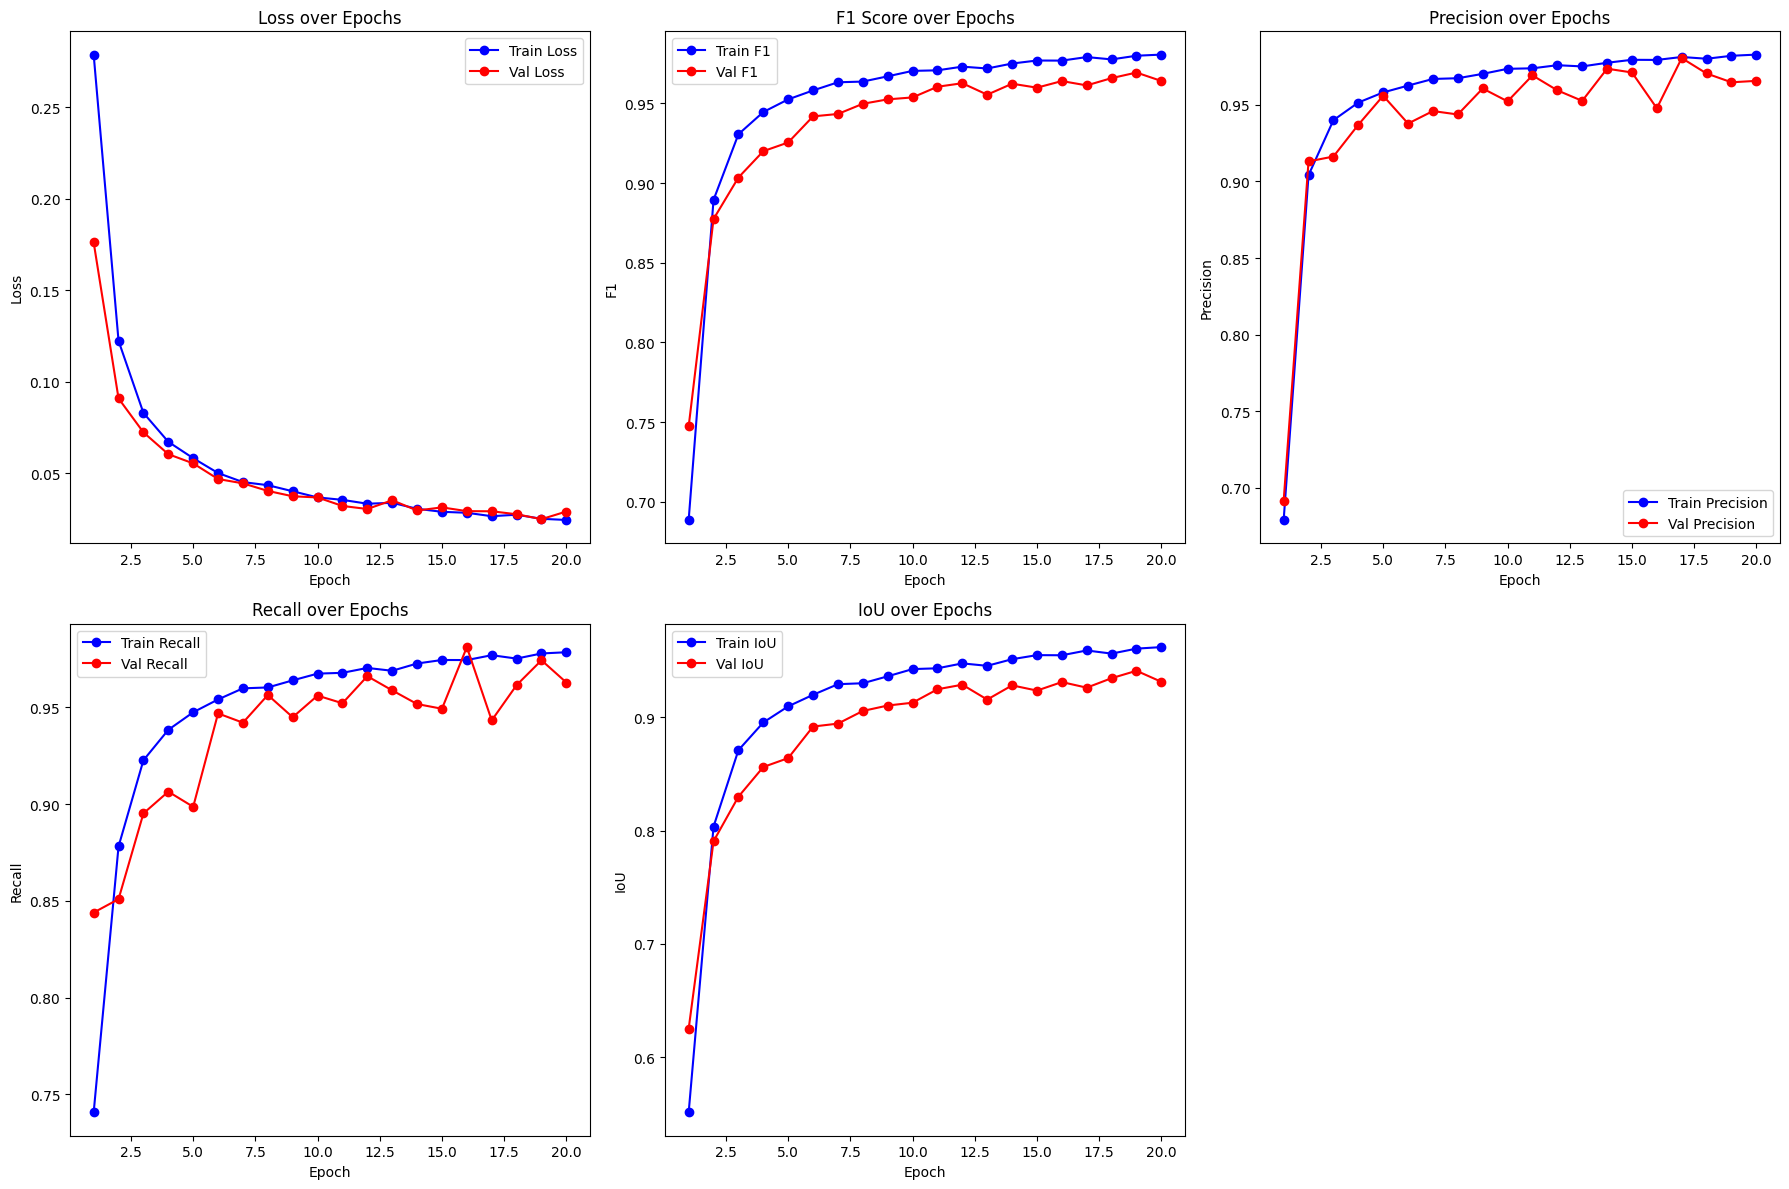

In [ ]:
import matplotlib.pyplot as plt

def plot_training_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(18, 12))

    # Loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-o', label='Val Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # F1
    plt.subplot(2, 3, 2)
    plt.plot(epochs, history['train_f1'], 'b-o', label='Train F1')
    plt.plot(epochs, history['val_f1'], 'r-o', label='Val F1')
    plt.title("F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.legend()

    # Precision
    plt.subplot(2, 3, 3)
    plt.plot(epochs, history['train_precision'], 'b-o', label='Train Precision')
    plt.plot(epochs, history['val_precision'], 'r-o', label='Val Precision')
    plt.title("Precision over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.legend()

    # Recall
    plt.subplot(2, 3, 4)
    plt.plot(epochs, history['train_recall'], 'b-o', label='Train Recall')
    plt.plot(epochs, history['val_recall'], 'r-o', label='Val Recall')
    plt.title("Recall over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend()

    # IoU
    plt.subplot(2, 3, 5)
    plt.plot(epochs, history['train_iou'], 'b-o', label='Train IoU')
    plt.plot(epochs, history['val_iou'], 'r-o', label='Val IoU')
    plt.title("IoU over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function using your saved history
plot_training_metrics(history)

In [ ]:
import torch
from torch.utils.data import DataLoader

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# -----------------------------
# Step 1: Load your test dataset
# -----------------------------
test_dataset = ChangeDetectionDataset(root_dir="/content/GEE_Exports/Splits", split='test')
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# -----------------------------
# Step 2: Load model and weights
# -----------------------------
model = ChangeFormer(num_classes=1).to(device)
model.load_state_dict(torch.load("/content/best_model.pth", map_location=device))
model.eval()

# -----------------------------
# Step 3: Predict on test dataset
# -----------------------------
all_preds = []

with torch.no_grad():
    for img1, img2, _ in test_loader:  # ignore labels
        img1, img2 = img1.to(device), img2.to(device)
        outputs = model(img1, img2)
        preds = torch.sigmoid(outputs)    # probabilities
        preds = (preds > 0.5).float()     # binary masks
        all_preds.append(preds.cpu())

# Combine all predictions into a single tensor
all_preds = torch.cat(all_preds, dim=0)
print(f"Predictions shape: {all_preds.shape}")

# -----------------------------
# Optional: Sample a few predictions for visualization
# -----------------------------
sample_indices = torch.randint(0, len(all_preds), (5,))
sample_preds = all_preds[sample_indices]
print(f"Sampled predictions shape: {sample_preds.shape}")

[TEST] Found 4425 matching samples
Predictions shape: torch.Size([4425, 1, 256, 256])
Sampled predictions shape: torch.Size([5, 1, 256, 256])


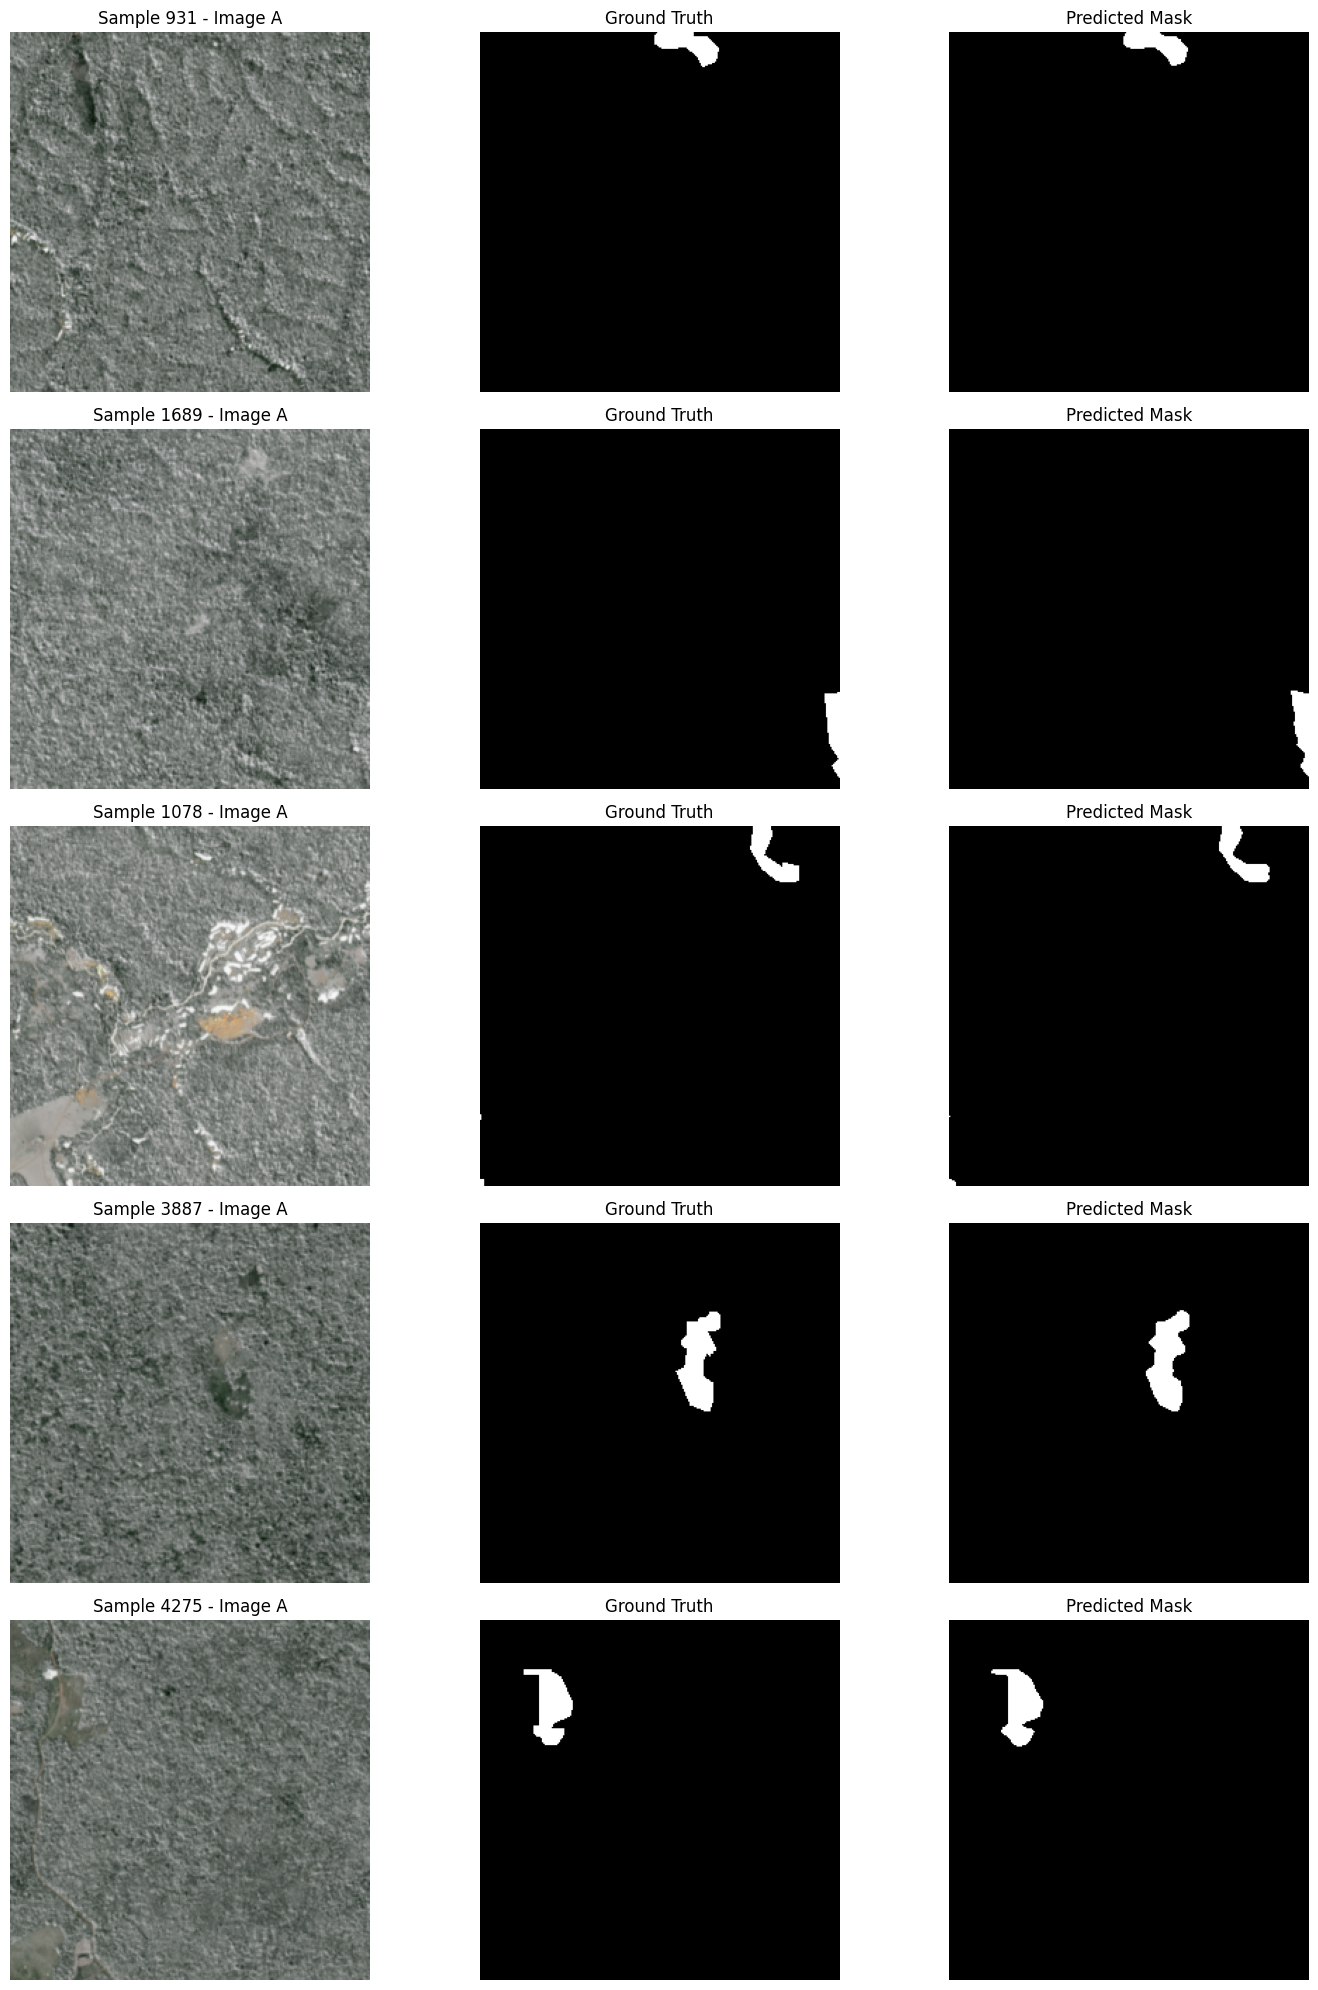

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Normalize images for display
def normalize_tensor_image(img_tensor):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img

num_samples = 5  # number of random samples to show
sample_indices = random.sample(range(len(test_dataset)), num_samples)

plt.figure(figsize=(15, num_samples * 4))

for i, idx in enumerate(sample_indices):
    img1, img2, label = test_dataset[idx]
    pred_mask = all_preds[idx].squeeze(0).numpy()  # remove channel dim
    img1_np = normalize_tensor_image(img1)

    # Image A
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.title(f"Sample {idx} - Image A")
    plt.imshow(img1_np)
    plt.axis('off')

    # Ground truth mask
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.title("Ground Truth")
    plt.imshow(label.squeeze(0).numpy(), cmap='gray')
    plt.axis('off')

    # Predicted mask
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os, random

# Normalize with percentiles
def normalize_percentile(img, lower_percentile=2, upper_percentile=99):
    img_normalized = np.zeros_like(img, dtype=np.float32)
    for band in range(img.shape[2]):
        band_data = img[:, :, band]
        lower_val, upper_val = np.percentile(band_data, [lower_percentile, upper_percentile])
        band_data = np.clip(band_data, lower_val, upper_val)
        band_data = (band_data - lower_val) / (upper_val - lower_val + 1e-8)
        img_normalized[:, :, band] = band_data
    return img_normalized

def visualize_patch(patch_dir, patch_name, show_overlay=True, show_diff=True):
    """
    Visualize a patch with options for overlay and difference images.
    patch_dir: root folder containing A/, B/, and label/
    patch_name: name of the patch file (e.g., "patch_001.tif")
    """
    img_2020_path = f'{patch_dir}/A/{patch_name}'
    img_2021_path = f'{patch_dir}/B/{patch_name}'
    mask_path = f'{patch_dir}/label/{patch_name}'

    for path in [img_2020_path, img_2021_path, mask_path]:
        if not os.path.exists(path):
            print(f"Error: {path} not found")
            return False

    try:
        with rasterio.open(img_2020_path) as src:
            img_2020 = src.read([1, 2, 3]).transpose(1, 2, 0)
            img_2020 = normalize_percentile(img_2020)

        with rasterio.open(img_2021_path) as src:
            img_2021 = src.read([1, 2, 3]).transpose(1, 2, 0)
            img_2021 = normalize_percentile(img_2021)

        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        # Prepare plots
        ncols = 2 + int(show_overlay) + int(show_diff)
        plt.figure(figsize=(5*ncols, 5))

        # 2020
        plt.subplot(1, ncols, 1)
        plt.imshow(img_2020)
        plt.title(f'2020 Patch {patch_name}')
        plt.axis('off')

        # 2021
        plt.subplot(1, ncols, 2)
        plt.imshow(img_2021)
        plt.title(f'2021 Patch {patch_name}')
        plt.axis('off')

        # Overlay
        if show_overlay:
            overlay = img_2021.copy()
            overlay[mask == 1] = [1, 0, 0]  # red deforested pixels
            plt.subplot(1, ncols, 3)
            plt.imshow(overlay)
            plt.title(f'2021 + Mask\nDeforested: {np.sum(mask):,}')
            plt.axis('off')

        # Difference
        if show_diff:
            diff_img = np.clip(img_2021 - img_2020, 0, 1)
            plt.subplot(1, ncols, ncols)
            plt.imshow(diff_img)
            plt.title('Difference (2021 - 2020)')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Print stats
        print(f"Patch {patch_name}:")
        print(f"Mask - Deforested pixels (1): {np.sum(mask):,}")
        print(f"Mask - Non-deforested pixels (0): {np.sum(mask == 0):,}")
        return True
    except Exception as e:
        print(f"Error processing {patch_name}: {str(e)}")
        return False


# Example usage (train/test/val):
patch_dir = "/content/GEE_Exports/Splits/test"
label_dir = f"{patch_dir}/label"
patch_files = [f for f in os.listdir(label_dir) if f.endswith('.tif')]

# Visualize 3 random patches
for _ in range(3):
    random_patch = random.choice(patch_files)
    print(f"\nVisualizing random patch: {random_patch}")
    visualize_patch(patch_dir, random_patch, show_overlay=True, show_diff=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from google.colab import drive
import shutil, os

# Source and destination paths
src_folder = "/content/GEE_Exports/Splits"
dst_folder = "/content/drive/MyDrive/GEE_Exports/Splits"

# Make sure the destination parent folder exists
os.makedirs(os.path.dirname(dst_folder), exist_ok=True)

# Copy recursively (allow overwrite if folder already exists)
shutil.copytree(src_folder, dst_folder, dirs_exist_ok=True)

print(f"Copied {src_folder} -> {dst_folder}")

Copied /content/GEE_Exports/Splits -> /content/drive/MyDrive/GEE_Exports/Splits


In [ ]:
import shutil

src_path = '/content/GEE_Exports/Masks'
dst_path = '/content/drive/MyDrive/GEE_Exports/fullscl/Masks'

# Copy the entire "Masks" folder into Google Drive
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

'/content/drive/MyDrive/GEE_Exports/fullscl/Masks'

In [ ]:
import shutil
import os

src_path = '/content/GEE_Exports/Images'
dst_path = '/content/drive/MyDrive/GEE_Exports/fullscl/Images'

# Remove destination folder if it exists (this deletes everything inside!)
if os.path.exists(dst_path):
    shutil.rmtree(dst_path)

# Copy source folder to destination
shutil.copytree(src_path, dst_path)

'/content/drive/MyDrive/GEE_Exports/fullscl/Images'

In [ ]:
import shutil
import os

# Define the folder to delete
mask_folder = '/content/GEE_Exports'

# Check if the folder exists and delete it
if os.path.exists(mask_folder):
    try:
        shutil.rmtree(mask_folder)
        print(f"Successfully deleted {mask_folder}")
    except Exception as e:
        print(f"Error deleting {mask_folder}: {str(e)}")
else:
    print(f"Folder {mask_folder} does not exist")

Successfully deleted /content/GEE_Exports


In [ ]:
import os
import io
import json
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape, mapping
import matplotlib.pyplot as plt
import gradio as gr
import folium
from folium.plugins import HeatMap
import logging
import time
import uuid
import matplotlib.patches as mpatches
import urllib.request
import urllib.error

# ---------------------------
# Setup Logging
# ---------------------------
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# _________________________
# Initialize the model
# _________________________
class FeatureDifferenceModule(nn.Module):
    """Computes feature differences using absolute difference and Conv2D."""
    def __init__(self, in_channels):
        super(FeatureDifferenceModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(in_channels // 2)
        self.relu = nn.ReLU()

    def forward(self, feat1, feat2):
        x = torch.abs(feat1 - feat2)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class DeconvDecoder(nn.Module):
    """Deconvolution-based decoder for better spatial reconstruction."""
    def __init__(self, in_channels, num_classes):
        super(DeconvDecoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(in_channels // 2, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, num_classes, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        return x

class ChangeFormer(nn.Module):
    """Transformer-based Change Detection Model with shared encoder."""
    def __init__(self, img_size=256, num_classes=1):
        super(ChangeFormer, self).__init__()
        self.encoder = VisionTransformer(
            img_size=img_size,
            patch_size=16,
            embed_dim=384,
            depth=4,
            num_heads=6,
            in_chans=4,
        )
        self.feature_diff = FeatureDifferenceModule(in_channels=384)
        self.decoder = DeconvDecoder(in_channels=384, num_classes=num_classes)
        self.img_size = img_size
        self.patch_size = 16

    def forward(self, img1, img2):
        feat1 = self.encoder.forward_features(img1)
        feat2 = self.encoder.forward_features(img2)
        feat1 = feat1[:, 1:, :]
        feat2 = feat2[:, 1:, :]
        B, N, C = feat1.shape
        h = w = self.img_size // self.patch_size
        feat1 = feat1.transpose(1, 2).view(B, C, h, w)
        feat2 = feat2.transpose(1, 2).view(B, C, h, w)
        diff = self.feature_diff(feat1, feat2)
        out = self.decoder(diff)
        out = F.interpolate(out, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChangeFormer(num_classes=1).to(device)
print("ChangeFormer Model Initialized!")

# ---------------------------
# Load Model
# ---------------------------
logger.info(f"Using device: {device}")
try:
    model = ChangeFormer(num_classes=1).to(device)
    model_path = "/content/drive/MyDrive/newmodel/best_model.pth"
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
except Exception as e:
    logger.error(f"Model loading failed: {str(e)}")
    raise

PATCH_SIZE = 256
DEFAULT_THRESHOLD = 0.5
DEFAULT_ALPHA = 0.4
transform = transforms.ToTensor()

# ---------------------------
# Utility Functions
# ---------------------------
def clear_cache():
    """Clear Gradio cache and temporary files to prevent stale data."""
    try:
        if hasattr(gr, 'clear_cache'):
            gr.clear_cache()
            logger.info("Gradio cache cleared.")
        else:
            logger.warning("Gradio cache clearing not supported in this version.")
    except Exception as e:
        logger.error(f"Error clearing Gradio cache: {str(e)}")
    for temp_file in ["overlay.png", "mask.png", "mask_geotiff.tif", "change_polygons.geojson"]:
        if os.path.exists(temp_file):
            try:
                os.remove(temp_file)
                logger.info(f"Removed temporary file: {temp_file}")
            except Exception as e:
                logger.error(f"Failed to remove temporary file {temp_file}: {str(e)}")

def generate_unique_filename(base_name, extension):
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    unique_id = str(uuid.uuid4())[:8]
    return f"{base_name}_{timestamp}_{unique_id}.{extension}"

# ---------------------------
# Legend-enhanced Visualization Functions
# ---------------------------
def add_overlay_legend(overlay_img, original_shape):
    try:
        overlay_pil = Image.fromarray(overlay_img)
        if overlay_pil.size != (original_shape[1], original_shape[0]):
            logger.warning(f"Overlay size {overlay_pil.size} does not match original {original_shape}")
        dpi = 100
        legend_width = 250
        fig_width = (overlay_pil.size[0] + legend_width) / dpi
        fig_height = overlay_pil.size[1] / dpi
        fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
        ax.imshow(overlay_img)
        ax.axis("off")
        red_patch = mpatches.Patch(color='red', alpha=0.5, label='Change Pixels')
        gray_patch = mpatches.Patch(color='lightgray', alpha=0.5, label='Unchanged')
        ax.legend(handles=[red_patch, gray_patch], loc="center left",
                 bbox_to_anchor=(1.0, 0.5), fontsize=12, frameon=True,
                 framealpha=1.0, facecolor='white', edgecolor='black')
        buf = io.BytesIO()
        plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0.1, dpi=dpi)
        plt.close(fig)
        buf.seek(0)
        result_img = Image.open(buf)
        logger.info(f"Overlay with legend size: {result_img.size} (original content: {overlay_pil.size})")
        return result_img
    except Exception as e:
        logger.error(f"Failed to add overlay legend: {str(e)}")
        raise

def add_mask_legend(mask, original_shape):
    try:
        mask_pil = Image.fromarray(mask, mode='L')
        if mask_pil.size != (original_shape[1], original_shape[0]):
            logger.warning(f"Mask size {mask_pil.size} does not match original {original_shape}")
        dpi = 100
        legend_width = 250
        fig_width = (mask_pil.size[0] + legend_width) / dpi
        fig_height = mask_pil.size[1] / dpi
        fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
        cmap = plt.cm.get_cmap("gray", 2)
        ax.imshow(mask, cmap=cmap)
        ax.axis("off")
        black_patch = mpatches.Patch(color='black', label='No Change')
        white_patch = mpatches.Patch(color='white', label='Change Pixels')
        ax.legend(handles=[black_patch, white_patch], loc="center left",
                 bbox_to_anchor=(1.0, 0.5), fontsize=12, frameon=True,
                 framealpha=1.0, facecolor='white', edgecolor='black')
        buf = io.BytesIO()
        plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0.1, dpi=dpi)
        plt.close(fig)
        buf.seek(0)
        result_img = Image.open(buf)
        logger.info(f"Mask with legend size: {result_img.size} (original content: {mask_pil.size})")
        return result_img
    except Exception as e:
        logger.error(f"Failed to add mask legend: {str(e)}")
        raise

def add_heatmap_legend(mask):
    try:
        dpi = 100
        fig, ax = plt.subplots(figsize=(mask.shape[1] / dpi, mask.shape[0] / dpi), dpi=dpi)
        im = ax.imshow(mask, cmap="Reds", interpolation="nearest")
        ax.axis("off")
        cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.04)
        cbar.set_label("Change Intensity", fontsize=12)
        buf = io.BytesIO()
        plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0.1, dpi=dpi)
        plt.close(fig)
        buf.seek(0)
        return Image.open(buf)
    except Exception as e:
        logger.error(f"Heatmap creation failed: {str(e)}")
        raise

def read_patch_4band(path, x, y, size=PATCH_SIZE):
    try:
        with rasterio.open(path) as src:
            patch = src.read([1, 2, 3, 4], window=rasterio.windows.Window(x, y, size, size))
            patch = np.transpose(patch, (1, 2, 0))
        return patch
    except Exception as e:
        logger.error(f"Failed to read patch from {path}: {str(e)}")
        raise

def get_patch_coords(path, patch_size=PATCH_SIZE):
    try:
        with rasterio.open(path) as src:
            w, h = src.width, src.height
        coords = [(x, y) for y in range(0, h, patch_size)
                  for x in range(0, w, patch_size)
                  if x + patch_size <= w and y + patch_size <= h]
        logger.info(f"Found {len(coords)} patches for {path}")
        return coords, (w, h)
    except Exception as e:
        logger.error(f"Failed to get patch coordinates for {path}: {str(e)}")
        raise

def predict_on_large_4band_tifs(path1, path2, threshold=DEFAULT_THRESHOLD):
    logger.info(f"Predicting on {path1} and {path2}")
    try:
        coords, full_size = get_patch_coords(path1)
        preds = []
        for i, (x, y) in enumerate(coords):
            patch1 = read_patch_4band(path1, x, y)
            patch2 = read_patch_4band(path2, x, y)
            t1 = transform(patch1).unsqueeze(0).to(device)
            t2 = transform(patch2).unsqueeze(0).to(device)
            with torch.no_grad():
                pred = model(t1, t2)
                pred = torch.sigmoid(pred).squeeze().cpu().numpy()
                pred_binary = (pred > threshold).astype(np.uint8)
            preds.append((pred_binary, (x, y)))
        return preds, full_size
    except Exception as e:
        logger.error(f"Prediction failed: {str(e)}")
        raise

def stitch_patches(preds, full_size, patch_size=PATCH_SIZE):
    try:
        stitched = np.zeros((full_size[1], full_size[0]), dtype=np.uint8)
        for patch, (x, y) in preds:
            stitched[y:y+patch_size, x:x+patch_size] = patch
        logger.info(f"Stitched mask shape: {stitched.shape}")
        return stitched
    except Exception as e:
        logger.error(f"Stitching failed: {str(e)}")
        raise

def normalize_rgb(path):
    try:
        with rasterio.open(path) as src:
            rgb = src.read([1, 2, 3]).astype(np.float32)
            rgb = np.transpose(rgb, (1, 2, 0))
            mask = np.any(np.isnan(rgb), axis=-1) | np.all(rgb == 0, axis=-1)
            rgb[mask] = np.nan
            p2 = np.nanpercentile(rgb, 2)
            p98 = np.nanpercentile(rgb, 98)
            if p98 - p2 < 1e-5:
                rgb = np.clip(rgb / 255.0, 0, 1)
            else:
                rgb = np.clip((rgb - p2) / (p98 - p2), 0, 1)
            rgb = np.nan_to_num(rgb)
            return rgb
    except Exception as e:
        logger.error(f"RGB normalization failed for {path}: {str(e)}")
        raise

def overlay_mask(rgb_img, mask, alpha=DEFAULT_ALPHA):
    try:
        if rgb_img.shape[:2] != mask.shape:
            raise ValueError(f"RGB image shape {rgb_img.shape[:2]} does not match mask shape {mask.shape}")
        mask = mask.astype(np.float32)
        color_mask = np.zeros_like(rgb_img)
        color_mask[..., 0] = mask
        blended = (1 - alpha) * rgb_img + alpha * color_mask
        blended = np.clip(blended, 0, 1)
        return (blended * 255).astype(np.uint8)
    except Exception as e:
        logger.error(f"Overlay creation failed: {str(e)}")
        raise

def generate_comment(mask):
    try:
        changed_pixels = np.count_nonzero(mask)
        total_pixels = mask.size
        percent = (changed_pixels / total_pixels) * 100
        logger.info(f"Change percentage: {percent:.2f}%")
        if percent > 10:
            return (
                f"Extensive changes detected: {percent:.2f}% of the area shows alteration. "
                "This suggests major land cover transformation, such as widespread deforestation, "
                "large-scale urban growth, or significant flooding/erosion. "
                "The scale of change may have ecological and socio-economic implications and warrants immediate attention."
            )
        elif percent > 1:
            return (
                f"Moderate changes detected: {percent:.2f}% of the area has shifted. "
                "These could correspond to expanding settlements, agricultural conversion, "
                "or seasonal environmental shifts. "
                "While not extreme, these changes may indicate emerging trends that should be monitored."
            )
        elif percent > 0:
            return (
                f"Localized minor changes detected: {percent:.2f}% of the area affected. "
                "These may result from small construction projects, localized vegetation clearing, "
                "or natural disturbances. "
                "Although small in scale, such changes can accumulate over time."
            )
        else:
            return (
                "No measurable change detected between the two time periods. "
                "The landscape appears stable, with no significant disturbances or developments recorded."
            )
    except Exception as e:
        logger.error(f"Comment generation failed: {str(e)}")
        raise

def compute_stats(mask, path2):
    try:
        changed_pixels = int(np.count_nonzero(mask))
        total_pixels = int(mask.size)
        unchanged = total_pixels - changed_pixels
        percent = (changed_pixels / total_pixels) * 100
        with rasterio.open(path2) as src:
            try:
                resolution = abs(src.res[0]) * abs(src.res[1])
            except Exception:
                resolution = 0
            changed_area = changed_pixels * resolution if resolution > 0 else "N/A (No georeferencing)"
            # Extract bounding box coordinates and CRS
            bounds = src.bounds  # Returns (left, bottom, right, top)
            crs = src.crs.to_string() if src.crs else "N/A (No CRS)"
        return {
            "Changed Pixels": changed_pixels,
            "Unchanged Pixels": unchanged,
            "Change %": round(percent, 2),
            "Estimated Changed Area (m²)": changed_area,
            "Bounding Box": {
                "Left": bounds.left,
                "Bottom": bounds.bottom,
                "Right": bounds.right,
                "Top": bounds.top
            },
            "Coordinate Reference System": crs
        }
    except Exception as e:
        logger.error(f"Stats computation failed: {str(e)}")
        raise

def plot_stats(stats):
    try:
        labels = ["Changed", "Unchanged"]
        values = [stats["Changed Pixels"], stats["Unchanged Pixels"]]
        fig, ax = plt.subplots()
        ax.bar(labels, values, color=['#ff4d4d', '#4da8ff'])
        ax.set_ylabel("Pixels")
        ax.set_title("Change Statistics")
        return fig
    except Exception as e:
        logger.error(f"Stats plotting failed: {str(e)}")
        raise

def create_interactive_heatmap(mask, path2):
    try:
        with rasterio.open(path2) as src:
            bounds = src.bounds
            transform_affine = src.transform
        rows, cols = np.where(mask > 0)
        if len(rows) == 0:
            m = folium.Map(location=[(bounds.top + bounds.bottom) / 2,
                                     (bounds.left + bounds.right) / 2],
                           zoom_start=12, tiles="cartodbpositron")
            return m._repr_html_()
        pts = []
        for r, c in zip(rows, cols):
            x, y = rasterio.transform.xy(transform_affine, r, c)
            pts.append([y, x])
        m = folium.Map(location=[(bounds.top + bounds.bottom) / 2,
                                 (bounds.left + bounds.right) / 2],
                       zoom_start=12, tiles="cartodbpositron")
        HeatMap(pts, radius=6, blur=4, min_opacity=0.3).add_to(m)
        folium.LayerControl().add_to(m)
        return m._repr_html_()
    except Exception as e:
        logger.error(f"Interactive heatmap creation failed: {str(e)}")
        raise

def export_geotiff(mask, path2, output_path=None):
    try:
        output_path = output_path or generate_unique_filename("mask_geotiff", "tif")
        with rasterio.open(path2) as src:
            profile = src.profile
            profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
            with rasterio.open(output_path, "w", **profile) as dst:
                dst.write(mask.astype(rasterio.uint8), 1)
        return output_path
    except Exception as e:
        logger.error(f"GeoTIFF export failed: {str(e)}")
        raise

def export_geojson(mask, reference_path, out_path=None):
    try:
        out_path = out_path or generate_unique_filename("change_polygons", "geojson")
        with rasterio.open(reference_path) as src:
            transform_affine = src.transform
            crs = src.crs
        features = []
        for geom, val in shapes(mask.astype(np.uint8), mask=(mask > 0), transform=transform_affine):
            try:
                geom_shape = shape(geom)
                if not geom_shape.is_valid or geom_shape.is_empty:
                    continue
                features.append({
                    "type": "Feature",
                    "properties": {"value": int(val)},
                    "geometry": mapping(geom_shape)
                })
            except Exception:
                continue
        geojson = {"type": "FeatureCollection", "features": features}
        with open(out_path, "w") as f:
            json.dump(geojson, f)
        return out_path
    except Exception as e:
        logger.error(f"GeoJSON export failed: {str(e)}")
        raise

# ---------------------------
# Prediction Pipeline
# ---------------------------
def predict_change(file1, file2, threshold, alpha, progress=gr.Progress()):
    logger.info("Starting predict_change")
    progress(0, desc="Checking inputs...")
    clear_cache()
    default_output = (None, None, None, None, None, "", {}, None, None, None, None, None, None)
    if file1 is None or file2 is None:
        logger.warning("Missing input files")
        return (*default_output[:5], "Please upload both images.", *default_output[6:])
    path1 = file1.name
    path2 = file2.name
    try:
        with rasterio.open(path1) as src1:
            if src1.count < 4:
                raise ValueError("Image from Year 1 must have at least 4 bands (RGB+NIR).")
            width1, height1 = src1.width, src1.height
        with rasterio.open(path2) as src2:
            if src2.count < 4:
                raise ValueError("Image from Year 2 must have at least 4 bands (RGB+NIR).")
            width2, height2 = src2.width, src2.height
        if (width1, height1) != (width2, height2):
            raise ValueError("Images must have the same dimensions.")
        original_shape = (height1, width1)
    except Exception as e:
        return (*default_output[:5], f"Error: {str(e)}", *default_output[6:])
    progress(0.3, desc="Predicting changes...")
    try:
        preds, full_size = predict_on_large_4band_tifs(path1, path2, threshold=threshold)
        mask = stitch_patches(preds, full_size)
        if mask.shape != original_shape:
            logger.error(f"Stitched mask shape {mask.shape} does not match original shape {original_shape}")
            raise ValueError("Mask dimensions do not match input image dimensions.")
    except Exception as e:
        return (*default_output[:5], f"Error: Prediction failed - {str(e)}", *default_output[6:])
    progress(0.6, desc="Generating visuals...")
    try:
        rgb = normalize_rgb(path2)
        if rgb.shape[:2] != original_shape:
            logger.error(f"RGB image shape {rgb.shape[:2]} does not match original shape {original_shape}")
            raise ValueError("RGB image dimensions do not match input image dimensions.")
        overlay = overlay_mask(rgb, mask, alpha=alpha)
        overlay_path = generate_unique_filename("overlay", "png")
        mask_png_path = generate_unique_filename("mask", "png")
        geotiff_path = export_geotiff(mask, path2)
        geojson_path = export_geojson(mask, path2)
        add_overlay_legend(overlay, original_shape).save(overlay_path)
        add_mask_legend(mask, original_shape).save(mask_png_path)
        map_html = create_interactive_heatmap(mask, path2)
        stats = compute_stats(mask, path2)
        stats_plot = plot_stats(stats)
        comment = generate_comment(mask)
    except Exception as e:
        return (*default_output[:5], f"Error: Visualization failed - {str(e)}", *default_output[6:])
    progress(1.0, desc="Complete!")
    return (
        Image.fromarray((rgb * 255).astype(np.uint8)),
        Image.open(overlay_path),
        Image.open(mask_png_path),
        add_heatmap_legend(mask),
        comment,
        "Processing complete.",
        stats,
        stats_plot,
        overlay_path,
        mask_png_path,
        geotiff_path,
        geojson_path,
        map_html
    )

# ---------------------------
# Clear Inputs Function
# ---------------------------
def clear_inputs():
    """Clear input fields and reset state."""
    clear_cache()
    return None, None, DEFAULT_THRESHOLD, DEFAULT_ALPHA, "Inputs cleared."

# ---------------------------
# Image URL Validation
# ---------------------------
def validate_image_url(url):
    """Validate if an image URL is accessible."""
    try:
        with urllib.request.urlopen(url, timeout=5) as response:
            if response.getcode() == 200:
                return url
    except (urllib.error.URLError, urllib.error.HTTPError) as e:
        logger.warning(f"Failed to load image from {url}: {str(e)}")
    return None

# ---------------------------
# Gradio Dashboard with Tabs
# ---------------------------
with gr.Blocks(title="Change Detection Dashboard", theme=gr.themes.Soft()) as demo:
    gr.Markdown("""
    # Change Detection Dashboard
    A powerful tool for analyzing land cover changes using satellite imagery.
    """)

    with gr.Tab("Home"):
        gr.Markdown("""
        ## Welcome to the Change Detection Dashboard
        Discover insights into land cover transformations with our advanced change detection tool powered by deep learning. Upload satellite images to analyze changes over time, visualize results, and download detailed outputs.

        ---

        ### Key Features
        - **Advanced Analysis**: Detect changes in satellite imagery with at least 4 bands (RGB+NIR) using a transformer-based model.
        - **Comprehensive Visualizations**: View raw images, change overlays, binary masks, heatmaps, and interactive maps.
        - **Downloadable Outputs**: Export results as GeoTIFF, GeoJSON, or PNG files with legends for clarity.
        - **User-Friendly Interface**: Navigate through intuitive tabs for uploading, analyzing, and exploring results.

        ---

        ### How to Use
        1. Go to the **Upload** tab to upload two GeoTIFF images (Year 1 and Year 2) with at least 4 bands.
        2. Adjust the change threshold and overlay opacity for customized analysis.
        3. View results in the **Analysis**, **Stats**, **Downloads**, and **Interactive Heatmap** tabs.
        4. Download high-resolution outputs or explore the interactive heatmap for georeferenced insights.

        ---

        ### Get Started
        Navigate to the **Upload** tab to begin analyzing your satellite imagery.
        """)
        with gr.Row():
            # satellite_url = validate_image_url("https://placehold.co/300x200.png?text=Satellite+Imagery")
            # detection_url = validate_image_url("https://placehold.co/300x200.png?text=Change+Detection")
            gr.Image(value=satellite_url if satellite_url else None,
                     label="Example Satellite Imagery",
                     scale=1,
                     placeholder="Image unavailable")
            gr.Image(value=detection_url if detection_url else None,
                     label="Change Detection Output",
                     scale=1,
                     placeholder="Image unavailable")

    with gr.Tab("Upload"):
        gr.Markdown("Upload two GeoTIFF images with at least 4 bands (RGB+NIR) for analysis. Only the first 4 bands (Red, Green, Blue, Near-Infrared) will be used.")
        with gr.Row():
            file1 = gr.File(label="Image from Year 1 (.tif)", file_types=[".tif"])
            file2 = gr.File(label="Image from Year 2 (.tif)", file_types=[".tif"])
        with gr.Row():
            threshold = gr.Slider(0, 1, value=DEFAULT_THRESHOLD, label="Change Threshold", info="Higher values detect stricter changes.")
            alpha = gr.Slider(0, 1, value=DEFAULT_ALPHA, label="Overlay Opacity", info="Controls transparency of change overlay.")
        with gr.Row():
            run_btn = gr.Button("Run Change Detection", variant="primary")
            clear_btn = gr.Button("Clear Inputs", variant="secondary")
        status = gr.Textbox(label="Status", interactive=False)

    with gr.Tab("Analysis"):
        gr.Markdown("### Visualization of Change Detection Results")
        gr.Markdown("Note: Overlay and mask images include legends on the right, which extend the image width. Zoom in or download for full clarity.")
        with gr.Row(equal_height=False):
            out1 = gr.Image(label="Raw RGB (Year 2)", interactive=False, show_download_button=True, scale=1)
            out2 = gr.Image(label="Overlay with Prediction", interactive=False, show_download_button=True, scale=1)
        with gr.Row(equal_height=False):
            out3 = gr.Image(label="Binary Change Mask", interactive=False, show_download_button=True, scale=1)
            out4 = gr.Image(label="Change Heatmap (static)", interactive=False, show_download_button=True, scale=1)
        out5 = gr.Textbox(label="System Comment", interactive=False)

    with gr.Tab("Stats"):
        stats_out = gr.JSON(label="Change Statistics")
        stats_plot = gr.Plot(label="Statistics Plot")

    with gr.Tab("Downloads"):
        dl_overlay = gr.File(label="Download Overlay with Legend", interactive=False)
        dl_mask = gr.File(label="Download Mask with Legend", interactive=False)
        dl_geotiff = gr.File(label="Download GeoTIFF Mask", interactive=False)
        dl_geojson = gr.File(label="Download Change Polygons (GeoJSON)", interactive=False)

    with gr.Tab("Interactive Heatmap"):
        heatmap_out = gr.HTML(label="Dynamic Change Intensity Heatmap")

    with gr.Tab("About"):
        gr.Markdown("""
        ### Change Detection Dashboard
        - Upload **two satellite .tif images** with at least 4 bands (RGB+NIR) in the Upload tab. Only the first 4 bands (Red, Green, Blue, Near-Infrared) will be used.
        - Adjust parameters for customized analysis.
        - View **analysis, statistics, heatmaps**, download results (including GeoTIFF & GeoJSON), and explore an **interactive map preview** in their respective tabs.
        - Overlay and mask images include larger legends on the right, extending the image width to preserve original content. Zoom in or download images to view legends clearly.
        - Use the **Clear Inputs** button to reset the input fields and clear previous results.
        - Download images to view them at full resolution, as the interface may scale large images for display.
        """)

    run_btn.click(
        fn=predict_change,
        inputs=[file1, file2, threshold, alpha],
        outputs=[out1, out2, out3, out4, out5, status, stats_out, stats_plot, dl_overlay, dl_mask, dl_geotiff, dl_geojson, heatmap_out]
    )
    clear_btn.click(
        fn=clear_inputs,
        inputs=[],
        outputs=[file1, file2, threshold, alpha, status]
    )

demo.launch(debug=True)

ChangeFormer Model Initialized!
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://276f6ea0da913df087.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/tmp/ipython-input-1984619664.py:174: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask, mode='L')
/tmp/ipython-input-1984619664.py:182: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("gray", 2)
/tmp/ipython-input-1984619664.py:174: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask, mode='L')
/tmp/ipython-input-1984619664.py:182: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("gray", 2)


In [ ]:
import ee

ee.Authenticate()
ee.Initialize(project='ee-avajade055')

In [ ]:
import gradio as gr
import geemap
import ee
import folium
from google.colab import output

# Enable Colab output for interactive widgets
output.enable_custom_widget_manager()

# Authenticate and initialize GEE (already done, but included for completeness)
try:
    ee.Initialize(project='ee-avajade055')
    print("GEE initialized successfully.")
except Exception as e:
    print(f"GEE initialization failed: {e}")
    # Re-authenticate in Colab if needed
    ee.Authenticate()
    ee.Initialize(project='ee-avajade055')

def create_interactive_map(start_date="2023-01-01", end_date="2023-12-31"):
    try:
        # Create a GEE map optimized for Colab
        Map = geemap.Map(
            center=[21.79, 70.87],
            zoom=8,
            height="500px",
            basemap="HYBRID",
            plugin_Colab=True  # Enable Colab-specific rendering
        )

        # Load Sentinel-2 Surface Reflectance data
        collection = (ee.ImageCollection("COPERNICUS/S2_SR")
                      .filterDate(start_date, end_date)
                      .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
                      .filterBounds(ee.Geometry.Point([70.87, 21.79]).buffer(100000))
                      .first())

        # Define visualization parameters
        vis_params = {
            "bands": ["B4", "B3", "B2"],  # True-color RGB
            "min": 0,
            "max": 3000,
            "gamma": 1.4
        }

        # Add Sentinel-2 layer
        Map.addLayer(collection, vis_params, "Sentinel-2 SR")

        # Add drawing tools for AOI selection
        draw_control = geemap.control.DrawControl(
            polygon={"shapeOptions": {"color": "#ff0000"}},
            rectangle={"shapeOptions": {"color": "#ff0000"}},
            circlemarker={},
            edit=True
        )
        Map.add_control(draw_control)

        # Return map as HTML for Gradio
        html = Map.to_gradio()
        print("Map converted to HTML successfully.")
        return html

    except Exception as e:
        print(f"Error creating map: {e}")
        return f"Error: {e}"

def process_aoi():
    return ("AOI drawn. To process, extract geometry from Map.draw_features. "
            "If map not displaying, check browser console (F12) or try standalone map.")

# Test standalone map (bypass Gradio for debugging)
def test_standalone_map():
    Map = geemap.Map(center=[21.79, 70.87], zoom=8, plugin_Colab=True)
    collection = ee.ImageCollection("COPERNICUS/S2_SR").filterDate("2023-01-01", "2023-12-31").first()
    Map.addLayer(collection, {"bands": ["B4", "B3", "B2"], "min": 0, "max": 3000}, "Sentinel-2 SR")
    return Map

# Create Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("### Interactive Sentinel-2 Surface Reflectance Map")
    gr.Markdown("Draw a polygon or rectangle to select an AOI. If map doesn't display, check browser console (F12).")
    start_date = gr.Textbox(value="2023-01-01", label="Start Date (YYYY-MM-DD)")
    end_date = gr.Textbox(value="2023-12-31", label="End Date (YYYY-MM-DD)")
    map_output = gr.HTML(label="Sentinel-2 Map")
    process_button = gr.Button("Process AOI")
    output_text = gr.Textbox(label="AOI Output")
    test_button = gr.Button("Test Standalone Map")

    gr.Button("Update Map").click(
        fn=create_interactive_map,
        inputs=[start_date, end_date],
        outputs=map_output
    )
    process_button.click(process_aoi, outputs=output_text)
    test_button.click(test_standalone_map, outputs=map_output)

# Launch Gradio app in Colab
if __name__ == "__main__":
    try:
        demo.launch(share=False, inline=True, debug=True)  # Run inline in Colab
    except Exception as e:
        print(f"Gradio launch failed: {e}")

GEE initialized successfully.
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
%run /content/drive/MyDrive/DeforestationApp/app.py

In [ ]:
cd /content/drive/MyDrive/DeforestationApp

/content/drive/MyDrive/DeforestationApp


In [ ]:
!ngrok authtoken 31bMiaz5jLqezITFX6GtMzf4jZ0_2XXrtZ1nEvho1PyrUGbBf

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!pkill ngrok

In [ ]:
!streamlit run /content/drive/MyDrive/DeforestationApp/app.py &>/dev/null &
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print(f"Access your Streamlit app at: {public_url}")

Access your Streamlit app at: NgrokTunnel: "https://52fa3c39bfae.ngrok-free.app" -> "http://localhost:8501"
